In [ ]:
import os
import glob

from tqdm import trange
import random
import math

from dateutil import parser
from datetime import datetime
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
config = {
  "plots": {
        "show_plots": False,
        "xticks_interval": 1200,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_test": "#FF4136",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "data": {
        "window_size": 100, #100 !!!!!!!!!!!!
        "train_split_size": 0.80,
    }, 
    "model_MO": {
        "input_size": 1, # since we are only using 1 feature, price
        "num_lstm_layers": 5,
        "lstm_size": 16,
        "dropout": 0.25,
        "output_size": 1,
    },
    "training_MO": {
        "batch_size": 64,
        "num_epoch": 50,
        "learning_rate": 0.005,
        "scheduler_step_size": 10,
    },
    "model_MM": {
        "input_size": 1, # since we are only using 1 feature, price
        "num_lstm_layers": 5,
        "lstm_size": 16,
        "dropout": 0.4,
        "target_len": 60,
        "stride": 1,
        "patience": 5, # number of epochs to wait for Early Stopping
    },
    "training_MM": {
        "batch_size": 256,
        "num_epoch": 15,
        "learning_rate": 0.004,
        "scheduler_step_size": 10,
    },
    "paths": {
        "drive": {
            "agg_trade": {
                "train": "/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/",
                "test": "/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/", 
            },
            "orderbook": {
                "train": "/content/drive/MyDrive/IP/Repos/LSTM_Transformer/input_data/orderbook_clean.csv",
                "test": "/content/drive/MyDrive/IP/Repos/LSTM_Transformer/input_data/orderbook_test_clean.csv",
            },
            "models": "/content/drive/MyDrive/IP/Repos/LSTM_Transformer/models/",
            "figures": "/content/drive/MyDrive/IP/Repos/LSTM_Transformer/figures/",
        },
        "local": {
            "agg_trade": {
                "train": "./input_data/aggTrade_clean.csv",
                "test": "./input_data/aggTrade_test_clean.csv", 
            },
            "orderbook": {
                "train": "./input_data/orderbook_clean.csv",
                "test": "./input_data/orderbook_test_clean.csv",
            },
            "models": "./models/",
            "figures": "./figures",
        }
    }
}

## Data preparation

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
drive = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
date_train = 'all' 
date_test = 'all'

if drive:
    agg_trade = pd.read_csv(config["paths"]["drive"]["agg_trade"]["train"]+date_train+'/orderbook.csv')    
    # sys.path.append(config["paths"]["drive"]["utils"])
else:
    agg_trade = pd.read_csv(config["paths"]["local"]["agg_trade"]["train"]+date_train+'/orderbook_agg_trade_dollarvol.csv')
    agg_trade_test = pd.read_csv(config["paths"]["local"]["agg_trade"]["test"]+date_test+'/orderbook_agg_trade_dollarvol.csv')

agg_trade['price'] = agg_trade['w_midprice']

## Preparing Data for LSTM MO

In [ ]:
def prepare_data_x(data, window_size, lag):
    # perform windowing
    n_row = data.shape[0] - window_size + 1
    subset = data[:window_size]
    subset_mean = np.mean(subset, axis=0)
    output = np.zeros([n_row, window_size, len(subset_mean)])
    x_mean = np.zeros([n_row, len(subset_mean)])
    x_std = np.zeros([n_row, len(subset_mean)])
    for idx in range(n_row):
        subset = data[idx:idx+window_size]
        subset_mean = np.mean(subset, axis=0)
        subset_std = np.std(subset, axis=0) + 0.01
        subset_norm = (subset-subset_mean)/subset_std
        x_mean[idx,:] = subset_mean
        x_std[idx,:] = subset_std
        output[idx,:,:] = subset_norm
    # output = np.array(output)
    x_mean = np.array(x_mean)
    x_std = np.array(x_std)
    return output[:-lag-1], output[-1], x_mean, x_std

def prepare_data_y(x, window_size, lag):
    output = np.zeros([len(x)-window_size-lag])
    std = 1.1*np.sqrt(lag)+lag*0.01
    for idx in range(0,len(x)-window_size-lag):
        output[idx] = np.log(x[window_size+lag-1+idx,0]/x[window_size-1+idx,0])*10_000
    output = output/std
    return output

def prepare_data(normalized_prices_train, dates_train, normalized_prices_test, dates_test, config, lag=1, plot=False):
    data_x, data_x_unseen, x_mean, x_std = prepare_data_x(normalized_prices_train, window_size=config["data"]["window_size"], lag=lag)
    data_y = prepare_data_y(normalized_prices_train, window_size=config["data"]["window_size"], lag=lag)

    # data_x_test, data_x_unseen_test, x_test_mean, x_test_std = prepare_data_x(normalized_prices_test, window_size=config["data"]["window_size"], lag=lag)
    # data_y_test = prepare_data_y(normalized_prices_test, window_size=config["data"]["window_size"], lag=lag)
    
    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(len(data_x)+config["data"]["window_size"])
        to_plot_data_y_val = np.zeros(len(data_x)+config["data"]["window_size"])
        to_plot_data_y_test = np.zeros(len(data_x_test)+config["data"]["window_size"])
         
        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)
        to_plot_data_y_test = scaler.inverse_transform(data_y_test)

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
        to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

        ## plots
        
        # fig = figure(figsize=(25, 5), dpi=160)
        # fig.patch.set_facecolor((1.0, 1.0, 1.0))
        # plt.plot(dates_train, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        # plt.plot(dates_train, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        # xticks = [data_date[i][11:] if ((i%config["plots"]["xticks_interval"]==0 and (len(data_x)+config["data"]["window_size"]-i) > config["plots"]["xticks_interval"])
        #                            or i==len(data_x)+config["data"]["window_size"]-1) else None for i in range(len(data_x)+config["data"]["window_size"])] # make x ticks nice
        # x = np.arange(0,len(xticks))
                
        # plt.xticks(x, xticks, rotation='vertical')
        # timediff=parser.parse(dates_train[-1])-parser.parse(dates_train[0])
        # timediff=timediff.seconds/60
        
        # plt.tick_params( axis='x', which='both', bottom=False, top=False, labelbottom=False) 
        # plt.title("BTCUSDT - ["+str(dates_train[0])+" - "+str(dates_train[-1])+"] - duration: "+"{:.2f}".format(timediff)+" min")
        # plt.grid(b=None, which='major', axis='y', linestyle='--')
        # plt.legend()
        # plt.show()
        
        # fig = figure(figsize=(25, 5), dpi=160)
        # fig.patch.set_facecolor((1.0, 1.0, 1.0))
        # plt.plot(dates_test[config["data"]["window_size"]:], to_plot_data_y_test, label="Prices (test)", color=config["plots"]["color_test"])
        # timediff=parser.parse(dates_test[-1])-parser.parse(dates_test[config["data"]["window_size"]])
        # timediff=timediff.seconds/60
        
        # plt.tick_params( axis='x', which='both', bottom=False, top=False, labelbottom=False) 
        # plt.title("BTCUSDT - ["+str(dates_test[0])+" - "+str(dates_test[-1])+"] - duration: "+"{:.2f}".format(timediff)+" min")
        # plt.grid(b=None, which='major', axis='y', linestyle='--')
        # plt.legend()
        # plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val

## Preparing Data for LSTM MM

In [ ]:
# The following helper functions and models were based on existing code: https://github.com/lkulowski/LSTM_encoder_decoder


def train_test_split(datetime, price, split = 0.8):
  '''
  split time series into train/test sets
  
  : param datime:                 time array
  : para price:                   feature array
  : para split:                   percent of data to include in training set 
  : return t_train, y_train:      time/feature training and test sets;  
  :        t_val, y_val:        (shape: [# samples, 1]
  '''  
  datetime = np.array(datetime)
  price = np.array(price)
  
  indx_split = int(split * len(price))
  indx_train = np.arange(0, indx_split, dtype=int)
  indx_val = np.arange(indx_split, len(price), dtype=int)
    
  t_train = datetime[indx_train]
  y_train = price[indx_train]
  y_train = y_train.reshape(-1, 1)
  
  t_val = datetime[indx_val]
  y_val = price[indx_val]
  y_val = y_val.reshape(-1, 1)
  
  return t_train, y_train, t_val, y_val 


def windowed_dataset(y, input_window = 5, output_window = 1, stride = 1, num_features = 1):
    '''
    create a windowed dataset
    : param y:                time series feature (array)
    : param input_window:     number of y samples to give model 
    : param output_window:    number of future y samples to predict  
    : param stide:            spacing between windows   
    : param num_features:     number of features (i.e., 1 for us, but we could have multiple features)
    : return X, Y:            arrays with correct dimensions for LSTM
    :                         (i.e., [input/output window size # examples, # features])
    '''
    L = y.shape[0]
    num_samples = (L - input_window - output_window) // stride + 1

    X = np.zeros([input_window, num_samples, num_features])
    Y = np.zeros([output_window, num_samples, num_features])    
    
    for ff in np.arange(num_features):
        for ii in np.arange(num_samples):
            start_x = stride * ii
            end_x = start_x + input_window
            X[:, ii, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + input_window
            end_y = start_y + output_window 
            Y[:, ii, ff] = y[start_y:end_y, ff]

    return X, Y


def numpy_to_torch(x_train, y_train, x_validation, y_validation, device):
    '''
    convert numpy array to PyTorch tensor
    : param x_train:                          windowed training input data (input window size, # examples, # features); np.array
    : return x_train_torch, y_train_torch,
    :        x_test_torch, y_test_torch:      all input np.arrays converted to PyTorch tensors 
    '''
    x_train_torch = torch.from_numpy(x_train).type(torch.Tensor).to(device)
    y_train_torch = torch.from_numpy(y_train).type(torch.Tensor).to(device)

    x_test_torch = torch.from_numpy(x_validation).type(torch.Tensor).to(device)
    y_test_torch = torch.from_numpy(y_validation).type(torch.Tensor).to(device)
    
    return x_train_torch, y_train_torch, x_test_torch, y_test_torch

In [ ]:
datetime_train, price_train, datetime_val, price_val = train_test_split(dates_train, normalized_prices_train, split=config["data"]["train_split_size"])

x_train_to_plot, y_train_to_plot = windowed_dataset(price_train, input_window = config["data"]["window_size"], 
                                              output_window = config["model_MM"]["target_len"], stride = config["model_MM"]["stride"])
x_val_to_plot, y_val_to_plot = windowed_dataset(price_val, input_window = config["data"]["window_size"], 
                                              output_window = config["model_MM"]["target_len"], stride = config["model_MM"]["stride"])

x_train, y_train, x_val, y_val = numpy_to_torch(x_train_to_plot, y_train_to_plot, x_val_to_plot, y_val_to_plot, device)

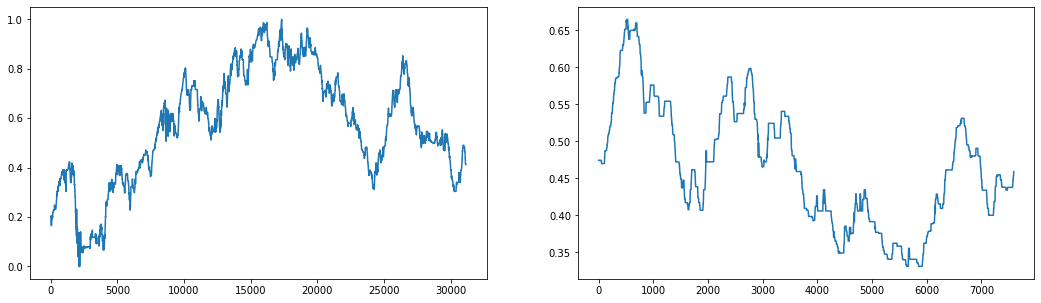

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (18, 5))

ax[0].plot(x_train_to_plot[0])
ax[1].plot(x_val_to_plot[0])
fig.show()

## Defining the Many-to-One LSTM model

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        # x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [ ]:
class LSTM_MO(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.prelu = nn.PReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()


    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)


    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.prelu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]


    def train_model(self, train_dataloader, val_dataloader, learning_rate, scheduler_step_size, n_epochs=50, device="cpu", save_path=None, forecast_window=None):
      
        def run_epoch(dataloader, is_training=False):
            epoch_loss = 0
            outputs = torch.Tensor(0).to(device)
            targets = torch.Tensor(0).to(device)
            if is_training:
                self.train()
            else:
                self.eval()
            for idx, (x, y) in enumerate(dataloader):
                if is_training:
                    optimizer.zero_grad()

                batchsize = x.shape[0]
                x = x.to(device)
                y = y.to(device)
                out = self.forward(x)
                loss = criterion(out.contiguous(), y.contiguous())

                if is_training:
                    loss.backward()
                    optimizer.step()
                
                if not is_training:
                    outputs = torch.cat((outputs.contiguous(), out))
                    targets = torch.cat((targets, y.contiguous()))
                    
                epoch_loss += (loss.detach().item() / batchsize)
                
            lr = scheduler.get_last_lr()[0]
            if not is_training:
                print(outputs.cpu().detach().numpy())
                print(targets.cpu().detach().numpy())
                plt.plot(targets.cpu().detach().numpy(), alpha=0.3)
                plt.plot(outputs.cpu().detach().numpy())
                plt.show()
                r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
                return epoch_loss, lr, r2
            else:
                return epoch_loss, lr

      
        # define optimizer, scheduler and loss function
        criterion = nn.MSELoss(reduction='sum')
        optimizer = optim.AdamW(model_MO.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.995)

        # begin training
        for epoch in range(n_epochs):
            loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
            loss_val, lr_val, r2 = run_epoch(val_dataloader)
            scheduler.step()

            if save_path:
                results = {
                        'model': 'LSTM_MO',
                        'pred_len': forecast_window,
                        'epoch': epoch,
                        'train_loss': loss_train,
                        'val_loss': loss_val,
                        # 'r2_val': r2,
                        'r2_val_sklearn': r2            
                }

                df = pd.DataFrame([results])
                df.to_csv(save_path, mode='a', header=not os.path.exists(save_path), index=False)

            
            print('Epoch[{}/{}] | loss train:{:.6f}, val loss:{:.6f} | lr:{:.6f} | r2: {:.5f}|'
                      .format(epoch+1, n_epochs, loss_train, loss_val, lr_train, r2))

## Defining the Many-to-Many LSTM Model

In [ ]:
class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, dropout = 0.1, num_layers = 1):
        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers 
        '''
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, dropout = dropout)

    def forward(self, x_input):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence 
        '''
        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        '''
        initialize hidden state
        : param batch_size:    x_input.shape[1]
        : return:              zeroed hidden state and cell state 
        '''
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size, hidden_size, dropout = 0.1, num_layers = 1):
        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers 
        '''
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, dropout = dropout)
        self.PReLU = nn.PReLU()
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
        '''
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.PReLU(lstm_out.squeeze(0))
        #output = self.batchnorm(output)
        output = self.linear(output)     
        
        return output, self.hidden

class LSTM_MM(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        '''
        : param input_size:     the number of expected features in the input X
        : param hidden_size:    the number of features in the hidden state h
        '''
        super(LSTM_MM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size, num_layers=num_layers, dropout=dropout)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size, num_layers=num_layers, dropout=dropout)


    def train_model(self, input_tensor_train, target_tensor_train, input_tensor_val, target_tensor_val, n_epochs, target_len,
                    batch_size,device, training_prediction = 'recursive', teacher_forcing_ratio = 0.5, learning_rate = 0.01, dynamic_tf = False):
        '''
        train lstm encoder-decoder
        : param input_tensor:              input data with shape (seq_len, # in batch, number features); PyTorch tensor    
        : param target_tensor:             target data with shape (seq_len, # in batch, number features); PyTorch tensor
        : param n_epochs:                  number of epochs 
        : param target_len:                number of values to predict 
        : param batch_size:                number of samples per gradient update
        : param training_prediction:       type of prediction to make during training ('recursive', 'teacher_forcing', or
        :                                  'mixed_teacher_forcing'); default is 'recursive'
        : param teacher_forcing_ratio:     float [0, 1) indicating how much teacher forcing to use when
        :                                  training_prediction = 'teacher_forcing.' For each batch in training, we generate a random
        :                                  number. If the random number is less than teacher_forcing_ratio, we use teacher forcing.
        :                                  Otherwise, we predict recursively. If teacher_forcing_ratio = 1, we train only using
        :                                  teacher forcing.
        : param learning_rate:             float >= 0; learning rate
        : param dynamic_tf:                use dynamic teacher forcing (True/False); dynamic teacher forcing
        :                                  reduces the amount of teacher forcing for each epoch
        : return losses:                   array of loss function for each epoch
        '''

        # initialize array of losses 
        losses_train = np.full(n_epochs, np.nan)
        losses_val = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches_train = int(input_tensor_train.shape[1] / batch_size)
        n_batches_val = int(input_tensor_val.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                self.train()
                batch_loss = 0.

                for b in range(n_batches_train):
                    # select data 
                    input_batch = input_tensor_train[:, b: b + batch_size, :]
                    target_batch = target_tensor_train[:, b: b + batch_size, :]
                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])
                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)
                    # zero the gradient
                    optimizer.zero_grad()
                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)
                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively 
                        else:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = decoder_output

                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            
                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]
                            
                            # predict recursively 
                            else:
                                decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs.to(device), target_batch.to(device))
                    batch_loss += loss.item()
                    
                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches_train
                batch_loss = math.sqrt(batch_loss) 
                losses_train[it] = batch_loss

                #validation
                self.eval()                
                batch_loss_val = 0.

                for b in range(n_batches_val):
                    # select data 
                    input_batch = input_tensor_val[:, b: b + batch_size, :]
                    target_batch = target_tensor_val[:, b: b + batch_size, :]
                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])
                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)
                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)
                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively 
                        else:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = decoder_output

                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            
                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]
                            
                            # predict recursively 
                            else:
                                decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs.to(device), target_batch.to(device))
                    batch_loss_val += loss.item()
                
                                # loss for epoch 
                    batch_loss_val /= n_batches_val
                    batch_loss_val = math.sqrt(batch_loss_val) 
                    losses_val[it] = batch_loss_val

                # dynamic teacher forcing
                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02
                # progress bar 
                tr.set_postfix(train_loss="{0:.3f}".format(batch_loss),val_loss="{0:.3f}".format(batch_loss_val))
                    
        return losses_train, losses_val

    def predict(self, input_tensor, target_len):
        '''
        : param input_tensor:      input data (seq_len, input_size); PyTorch tensor 
        : param target_len:        number of target values to predict 
        : return np_outputs:       np.array containing predicted values; prediction done recursively 
        '''
        self.eval()

        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs

## Model training - Many to One

In [ ]:
def augment_trade_data(df, lag=0, forecast_window=None):
    if forecast_window:
        df['lag_return'] = np.log(df['price'].shift(forecast_window)/df['price'].shift(forecast_window+1))
        return df.iloc[forecast_window+1:,:]
    if lag == 0:
        return df
    else:
        col_name = 'log_lag'+str(lag)+'_price'
        df[col_name] = np.log(df.price) - np.log(df.price).shift(lag)
        return df.iloc[lag:,:]

Train data shape (575919, 100, 42) (575919,)
Validation data shape (143980, 100, 42) (143980,)
[0.18681203 0.07297483 0.5735026  ... 0.00107901 0.0701317  0.13876061]
[ 5.4871762e-04 -2.0759583e-03  1.1074785e+00 ...  4.6206656e-01
 -9.9808902e-01 -8.9708847e-05]


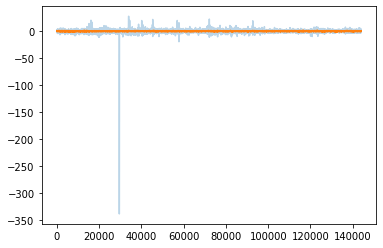

Epoch[1/10] | loss train:3848.429950, val loss:3950.097640 | lr:0.001000 | r2: 0.05707|
[0.12224055 0.04710387 0.5120911  ... 0.08105651 0.06284603 0.2015608 ]
[ 5.4871762e-04 -2.0759583e-03  1.1074785e+00 ...  4.6206656e-01
 -9.9808902e-01 -8.9708847e-05]


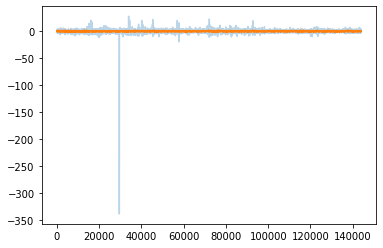

Epoch[2/10] | loss train:3789.358345, val loss:3928.279001 | lr:0.001000 | r2: 0.06228|
[0.11307148 0.05185724 0.5327038  ... 0.08444154 0.02566057 0.13158679]
[ 5.4871762e-04 -2.0759583e-03  1.1074785e+00 ...  4.6206656e-01
 -9.9808902e-01 -8.9708847e-05]


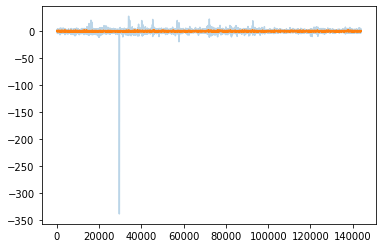

Epoch[3/10] | loss train:3752.475843, val loss:3903.179421 | lr:0.001000 | r2: 0.06827|
[ 0.0804663  -0.00904767  0.536121   ...  0.07597081 -0.02476559
  0.06038591]
[ 5.4871762e-04 -2.0759583e-03  1.1074785e+00 ...  4.6206656e-01
 -9.9808902e-01 -8.9708847e-05]


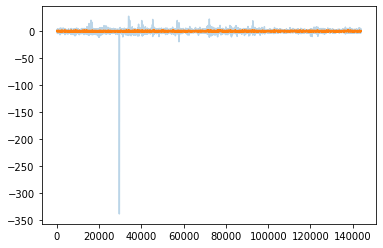

Epoch[4/10] | loss train:3730.788525, val loss:3893.601821 | lr:0.001000 | r2: 0.07055|
[ 0.12291162  0.01901867  0.65799606 ...  0.10073539 -0.02306236
  0.06680828]
[ 5.4871762e-04 -2.0759583e-03  1.1074785e+00 ...  4.6206656e-01
 -9.9808902e-01 -8.9708847e-05]


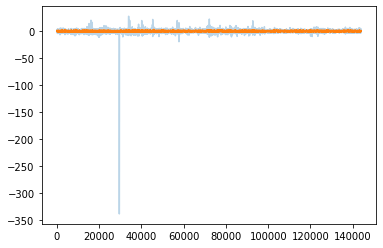

Epoch[5/10] | loss train:3714.352319, val loss:3889.722322 | lr:0.001000 | r2: 0.07148|
[ 1.0188180e-01 -1.0402175e-04  7.9401439e-01 ...  1.2236892e-01
 -1.6933102e-02  5.3895548e-02]
[ 5.4871762e-04 -2.0759583e-03  1.1074785e+00 ...  4.6206656e-01
 -9.9808902e-01 -8.9708847e-05]


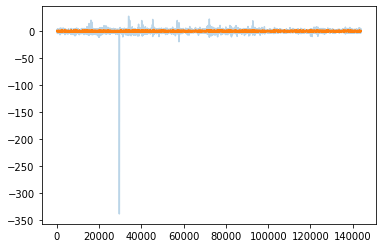

Epoch[6/10] | loss train:3702.355044, val loss:3886.291346 | lr:0.001000 | r2: 0.07230|
[ 0.16625665  0.0716603   0.81562954 ...  0.08280482 -0.02947177
  0.04410708]
[ 5.4871762e-04 -2.0759583e-03  1.1074785e+00 ...  4.6206656e-01
 -9.9808902e-01 -8.9708847e-05]


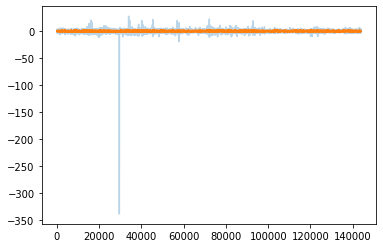

Epoch[7/10] | loss train:3689.782173, val loss:3890.475061 | lr:0.001000 | r2: 0.07130|
[ 0.14127992  0.04199061  0.810388   ...  0.09693195 -0.01000917
  0.05316626]
[ 5.4871762e-04 -2.0759583e-03  1.1074785e+00 ...  4.6206656e-01
 -9.9808902e-01 -8.9708847e-05]


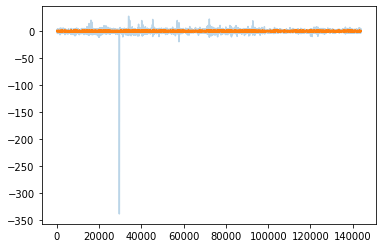

Epoch[8/10] | loss train:3680.115575, val loss:3891.010436 | lr:0.001000 | r2: 0.07117|
[ 0.10892891  0.00375362  0.9646517  ...  0.08340805 -0.01793352
  0.0451007 ]
[ 5.4871762e-04 -2.0759583e-03  1.1074785e+00 ...  4.6206656e-01
 -9.9808902e-01 -8.9708847e-05]


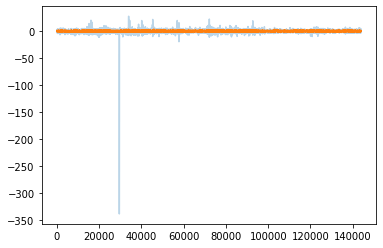

Epoch[9/10] | loss train:3667.427112, val loss:3882.440628 | lr:0.001000 | r2: 0.07322|
[ 0.17633952  0.01431848  0.98906016 ...  0.0493042  -0.02418729
  0.02677561]
[ 5.4871762e-04 -2.0759583e-03  1.1074785e+00 ...  4.6206656e-01
 -9.9808902e-01 -8.9708847e-05]


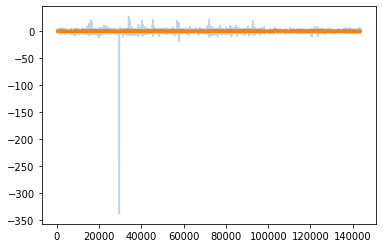

Epoch[10/10] | loss train:3655.545905, val loss:3882.728201 | lr:0.001000 | r2: 0.07315|
Train data shape (575918, 100, 42) (575918,)
Validation data shape (143980, 100, 42) (143980,)
[0.17283282 0.06510127 0.60488915 ... 0.07584129 0.06499922 0.18310162]
[-1.0759074e-03  7.7873164e-01  7.7938426e-01 ... -3.7761599e-01
 -7.0319486e-01  4.7542206e-05]


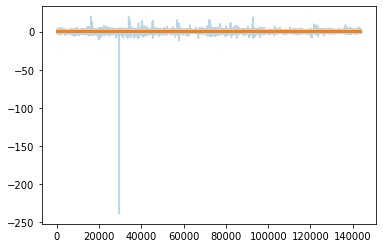

Epoch[1/10] | loss train:4384.931811, val loss:3888.053388 | lr:0.001000 | r2: 0.05093|
[0.14800481 0.08699711 0.65886384 ... 0.12696898 0.10897662 0.22276309]
[-1.0759074e-03  7.7873164e-01  7.7938426e-01 ... -3.7761599e-01
 -7.0319486e-01  4.7542206e-05]


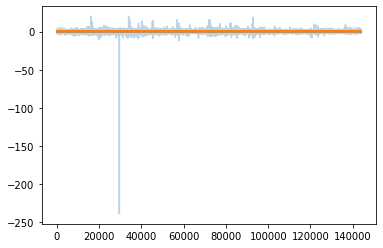

Epoch[2/10] | loss train:4334.583600, val loss:3878.956452 | lr:0.001000 | r2: 0.05315|
[0.10977846 0.03562788 0.7056072  ... 0.12547089 0.14363213 0.24004449]
[-1.0759074e-03  7.7873164e-01  7.7938426e-01 ... -3.7761599e-01
 -7.0319486e-01  4.7542206e-05]


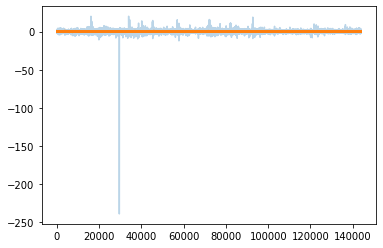

Epoch[3/10] | loss train:4313.310780, val loss:3867.074995 | lr:0.001000 | r2: 0.05605|
[0.1177717  0.0213379  0.6312682  ... 0.05180008 0.07150068 0.20221318]
[-1.0759074e-03  7.7873164e-01  7.7938426e-01 ... -3.7761599e-01
 -7.0319486e-01  4.7542206e-05]


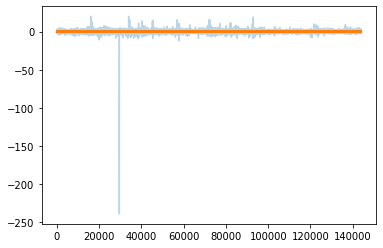

Epoch[4/10] | loss train:4294.568496, val loss:3867.413277 | lr:0.001000 | r2: 0.05597|
[0.08838323 0.0208842  0.69990164 ... 0.08288169 0.05453824 0.21589917]
[-1.0759074e-03  7.7873164e-01  7.7938426e-01 ... -3.7761599e-01
 -7.0319486e-01  4.7542206e-05]


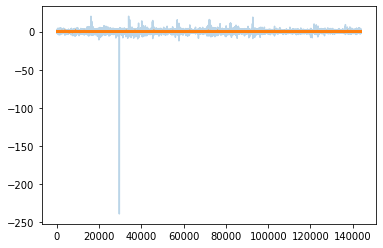

Epoch[5/10] | loss train:4278.265343, val loss:3861.424478 | lr:0.001000 | r2: 0.05743|
[0.12753062 0.04358666 0.754771   ... 0.06491709 0.06703691 0.15859336]
[-1.0759074e-03  7.7873164e-01  7.7938426e-01 ... -3.7761599e-01
 -7.0319486e-01  4.7542206e-05]


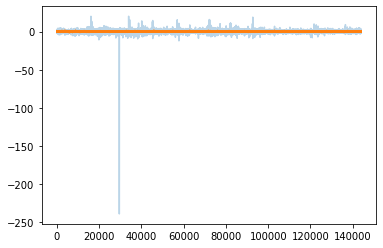

Epoch[6/10] | loss train:4265.811470, val loss:3864.675094 | lr:0.001000 | r2: 0.05664|
[0.1680226  0.07520758 0.7957896  ... 0.07937121 0.07302581 0.19122438]
[-1.0759074e-03  7.7873164e-01  7.7938426e-01 ... -3.7761599e-01
 -7.0319486e-01  4.7542206e-05]


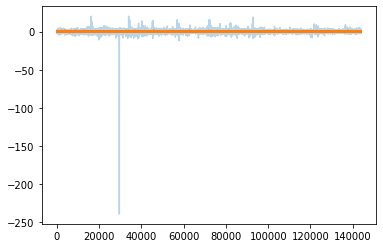

Epoch[7/10] | loss train:4253.266483, val loss:3861.327413 | lr:0.001000 | r2: 0.05745|
[0.14295097 0.03247826 0.7998856  ... 0.08173445 0.0536824  0.17971529]
[-1.0759074e-03  7.7873164e-01  7.7938426e-01 ... -3.7761599e-01
 -7.0319486e-01  4.7542206e-05]


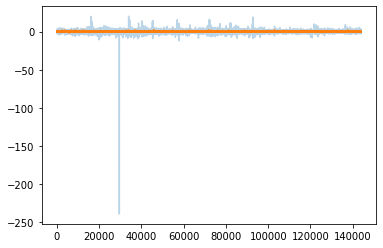

Epoch[8/10] | loss train:4241.621880, val loss:3860.414355 | lr:0.001000 | r2: 0.05768|
[0.14072579 0.03063888 0.88195235 ... 0.09879579 0.08847675 0.17955431]
[-1.0759074e-03  7.7873164e-01  7.7938426e-01 ... -3.7761599e-01
 -7.0319486e-01  4.7542206e-05]


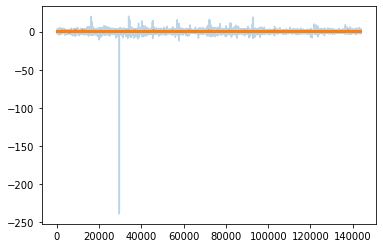

Epoch[9/10] | loss train:4229.940307, val loss:3863.228520 | lr:0.001000 | r2: 0.05699|
[0.17982748 0.09564098 0.86729676 ... 0.06458769 0.07518319 0.1462126 ]
[-1.0759074e-03  7.7873164e-01  7.7938426e-01 ... -3.7761599e-01
 -7.0319486e-01  4.7542206e-05]


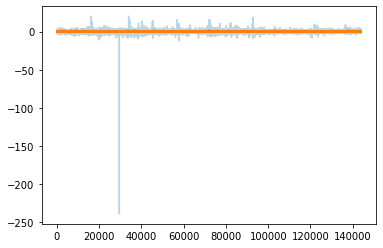

Epoch[10/10] | loss train:4217.561742, val loss:3870.514208 | lr:0.001000 | r2: 0.05521|
Train data shape (575917, 100, 42) (575917,)
Validation data shape (143980, 100, 42) (143980,)
[0.17217544 0.11722105 0.5974819  ... 0.06149305 0.06128325 0.07738645]
[ 0.6343377   0.63336366  0.6890528  ... -0.30749655 -0.57243276
 -0.0086659 ]


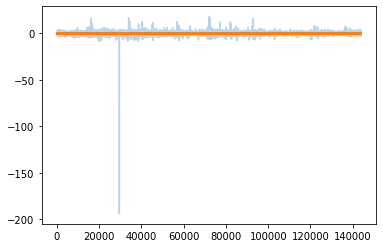

Epoch[1/10] | loss train:4733.077876, val loss:3911.811051 | lr:0.001000 | r2: 0.03975|
[0.15451063 0.09455933 0.5939896  ... 0.08705007 0.03663329 0.1092706 ]
[ 0.6343377   0.63336366  0.6890528  ... -0.30749655 -0.57243276
 -0.0086659 ]


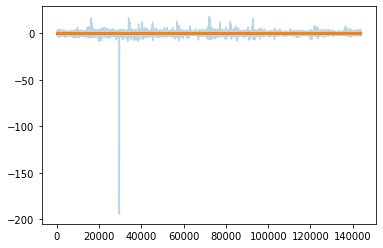

Epoch[2/10] | loss train:4689.202527, val loss:3904.544090 | lr:0.001000 | r2: 0.04153|
[0.16943863 0.16691715 0.59535116 ... 0.11272232 0.02476222 0.10568731]
[ 0.6343377   0.63336366  0.6890528  ... -0.30749655 -0.57243276
 -0.0086659 ]


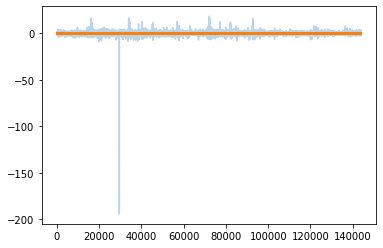

Epoch[3/10] | loss train:4668.109149, val loss:3901.836175 | lr:0.001000 | r2: 0.04220|
[0.1471667  0.08619684 0.6314753  ... 0.10062307 0.0444897  0.0978355 ]
[ 0.6343377   0.63336366  0.6890528  ... -0.30749655 -0.57243276
 -0.0086659 ]


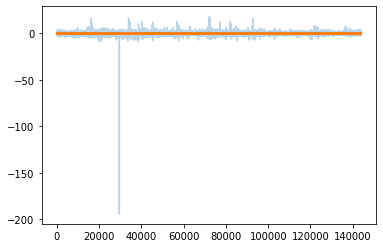

Epoch[4/10] | loss train:4652.759307, val loss:3900.026274 | lr:0.001000 | r2: 0.04264|
[0.10982453 0.06040265 0.60684127 ... 0.0870861  0.03032879 0.10746699]
[ 0.6343377   0.63336366  0.6890528  ... -0.30749655 -0.57243276
 -0.0086659 ]


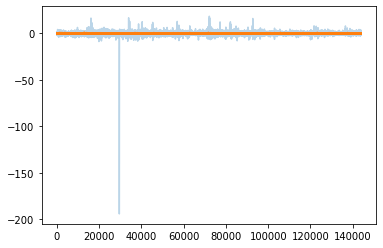

Epoch[5/10] | loss train:4639.401083, val loss:3900.749308 | lr:0.001000 | r2: 0.04246|
[0.12171075 0.08555105 0.63241893 ... 0.11549245 0.04882644 0.1273523 ]
[ 0.6343377   0.63336366  0.6890528  ... -0.30749655 -0.57243276
 -0.0086659 ]


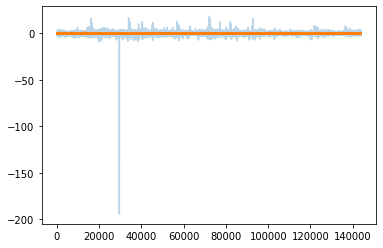

Epoch[6/10] | loss train:4627.995838, val loss:3901.278420 | lr:0.001000 | r2: 0.04233|
[0.12763566 0.12575811 0.6429397  ... 0.16707371 0.05558849 0.11171514]
[ 0.6343377   0.63336366  0.6890528  ... -0.30749655 -0.57243276
 -0.0086659 ]


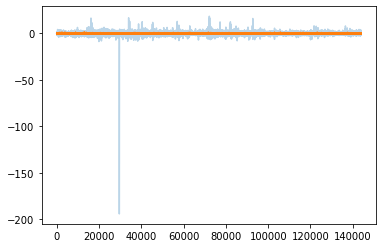

Epoch[7/10] | loss train:4614.497138, val loss:3901.710722 | lr:0.001000 | r2: 0.04223|
[0.10643965 0.11076137 0.6416651  ... 0.12464696 0.0531559  0.10743394]
[ 0.6343377   0.63336366  0.6890528  ... -0.30749655 -0.57243276
 -0.0086659 ]


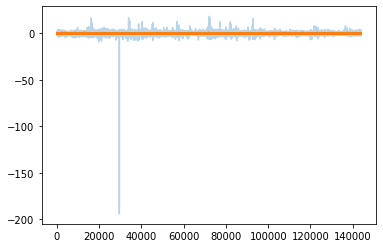

Epoch[8/10] | loss train:4603.708964, val loss:3902.045260 | lr:0.001000 | r2: 0.04215|
[0.09102146 0.08879073 0.6306202  ... 0.12200063 0.06080223 0.08775789]
[ 0.6343377   0.63336366  0.6890528  ... -0.30749655 -0.57243276
 -0.0086659 ]


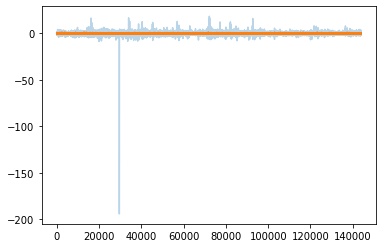

Epoch[9/10] | loss train:4589.982058, val loss:3905.537995 | lr:0.001000 | r2: 0.04129|
[0.09716532 0.07243071 0.5807945  ... 0.11959051 0.03954557 0.07963628]
[ 0.6343377   0.63336366  0.6890528  ... -0.30749655 -0.57243276
 -0.0086659 ]


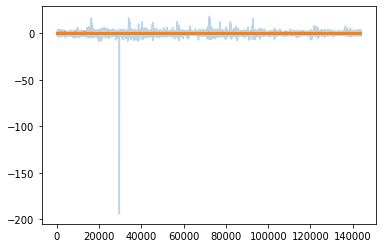

Epoch[10/10] | loss train:4577.208550, val loss:3905.592521 | lr:0.001000 | r2: 0.04127|
Train data shape (575916, 100, 42) (575916,)
Validation data shape (143980, 100, 42) (143980,)
[0.19753748 0.11399964 0.5477327  ... 0.01920735 0.03896466 0.05935368]
[ 0.54746866  0.5942809   0.95035315 ... -0.26558483 -0.5020757
 -0.50335735]


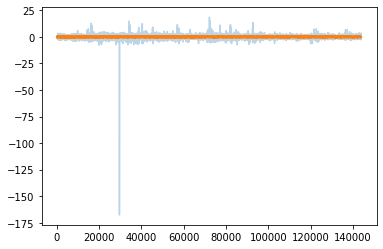

Epoch[1/10] | loss train:4954.710337, val loss:3925.847285 | lr:0.001000 | r2: 0.03149|
[0.13293329 0.05014374 0.5383501  ... 0.00803909 0.00436188 0.0293924 ]
[ 0.54746866  0.5942809   0.95035315 ... -0.26558483 -0.5020757
 -0.50335735]


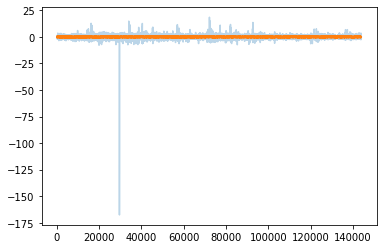

Epoch[2/10] | loss train:4914.358279, val loss:3920.486372 | lr:0.001000 | r2: 0.03282|
[ 0.10751228  0.06960522  0.55644643 ...  0.03892986 -0.01628543
  0.04520828]
[ 0.54746866  0.5942809   0.95035315 ... -0.26558483 -0.5020757
 -0.50335735]


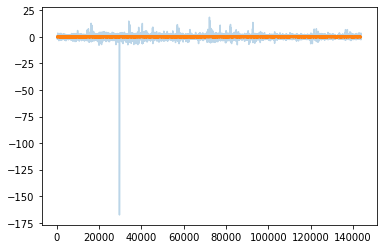

Epoch[3/10] | loss train:4896.544267, val loss:3917.298504 | lr:0.001000 | r2: 0.03360|
[ 0.14291233  0.09026814  0.62501615 ...  0.05902321 -0.03239251
  0.05685218]
[ 0.54746866  0.5942809   0.95035315 ... -0.26558483 -0.5020757
 -0.50335735]


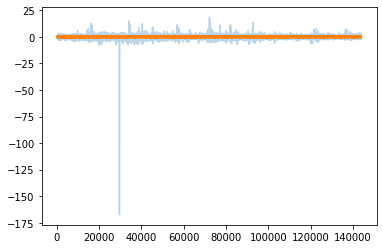

Epoch[4/10] | loss train:4884.225861, val loss:3918.181297 | lr:0.001000 | r2: 0.03338|
[ 0.13159622  0.03809072  0.67848665 ...  0.07665417 -0.01590828
  0.07679342]
[ 0.54746866  0.5942809   0.95035315 ... -0.26558483 -0.5020757
 -0.50335735]


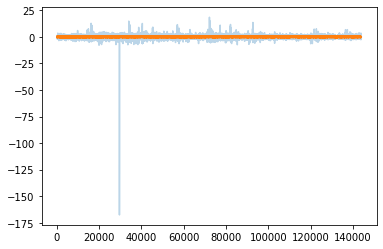

Epoch[5/10] | loss train:4873.104591, val loss:3917.597612 | lr:0.001000 | r2: 0.03353|
[ 0.14476499  0.09967747  0.6751544  ...  0.08216276 -0.02104321
  0.06323801]
[ 0.54746866  0.5942809   0.95035315 ... -0.26558483 -0.5020757
 -0.50335735]


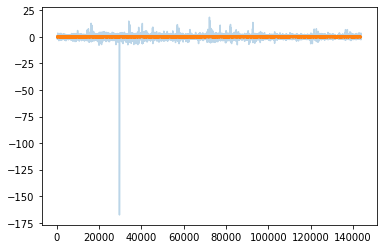

Epoch[6/10] | loss train:4859.968221, val loss:3916.961799 | lr:0.001000 | r2: 0.03369|
[1.4403194e-01 6.8442598e-02 6.2859321e-01 ... 6.4452127e-02 6.7019835e-05
 8.6101443e-02]
[ 0.54746866  0.5942809   0.95035315 ... -0.26558483 -0.5020757
 -0.50335735]


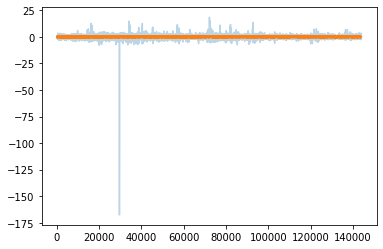

Epoch[7/10] | loss train:4849.500563, val loss:3917.131230 | lr:0.001000 | r2: 0.03364|
[0.13151707 0.08911246 0.6429926  ... 0.04957563 0.00768405 0.09835681]
[ 0.54746866  0.5942809   0.95035315 ... -0.26558483 -0.5020757
 -0.50335735]


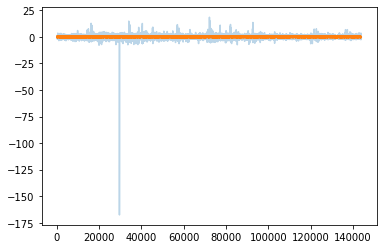

Epoch[8/10] | loss train:4837.276282, val loss:3917.221728 | lr:0.001000 | r2: 0.03362|
[ 0.2726383   0.18892589  0.7041609  ...  0.02409597 -0.02619976
  0.08621775]
[ 0.54746866  0.5942809   0.95035315 ... -0.26558483 -0.5020757
 -0.50335735]


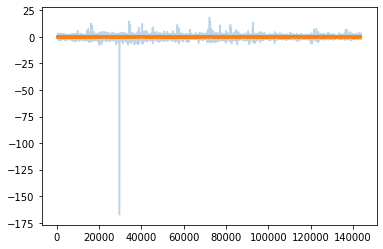

Epoch[9/10] | loss train:4821.101980, val loss:3920.158392 | lr:0.001000 | r2: 0.03290|
[ 0.24186158  0.18798679  0.71466    ... -0.01244048 -0.01554484
  0.09450474]
[ 0.54746866  0.5942809   0.95035315 ... -0.26558483 -0.5020757
 -0.50335735]


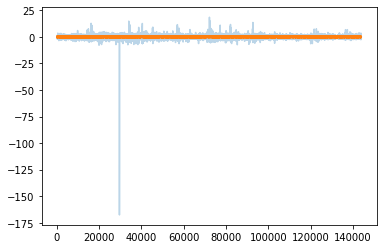

Epoch[10/10] | loss train:4807.329719, val loss:3925.425921 | lr:0.001000 | r2: 0.03160|
Train data shape (575916, 100, 42) (575916,)
Validation data shape (143979, 100, 42) (143979,)
[ 0.06844208  0.5670604   0.09766681 ...  0.00148934 -0.03032764
  0.05234925]
[ 0.84731567  0.8480898   0.35847127 ... -0.24375893 -0.8907127
 -0.4494419 ]


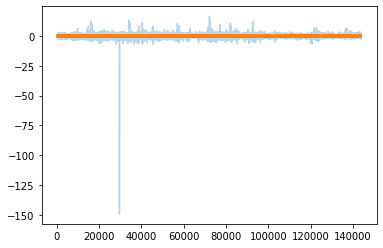

Epoch[1/10] | loss train:5098.608083, val loss:3929.215128 | lr:0.001000 | r2: 0.02540|
[ 0.07084905  0.48942676  0.10701273 ...  0.02285024 -0.00983998
  0.07000489]
[ 0.84731567  0.8480898   0.35847127 ... -0.24375893 -0.8907127
 -0.4494419 ]


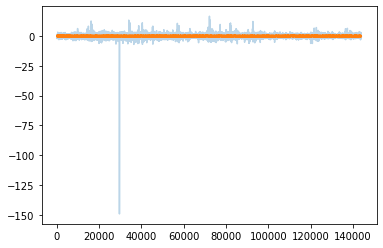

Epoch[2/10] | loss train:5060.837644, val loss:3926.264087 | lr:0.001000 | r2: 0.02613|
[ 0.04682865  0.4810463   0.10943688 ...  0.01993089 -0.00319101
  0.06685254]
[ 0.84731567  0.8480898   0.35847127 ... -0.24375893 -0.8907127
 -0.4494419 ]


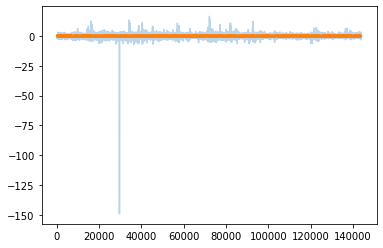

Epoch[3/10] | loss train:5046.190476, val loss:3923.321805 | lr:0.001000 | r2: 0.02686|
[0.08009505 0.50420487 0.11929064 ... 0.03362511 0.0036282  0.08739401]
[ 0.84731567  0.8480898   0.35847127 ... -0.24375893 -0.8907127
 -0.4494419 ]


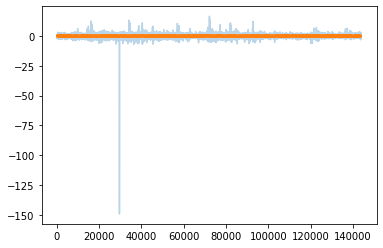

Epoch[4/10] | loss train:5034.869806, val loss:3923.135229 | lr:0.001000 | r2: 0.02690|
[ 0.07685411  0.5263852   0.14858907 ...  0.02251683 -0.00769557
  0.12078351]
[ 0.84731567  0.8480898   0.35847127 ... -0.24375893 -0.8907127
 -0.4494419 ]


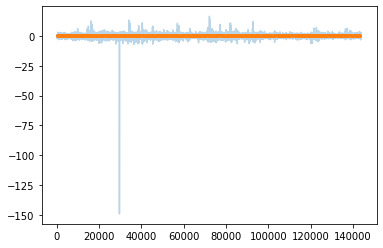

Epoch[5/10] | loss train:5025.015249, val loss:3922.875602 | lr:0.001000 | r2: 0.02697|
[ 4.4093356e-02  5.3770757e-01  1.4318316e-01 ... -1.6919337e-05
  1.1098379e-02  1.0557472e-01]
[ 0.84731567  0.8480898   0.35847127 ... -0.24375893 -0.8907127
 -0.4494419 ]


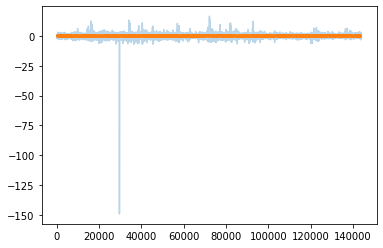

Epoch[6/10] | loss train:5015.064054, val loss:3924.496845 | lr:0.001000 | r2: 0.02657|
[ 0.09022624  0.5371978   0.14805084 ...  0.00663048 -0.00536771
  0.10872683]
[ 0.84731567  0.8480898   0.35847127 ... -0.24375893 -0.8907127
 -0.4494419 ]


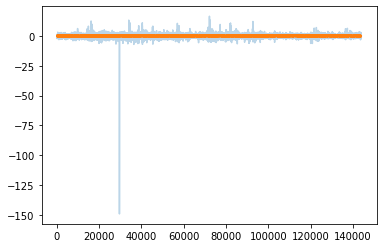

Epoch[7/10] | loss train:5005.887603, val loss:3922.803228 | lr:0.001000 | r2: 0.02699|
[-0.01064698  0.5011435   0.06231219 ...  0.0128066  -0.00942429
  0.11064918]
[ 0.84731567  0.8480898   0.35847127 ... -0.24375893 -0.8907127
 -0.4494419 ]


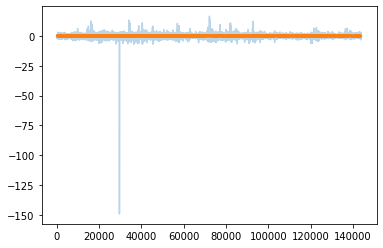

Epoch[8/10] | loss train:4996.664017, val loss:3924.063570 | lr:0.001000 | r2: 0.02667|
[-1.9471817e-02  4.7331479e-01  1.2782520e-01 ...  4.2391568e-04
 -2.1929093e-02  1.0587160e-01]
[ 0.84731567  0.8480898   0.35847127 ... -0.24375893 -0.8907127
 -0.4494419 ]


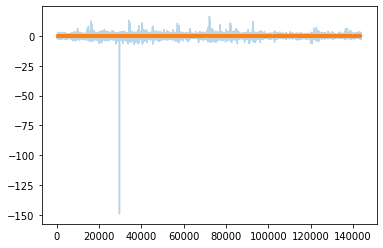

Epoch[9/10] | loss train:4984.604124, val loss:3927.385222 | lr:0.001000 | r2: 0.02585|
[0.01411181 0.5394289  0.21664307 ... 0.07188889 0.02115758 0.10814196]
[ 0.84731567  0.8480898   0.35847127 ... -0.24375893 -0.8907127
 -0.4494419 ]


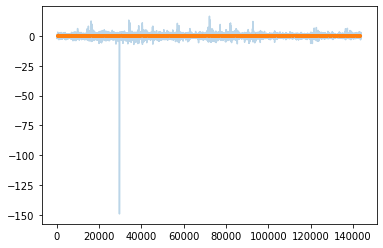

Epoch[10/10] | loss train:4974.496115, val loss:3936.832937 | lr:0.001000 | r2: 0.02350|
Train data shape (575915, 100, 42) (575915,)
Validation data shape (143979, 100, 42) (143979,)
[ 0.0810203   0.40923214  0.09934302 ... -0.00597612  0.01269785
  0.07283111]
[ 0.7718906   0.7729151   0.0392876  ... -0.6253562  -0.81171954
 -0.40909448]


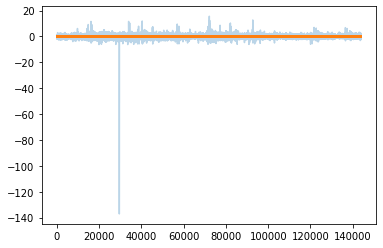

Epoch[1/10] | loss train:5188.887688, val loss:3928.890067 | lr:0.001000 | r2: 0.02032|
[ 0.07152312  0.4301818   0.13248672 ... -0.01957172  0.01883742
  0.10406359]
[ 0.7718906   0.7729151   0.0392876  ... -0.6253562  -0.81171954
 -0.40909448]


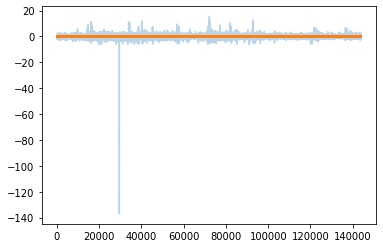

Epoch[2/10] | loss train:5154.121834, val loss:3925.225233 | lr:0.001000 | r2: 0.02123|
[ 0.05397879  0.4490412   0.11565077 ... -0.00667198  0.00149518
  0.11841499]
[ 0.7718906   0.7729151   0.0392876  ... -0.6253562  -0.81171954
 -0.40909448]


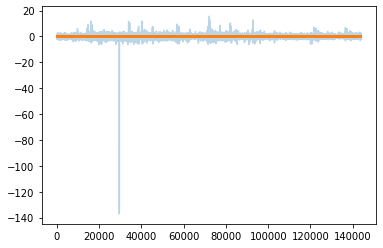

Epoch[3/10] | loss train:5142.206605, val loss:3924.029887 | lr:0.001000 | r2: 0.02153|
[0.06269257 0.45735288 0.08141875 ... 0.0143125  0.01404888 0.10999596]
[ 0.7718906   0.7729151   0.0392876  ... -0.6253562  -0.81171954
 -0.40909448]


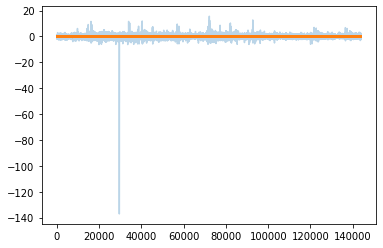

Epoch[4/10] | loss train:5133.443073, val loss:3920.852925 | lr:0.001000 | r2: 0.02232|
[ 0.04110341  0.43115628  0.11349511 ... -0.03691768  0.02490413
  0.09920146]
[ 0.7718906   0.7729151   0.0392876  ... -0.6253562  -0.81171954
 -0.40909448]


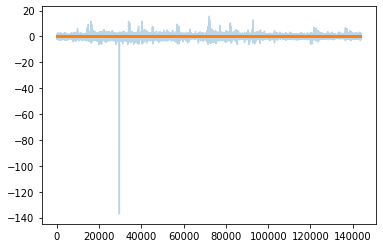

Epoch[5/10] | loss train:5124.667483, val loss:3921.566866 | lr:0.001000 | r2: 0.02214|
[ 0.02837587  0.44898048  0.11170527 ... -0.01635996  0.03158
  0.07608593]
[ 0.7718906   0.7729151   0.0392876  ... -0.6253562  -0.81171954
 -0.40909448]


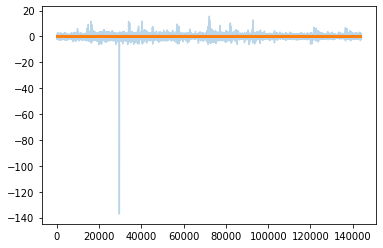

Epoch[6/10] | loss train:5114.512046, val loss:3920.986147 | lr:0.001000 | r2: 0.02229|
[ 0.04657397  0.48119238  0.1188911  ... -0.0061283   0.04883393
  0.07061831]
[ 0.7718906   0.7729151   0.0392876  ... -0.6253562  -0.81171954
 -0.40909448]


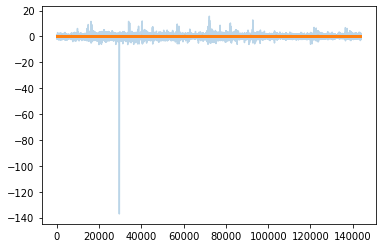

Epoch[7/10] | loss train:5104.582652, val loss:3922.893441 | lr:0.001000 | r2: 0.02181|
[0.02345911 0.48265243 0.10094215 ... 0.03021826 0.0566396  0.06501474]
[ 0.7718906   0.7729151   0.0392876  ... -0.6253562  -0.81171954
 -0.40909448]


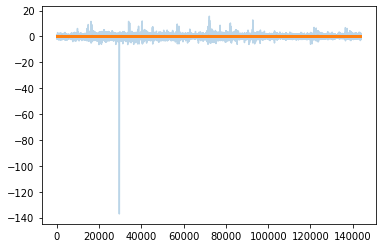

Epoch[8/10] | loss train:5093.677399, val loss:3925.136944 | lr:0.001000 | r2: 0.02125|
[-0.02561776  0.45217896  0.18012756 ...  0.0663923   0.08783426
  0.09787471]
[ 0.7718906   0.7729151   0.0392876  ... -0.6253562  -0.81171954
 -0.40909448]


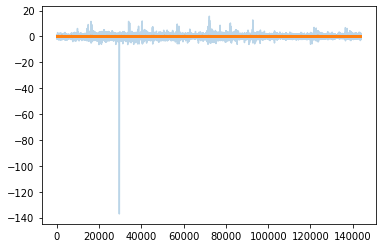

Epoch[9/10] | loss train:5082.093419, val loss:3928.990859 | lr:0.001000 | r2: 0.02029|
[-0.04287951  0.45860833  0.139144   ...  0.03495286  0.08155152
  0.13014728]
[ 0.7718906   0.7729151   0.0392876  ... -0.6253562  -0.81171954
 -0.40909448]


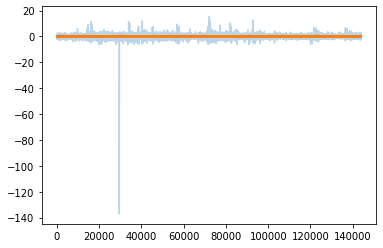

Epoch[10/10] | loss train:5072.305736, val loss:3930.286288 | lr:0.001000 | r2: 0.01996|
Train data shape (575914, 100, 42) (575914,)
Validation data shape (143979, 100, 42) (143979,)
[ 0.06084699  0.40026638  0.12696268 ...  0.01549341  0.00639633
 -0.04084013]
[ 0.71356046  0.44878182 -0.40968573 ... -0.5781038  -0.7498187
 -0.37806404]


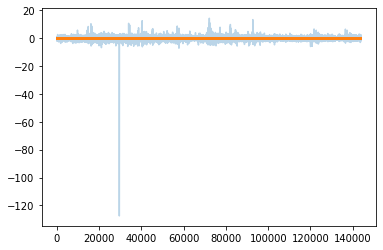

Epoch[1/10] | loss train:5247.243256, val loss:3934.098364 | lr:0.001000 | r2: 0.01602|
[ 0.07710944  0.38838798  0.10795961 ...  0.03496179  0.00181572
 -0.02041796]
[ 0.71356046  0.44878182 -0.40968573 ... -0.5781038  -0.7498187
 -0.37806404]


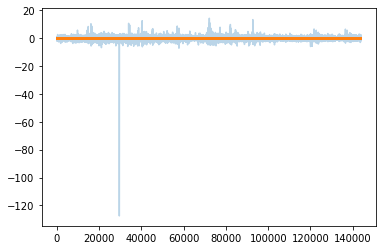

Epoch[2/10] | loss train:5215.129378, val loss:3929.685073 | lr:0.001000 | r2: 0.01713|
[0.062747   0.38145766 0.13861856 ... 0.02830429 0.00386764 0.01267649]
[ 0.71356046  0.44878182 -0.40968573 ... -0.5781038  -0.7498187
 -0.37806404]


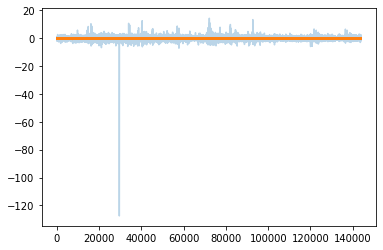

Epoch[3/10] | loss train:5203.271601, val loss:3929.170674 | lr:0.001000 | r2: 0.01725|
[ 0.08139392  0.40459955  0.18124789 ...  0.019638   -0.00963115
  0.01178264]
[ 0.71356046  0.44878182 -0.40968573 ... -0.5781038  -0.7498187
 -0.37806404]


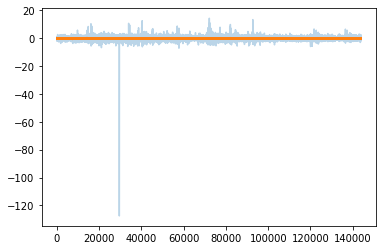

Epoch[4/10] | loss train:5194.097455, val loss:3927.325675 | lr:0.001000 | r2: 0.01772|
[ 0.07218866  0.43608165  0.19106215 ...  0.02133025 -0.00842679
  0.02546327]
[ 0.71356046  0.44878182 -0.40968573 ... -0.5781038  -0.7498187
 -0.37806404]


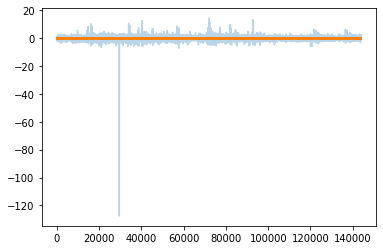

Epoch[5/10] | loss train:5185.982995, val loss:3925.781189 | lr:0.001000 | r2: 0.01810|
[ 0.10045063  0.419528    0.14374255 ...  0.03238738  0.00564994
 -0.00820433]
[ 0.71356046  0.44878182 -0.40968573 ... -0.5781038  -0.7498187
 -0.37806404]


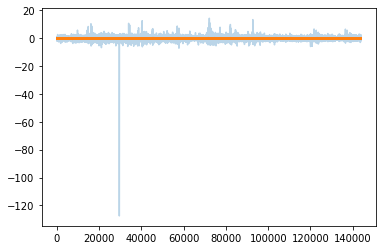

Epoch[6/10] | loss train:5176.606834, val loss:3926.913152 | lr:0.001000 | r2: 0.01782|
[ 0.06565793  0.44467348  0.13415909 ...  0.02729548  0.01104587
 -0.01461151]
[ 0.71356046  0.44878182 -0.40968573 ... -0.5781038  -0.7498187
 -0.37806404]


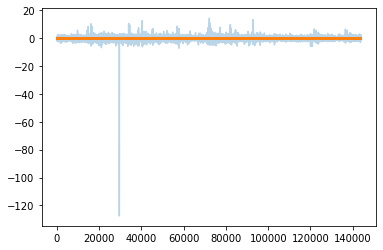

Epoch[7/10] | loss train:5166.072814, val loss:3928.061200 | lr:0.001000 | r2: 0.01753|
[0.062615   0.43577585 0.18130134 ... 0.05441243 0.00845259 0.00289324]
[ 0.71356046  0.44878182 -0.40968573 ... -0.5781038  -0.7498187
 -0.37806404]


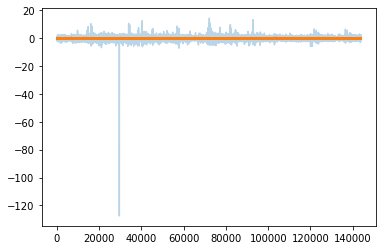

Epoch[8/10] | loss train:5157.180101, val loss:3935.926429 | lr:0.001000 | r2: 0.01556|
[-0.00614449  0.37589014  0.11396252 ...  0.0373084   0.01040407
 -0.00546017]
[ 0.71356046  0.44878182 -0.40968573 ... -0.5781038  -0.7498187
 -0.37806404]


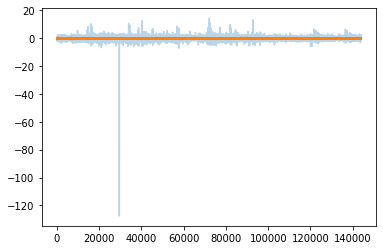

Epoch[9/10] | loss train:5143.468384, val loss:3940.830279 | lr:0.001000 | r2: 0.01434|
[ 0.0222998   0.43668994  0.11357634 ... -0.04200751 -0.00994206
  0.01585149]
[ 0.71356046  0.44878182 -0.40968573 ... -0.5781038  -0.7498187
 -0.37806404]


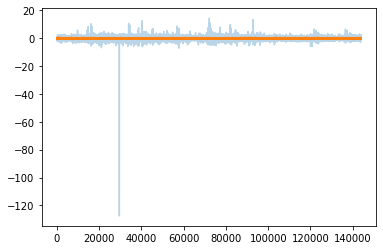

Epoch[10/10] | loss train:5128.554577, val loss:3944.110903 | lr:0.001000 | r2: 0.01352|
Train data shape (575913, 100, 42) (575913,)
Validation data shape (143979, 100, 42) (143979,)
[ 0.09085686  0.34903     0.102448   ... -0.00396593  0.01825619
 -0.01452402]
[ 0.41839522  0.00260205 -0.3825841  ... -0.5395378  -0.7002332
 -0.35306606]


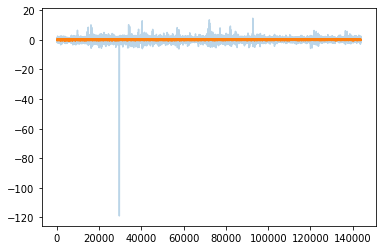

Epoch[1/10] | loss train:5286.471239, val loss:3929.749423 | lr:0.001000 | r2: 0.01343|
[ 0.07345187  0.37162644  0.10434384 ...  0.02060282  0.04517696
 -0.0013209 ]
[ 0.41839522  0.00260205 -0.3825841  ... -0.5395378  -0.7002332
 -0.35306606]


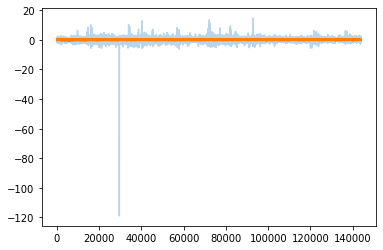

Epoch[2/10] | loss train:5255.576085, val loss:3924.547448 | lr:0.001000 | r2: 0.01473|
[0.05219287 0.38628364 0.11807597 ... 0.04160425 0.05382794 0.03403816]
[ 0.41839522  0.00260205 -0.3825841  ... -0.5395378  -0.7002332
 -0.35306606]


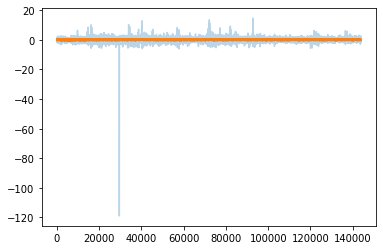

Epoch[3/10] | loss train:5245.273773, val loss:3922.616361 | lr:0.001000 | r2: 0.01522|
[0.09059351 0.4494885  0.10703725 ... 0.05732464 0.07172862 0.04606076]
[ 0.41839522  0.00260205 -0.3825841  ... -0.5395378  -0.7002332
 -0.35306606]


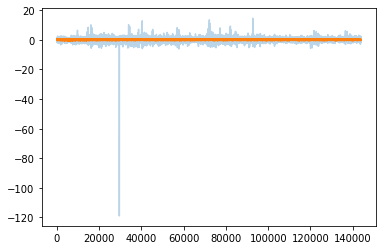

Epoch[4/10] | loss train:5236.074271, val loss:3920.038518 | lr:0.001000 | r2: 0.01586|
[0.05171579 0.39362723 0.12616697 ... 0.06658274 0.04692998 0.05322663]
[ 0.41839522  0.00260205 -0.3825841  ... -0.5395378  -0.7002332
 -0.35306606]


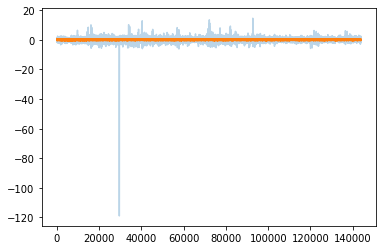

Epoch[5/10] | loss train:5227.361874, val loss:3920.383616 | lr:0.001000 | r2: 0.01578|
[0.08658278 0.4286157  0.14780389 ... 0.08857955 0.05082836 0.04106245]
[ 0.41839522  0.00260205 -0.3825841  ... -0.5395378  -0.7002332
 -0.35306606]


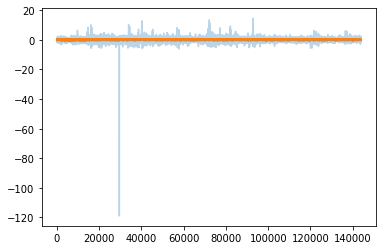

Epoch[6/10] | loss train:5220.980136, val loss:3920.238870 | lr:0.001000 | r2: 0.01581|
[0.06066621 0.4300003  0.06360279 ... 0.10150181 0.02843103 0.03755173]
[ 0.41839522  0.00260205 -0.3825841  ... -0.5395378  -0.7002332
 -0.35306606]


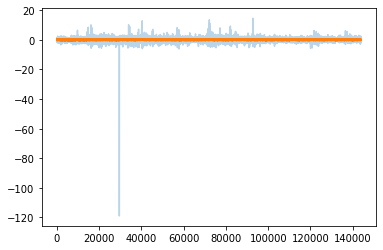

Epoch[7/10] | loss train:5210.584167, val loss:3922.242353 | lr:0.001000 | r2: 0.01531|
[0.03900974 0.39698732 0.16007456 ... 0.10603879 0.03636824 0.05112004]
[ 0.41839522  0.00260205 -0.3825841  ... -0.5395378  -0.7002332
 -0.35306606]


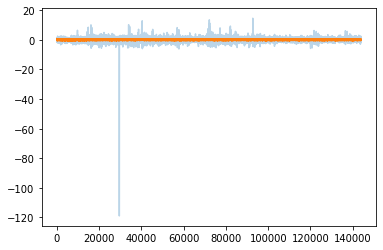

Epoch[8/10] | loss train:5201.190215, val loss:3923.908042 | lr:0.001000 | r2: 0.01489|
[0.02804029 0.42151845 0.15756068 ... 0.07552072 0.04440342 0.11355993]
[ 0.41839522  0.00260205 -0.3825841  ... -0.5395378  -0.7002332
 -0.35306606]


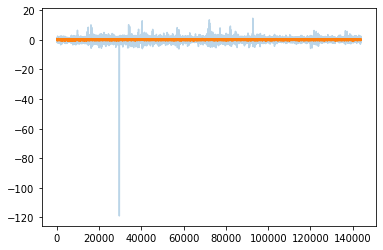

Epoch[9/10] | loss train:5188.661665, val loss:3925.398305 | lr:0.001000 | r2: 0.01452|
[0.05011094 0.44479504 0.09421511 ... 0.06069083 0.03561179 0.09432121]
[ 0.41839522  0.00260205 -0.3825841  ... -0.5395378  -0.7002332
 -0.35306606]


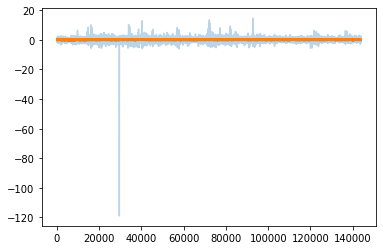

Epoch[10/10] | loss train:5175.025516, val loss:3928.940658 | lr:0.001000 | r2: 0.01363|
Train data shape (575912, 100, 42) (575912,)
Validation data shape (143979, 100, 42) (143979,)
[ 0.11024036  0.3401297   0.09726442 ...  0.02894758 -0.00676844
 -0.05599172]
[ 0.00176978  0.00246962 -0.36018497 ... -0.50788766 -0.65917635
 -0.33236843]


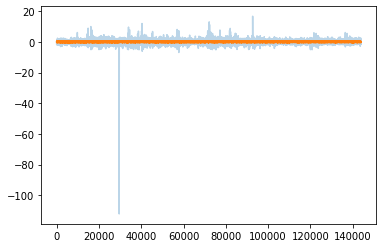

Epoch[1/10] | loss train:5309.399696, val loss:3918.911012 | lr:0.001000 | r2: 0.01179|
[ 0.12181956  0.34287652  0.07537394 ...  0.0349303   0.00069933
 -0.0379511 ]
[ 0.00176978  0.00246962 -0.36018497 ... -0.50788766 -0.65917635
 -0.33236843]


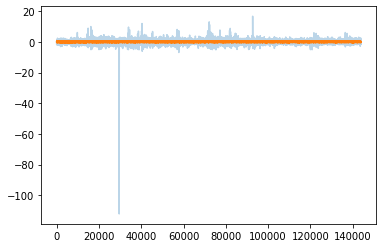

Epoch[2/10] | loss train:5279.530608, val loss:3914.280416 | lr:0.001000 | r2: 0.01295|
[ 0.09252148  0.40084362  0.09417788 ...  0.02988068  0.01922515
 -0.01029602]
[ 0.00176978  0.00246962 -0.36018497 ... -0.50788766 -0.65917635
 -0.33236843]


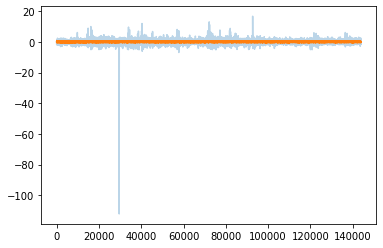

Epoch[3/10] | loss train:5268.797350, val loss:3912.261622 | lr:0.001000 | r2: 0.01346|
[0.08726627 0.3949246  0.10952379 ... 0.02878496 0.02107501 0.01462957]
[ 0.00176978  0.00246962 -0.36018497 ... -0.50788766 -0.65917635
 -0.33236843]


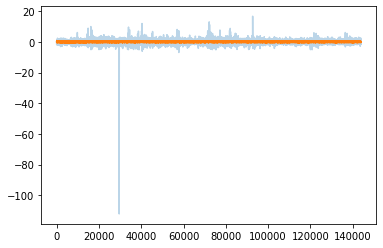

Epoch[4/10] | loss train:5261.660202, val loss:3912.961620 | lr:0.001000 | r2: 0.01328|
[0.0919341  0.406049   0.12023068 ... 0.04809334 0.02174421 0.03560558]
[ 0.00176978  0.00246962 -0.36018497 ... -0.50788766 -0.65917635
 -0.33236843]


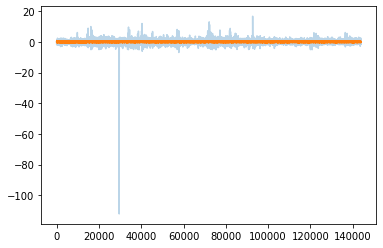

Epoch[5/10] | loss train:5254.608083, val loss:3912.938972 | lr:0.001000 | r2: 0.01329|
[0.0784459  0.41309974 0.08938484 ... 0.0338037  0.04284431 0.03564622]
[ 0.00176978  0.00246962 -0.36018497 ... -0.50788766 -0.65917635
 -0.33236843]


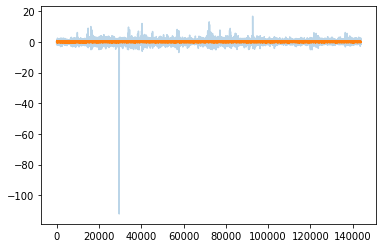

Epoch[6/10] | loss train:5247.630909, val loss:3913.647530 | lr:0.001000 | r2: 0.01311|
[0.11626762 0.42055985 0.12856108 ... 0.05717542 0.08628424 0.10638747]
[ 0.00176978  0.00246962 -0.36018497 ... -0.50788766 -0.65917635
 -0.33236843]


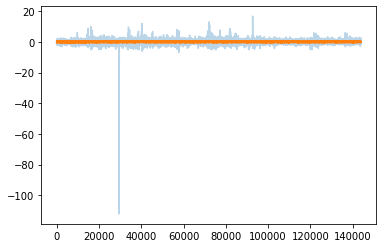

Epoch[7/10] | loss train:5240.264704, val loss:3915.264690 | lr:0.001000 | r2: 0.01270|
[0.07337397 0.37228122 0.13220492 ... 0.05488074 0.06042908 0.10173382]
[ 0.00176978  0.00246962 -0.36018497 ... -0.50788766 -0.65917635
 -0.33236843]


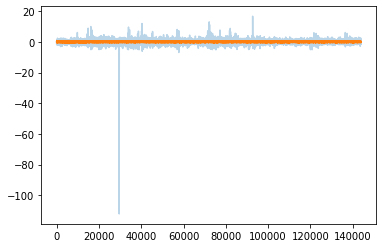

Epoch[8/10] | loss train:5233.686813, val loss:3914.311991 | lr:0.001000 | r2: 0.01294|
[0.04696567 0.38651174 0.07762121 ... 0.03097196 0.05936238 0.10800248]
[ 0.00176978  0.00246962 -0.36018497 ... -0.50788766 -0.65917635
 -0.33236843]


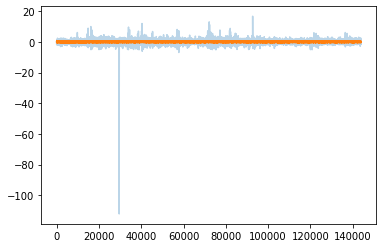

Epoch[9/10] | loss train:5222.334251, val loss:3917.523110 | lr:0.001000 | r2: 0.01213|
[0.08751551 0.38422984 0.11630867 ... 0.13752867 0.15874356 0.17564158]
[ 0.00176978  0.00246962 -0.36018497 ... -0.50788766 -0.65917635
 -0.33236843]


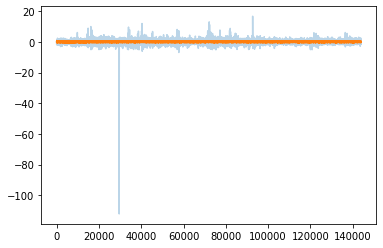

Epoch[10/10] | loss train:5205.916434, val loss:3916.727660 | lr:0.001000 | r2: 0.01233|
Train data shape (575912, 100, 42) (575912,)
Validation data shape (143978, 100, 42) (143978,)
[ 0.3698      0.07920302  0.30955058 ...  0.0029606  -0.00550995
 -0.04055641]
[ 0.00231215 -0.6266809  -1.0749826  ... -0.48112655 -0.6244528
 -0.31486022]


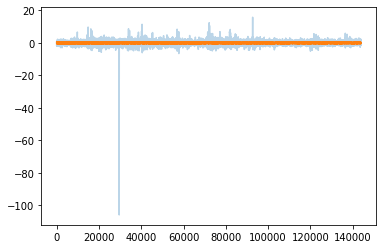

Epoch[1/10] | loss train:5321.975557, val loss:3908.358507 | lr:0.001000 | r2: 0.01061|
[0.36327374 0.09909166 0.28454417 ... 0.0244755  0.01186099 0.01217017]
[ 0.00231215 -0.6266809  -1.0749826  ... -0.48112655 -0.6244528
 -0.31486022]


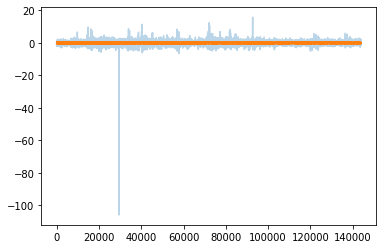

Epoch[2/10] | loss train:5295.648797, val loss:3905.388555 | lr:0.001000 | r2: 0.01136|
[ 0.36919832  0.07503144  0.28081533 ...  0.00865361 -0.02406413
  0.0095611 ]
[ 0.00231215 -0.6266809  -1.0749826  ... -0.48112655 -0.6244528
 -0.31486022]


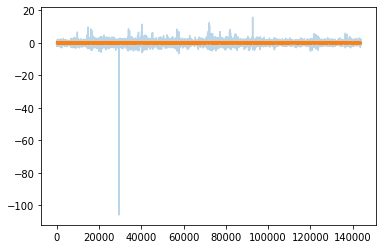

Epoch[3/10] | loss train:5286.086030, val loss:3903.873937 | lr:0.001000 | r2: 0.01175|
[ 0.40544397  0.07683179  0.28657234 ...  0.04469362 -0.01239608
  0.02356198]
[ 0.00231215 -0.6266809  -1.0749826  ... -0.48112655 -0.6244528
 -0.31486022]


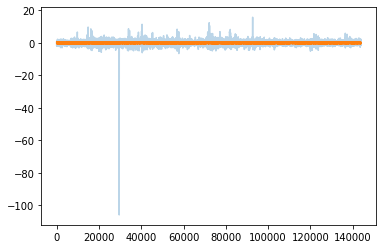

Epoch[4/10] | loss train:5280.030691, val loss:3902.221751 | lr:0.001000 | r2: 0.01216|
[0.39070657 0.10250176 0.2872567  ... 0.04683229 0.00148312 0.02541094]
[ 0.00231215 -0.6266809  -1.0749826  ... -0.48112655 -0.6244528
 -0.31486022]


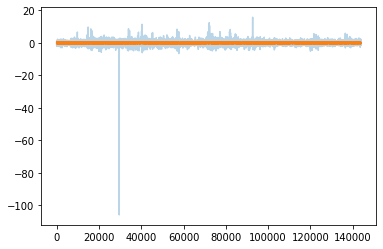

Epoch[5/10] | loss train:5274.459525, val loss:3902.030992 | lr:0.001000 | r2: 0.01221|
[0.3914956  0.0855959  0.27461895 ... 0.07924359 0.02104831 0.04712706]
[ 0.00231215 -0.6266809  -1.0749826  ... -0.48112655 -0.6244528
 -0.31486022]


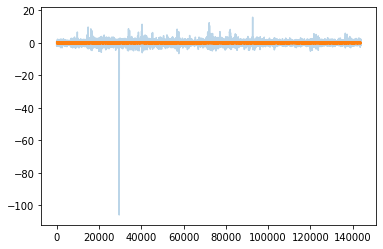

Epoch[6/10] | loss train:5268.426168, val loss:3900.824087 | lr:0.001000 | r2: 0.01252|
[0.3972685  0.08973707 0.2875488  ... 0.06745279 0.04691331 0.0765007 ]
[ 0.00231215 -0.6266809  -1.0749826  ... -0.48112655 -0.6244528
 -0.31486022]


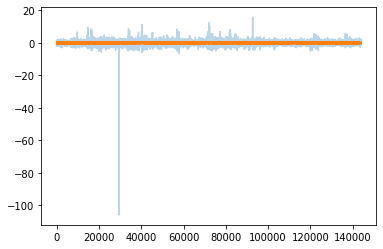

Epoch[7/10] | loss train:5260.223486, val loss:3904.415615 | lr:0.001000 | r2: 0.01161|
[0.4274345  0.11908698 0.32925108 ... 0.10033634 0.05914939 0.11148617]
[ 0.00231215 -0.6266809  -1.0749826  ... -0.48112655 -0.6244528
 -0.31486022]


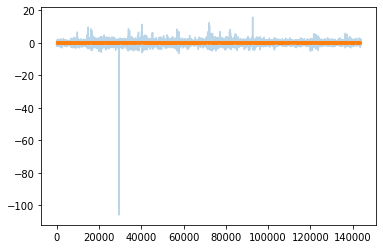

Epoch[8/10] | loss train:5252.824889, val loss:3902.691320 | lr:0.001000 | r2: 0.01204|
[0.42053303 0.1544165  0.34621906 ... 0.1009047  0.05810901 0.11234191]
[ 0.00231215 -0.6266809  -1.0749826  ... -0.48112655 -0.6244528
 -0.31486022]


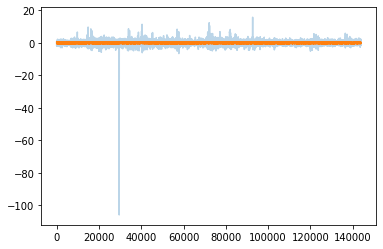

Epoch[9/10] | loss train:5243.161964, val loss:3904.931339 | lr:0.001000 | r2: 0.01148|
[0.3503343  0.04906287 0.3016287  ... 0.08480385 0.05968332 0.12825839]
[ 0.00231215 -0.6266809  -1.0749826  ... -0.48112655 -0.6244528
 -0.31486022]


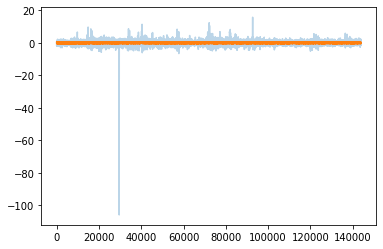

Epoch[10/10] | loss train:5234.286652, val loss:3908.253013 | lr:0.001000 | r2: 0.01064|
Train data shape (575911, 100, 42) (575911,)
Validation data shape (143978, 100, 42) (143978,)
[ 0.37545878  0.11163445  0.31367666 ...  0.00957103  0.01826296
 -0.03014059]
[-0.26961216 -1.0238992  -1.0232465  ... -0.45811132 -0.5945814
 -0.29980543]


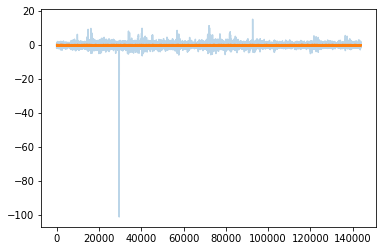

Epoch[1/10] | loss train:5338.417074, val loss:3901.515403 | lr:0.001000 | r2: 0.00987|
[ 0.34239647  0.15769686  0.23761788 ...  0.04362806  0.04770035
 -0.04256187]
[-0.26961216 -1.0238992  -1.0232465  ... -0.45811132 -0.5945814
 -0.29980543]


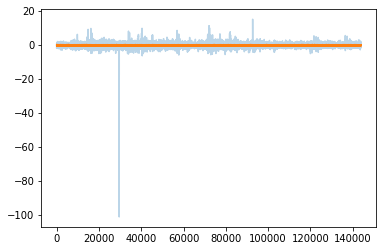

Epoch[2/10] | loss train:5310.647880, val loss:3897.559797 | lr:0.001000 | r2: 0.01087|
[ 0.38088164  0.17070429  0.29042143 ...  0.05615053  0.03813294
 -0.03785448]
[-0.26961216 -1.0238992  -1.0232465  ... -0.45811132 -0.5945814
 -0.29980543]


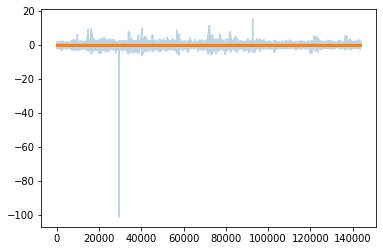

Epoch[3/10] | loss train:5302.186635, val loss:3896.143955 | lr:0.001000 | r2: 0.01123|
[ 0.3251522   0.16877267  0.24089283 ...  0.03292644  0.03440552
 -0.0407177 ]
[-0.26961216 -1.0238992  -1.0232465  ... -0.45811132 -0.5945814
 -0.29980543]


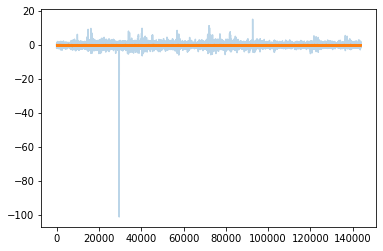

Epoch[4/10] | loss train:5295.743749, val loss:3897.107770 | lr:0.001000 | r2: 0.01098|
[ 0.3623992   0.15044658  0.2297857  ...  0.05082441  0.04432097
 -0.02639732]
[-0.26961216 -1.0238992  -1.0232465  ... -0.45811132 -0.5945814
 -0.29980543]


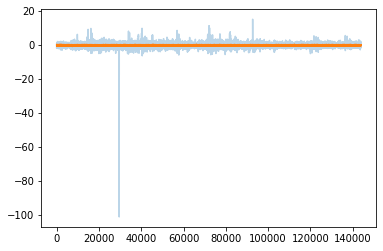

Epoch[5/10] | loss train:5291.181330, val loss:3896.663155 | lr:0.001000 | r2: 0.01109|
[ 0.35487422  0.11709283  0.22210993 ...  0.0635059   0.03961323
 -0.02513545]
[-0.26961216 -1.0238992  -1.0232465  ... -0.45811132 -0.5945814
 -0.29980543]


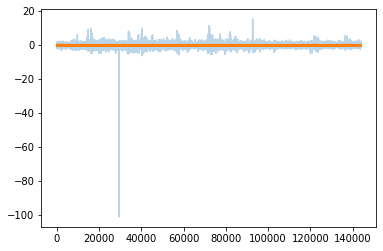

Epoch[6/10] | loss train:5285.684479, val loss:3897.427969 | lr:0.001000 | r2: 0.01090|
[ 0.35202336  0.12791122  0.23629196 ...  0.0863319   0.01568761
 -0.00571522]
[-0.26961216 -1.0238992  -1.0232465  ... -0.45811132 -0.5945814
 -0.29980543]


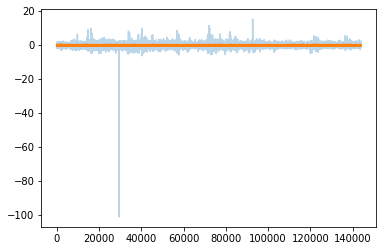

Epoch[7/10] | loss train:5278.187849, val loss:3897.844454 | lr:0.001000 | r2: 0.01079|
[0.3138451  0.09543542 0.18177469 ... 0.12673612 0.06100711 0.01842622]
[-0.26961216 -1.0238992  -1.0232465  ... -0.45811132 -0.5945814
 -0.29980543]


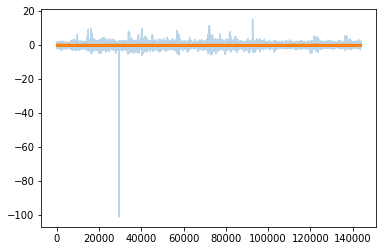

Epoch[8/10] | loss train:5271.938014, val loss:3899.418663 | lr:0.001000 | r2: 0.01040|
[0.36974314 0.10765111 0.2223063  ... 0.16576405 0.07648645 0.10442083]
[-0.26961216 -1.0238992  -1.0232465  ... -0.45811132 -0.5945814
 -0.29980543]


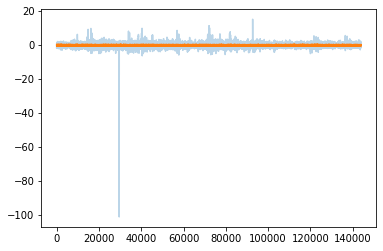

Epoch[9/10] | loss train:5258.892349, val loss:3902.112958 | lr:0.001000 | r2: 0.00971|
[0.35505596 0.13885185 0.24318284 ... 0.1711794  0.12186843 0.11393867]
[-0.26961216 -1.0238992  -1.0232465  ... -0.45811132 -0.5945814
 -0.29980543]


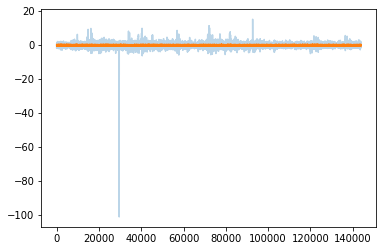

Epoch[10/10] | loss train:5246.234842, val loss:3904.554685 | lr:0.001000 | r2: 0.00910|
Train data shape (575910, 100, 42) (575910,)
Validation data shape (143978, 100, 42) (143978,)
[ 0.35157835  0.07650536  0.29914755 ... -0.00635352 -0.04341392
 -0.05975596]
[-0.66627616 -0.97873527 -0.9784357  ... -0.4380381  -0.56853503
 -0.2872875 ]


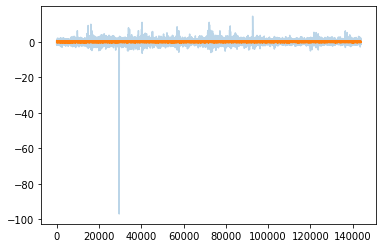

Epoch[1/10] | loss train:5351.554014, val loss:3891.862179 | lr:0.001000 | r2: 0.01014|
[ 0.3320764   0.06607234  0.26909727 ...  0.01089556 -0.02469152
 -0.02123538]
[-0.66627616 -0.97873527 -0.9784357  ... -0.4380381  -0.56853503
 -0.2872875 ]


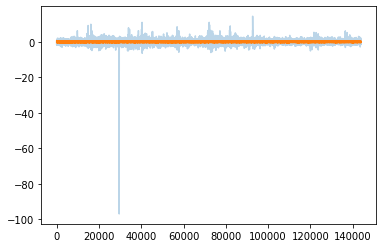

Epoch[2/10] | loss train:5327.048435, val loss:3890.265750 | lr:0.001000 | r2: 0.01054|
[ 0.3466841   0.06477464  0.27820605 ...  0.03035938 -0.01018533
 -0.03961637]
[-0.66627616 -0.97873527 -0.9784357  ... -0.4380381  -0.56853503
 -0.2872875 ]


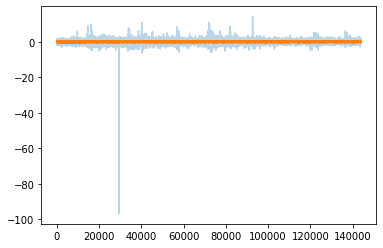

Epoch[3/10] | loss train:5320.242410, val loss:3889.270395 | lr:0.001000 | r2: 0.01079|
[ 0.37383303  0.05863659  0.25555348 ...  0.03484843  0.01913418
 -0.02012335]
[-0.66627616 -0.97873527 -0.9784357  ... -0.4380381  -0.56853503
 -0.2872875 ]


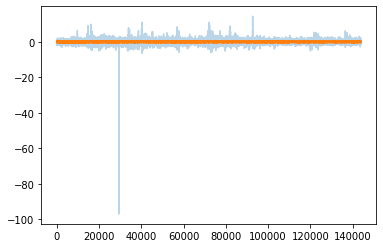

Epoch[4/10] | loss train:5313.537157, val loss:3888.907880 | lr:0.001000 | r2: 0.01089|
[ 0.36081725  0.03793868  0.25024337 ...  0.04101051  0.02519793
 -0.0206548 ]
[-0.66627616 -0.97873527 -0.9784357  ... -0.4380381  -0.56853503
 -0.2872875 ]


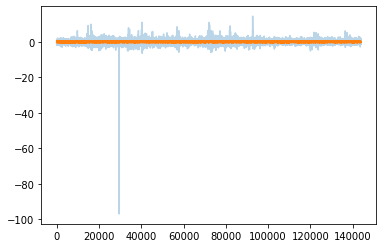

Epoch[5/10] | loss train:5308.656394, val loss:3888.440833 | lr:0.001000 | r2: 0.01100|
[ 0.41267574  0.02639586  0.2300922  ...  0.03526856  0.03351641
 -0.01112116]
[-0.66627616 -0.97873527 -0.9784357  ... -0.4380381  -0.56853503
 -0.2872875 ]


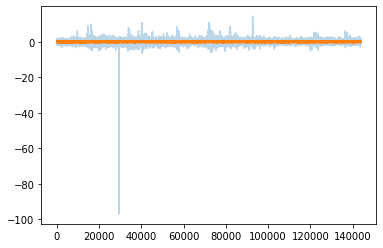

Epoch[6/10] | loss train:5303.998526, val loss:3888.818068 | lr:0.001000 | r2: 0.01091|
[ 0.43088722  0.05658692  0.24375756 ...  0.05294682  0.02426986
 -0.02764366]
[-0.66627616 -0.97873527 -0.9784357  ... -0.4380381  -0.56853503
 -0.2872875 ]


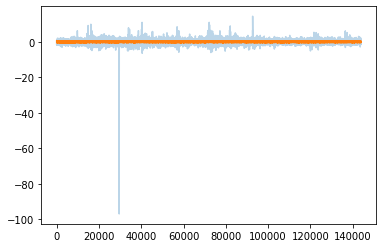

Epoch[7/10] | loss train:5300.553860, val loss:3887.841676 | lr:0.001000 | r2: 0.01116|
[ 0.4135184   0.09082181  0.21378744 ...  0.06382113  0.02147661
 -0.02921912]
[-0.66627616 -0.97873527 -0.9784357  ... -0.4380381  -0.56853503
 -0.2872875 ]


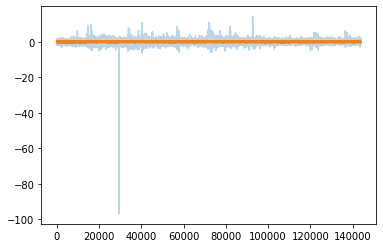

Epoch[8/10] | loss train:5294.700958, val loss:3888.615281 | lr:0.001000 | r2: 0.01096|
[ 0.40789482  0.07816303  0.26204237 ...  0.08337882  0.02238877
 -0.04240469]
[-0.66627616 -0.97873527 -0.9784357  ... -0.4380381  -0.56853503
 -0.2872875 ]


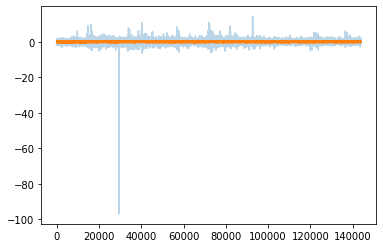

Epoch[9/10] | loss train:5285.722210, val loss:3890.140294 | lr:0.001000 | r2: 0.01058|
[0.4961985  0.14278121 0.30662042 ... 0.08961879 0.05199886 0.02804437]
[-0.66627616 -0.97873527 -0.9784357  ... -0.4380381  -0.56853503
 -0.2872875 ]


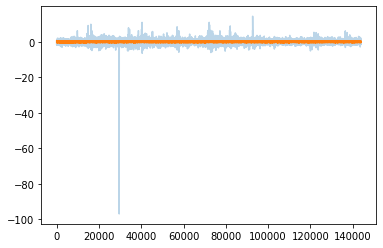

Epoch[10/10] | loss train:5274.986760, val loss:3891.647367 | lr:0.001000 | r2: 0.01019|
Train data shape (575909, 100, 42) (575909,)
Validation data shape (143978, 100, 42) (143978,)
[ 0.33356997  0.05937375  0.2655473  ...  0.00160451 -0.03604217
 -0.05303834]
[-0.6390531  -0.9391917  -1.1133934  ... -0.4203357  -0.5461444
 -0.32579672]


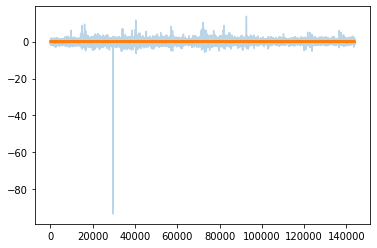

Epoch[1/10] | loss train:5369.191497, val loss:3889.995451 | lr:0.001000 | r2: 0.00962|
[ 0.2941494   0.06964441  0.22251366 ...  0.00182844 -0.02410246
 -0.02873134]
[-0.6390531  -0.9391917  -1.1133934  ... -0.4203357  -0.5461444
 -0.32579672]


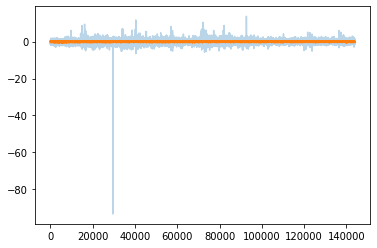

Epoch[2/10] | loss train:5344.904104, val loss:3888.083726 | lr:0.001000 | r2: 0.01011|
[ 0.33738717  0.06417832  0.21991128 ...  0.01850765 -0.00422232
 -0.00232021]
[-0.6390531  -0.9391917  -1.1133934  ... -0.4203357  -0.5461444
 -0.32579672]


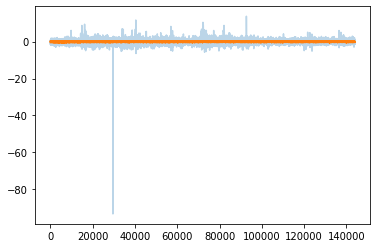

Epoch[3/10] | loss train:5336.696656, val loss:3886.364764 | lr:0.001000 | r2: 0.01054|
[0.34774852 0.06068099 0.20286974 ... 0.02093321 0.01344388 0.01182533]
[-0.6390531  -0.9391917  -1.1133934  ... -0.4203357  -0.5461444
 -0.32579672]


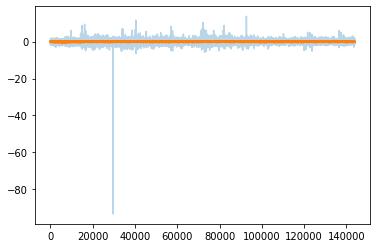

Epoch[4/10] | loss train:5331.460849, val loss:3886.471904 | lr:0.001000 | r2: 0.01051|
[0.37547025 0.13213763 0.24381216 ... 0.0343258  0.02388006 0.00320753]
[-0.6390531  -0.9391917  -1.1133934  ... -0.4203357  -0.5461444
 -0.32579672]


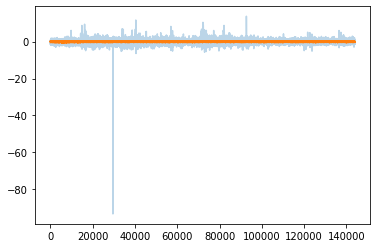

Epoch[5/10] | loss train:5326.597474, val loss:3887.125205 | lr:0.001000 | r2: 0.01035|
[0.3451124  0.09800877 0.19842863 ... 0.05580029 0.02172006 0.01199445]
[-0.6390531  -0.9391917  -1.1133934  ... -0.4203357  -0.5461444
 -0.32579672]


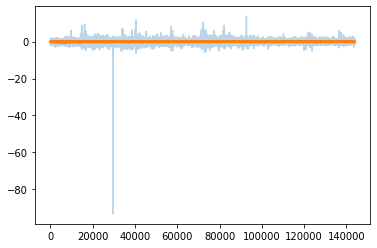

Epoch[6/10] | loss train:5322.591762, val loss:3886.536177 | lr:0.001000 | r2: 0.01050|
[0.3470851  0.13911322 0.2600117  ... 0.05472859 0.0369241  0.01159598]
[-0.6390531  -0.9391917  -1.1133934  ... -0.4203357  -0.5461444
 -0.32579672]


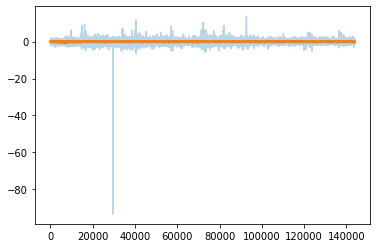

Epoch[7/10] | loss train:5317.327722, val loss:3885.293923 | lr:0.001000 | r2: 0.01081|
[0.34272784 0.14522897 0.28069562 ... 0.04814207 0.06620411 0.05494848]
[-0.6390531  -0.9391917  -1.1133934  ... -0.4203357  -0.5461444
 -0.32579672]


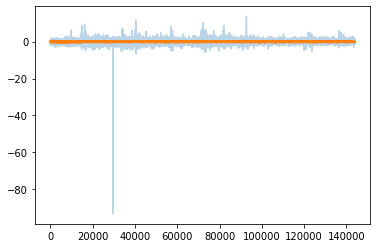

Epoch[8/10] | loss train:5311.247900, val loss:3886.322701 | lr:0.001000 | r2: 0.01055|
[0.34558558 0.14966154 0.31957543 ... 0.03392083 0.02193501 0.0577973 ]
[-0.6390531  -0.9391917  -1.1133934  ... -0.4203357  -0.5461444
 -0.32579672]


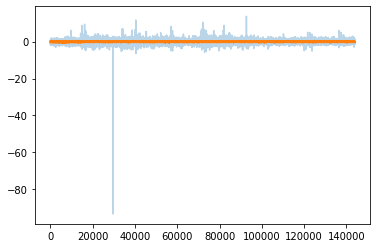

Epoch[9/10] | loss train:5301.269854, val loss:3885.907839 | lr:0.001000 | r2: 0.01065|
[0.39778122 0.22135492 0.34526166 ... 0.04002424 0.03689764 0.0778995 ]
[-0.6390531  -0.9391917  -1.1133934  ... -0.4203357  -0.5461444
 -0.32579672]


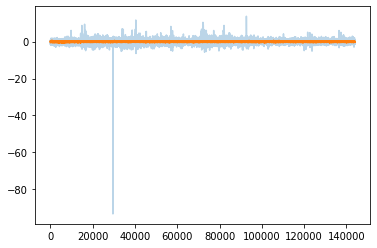

Epoch[10/10] | loss train:5290.093238, val loss:3889.270956 | lr:0.001000 | r2: 0.00980|
Train data shape (575908, 100, 42) (575908,)
Validation data shape (143978, 100, 42) (143978,)
[ 0.3012523   0.03512251  0.26039988 ... -0.00282203 -0.01857634
 -0.07797478]
[-0.61509323 -1.0719087  -1.3598049  ... -0.40513238 -0.57389057
 -0.31370795]


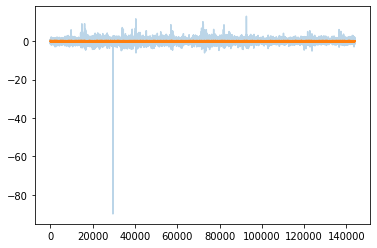

Epoch[1/10] | loss train:5382.244182, val loss:3888.483368 | lr:0.001000 | r2: 0.00921|
[ 0.28689885  0.06412198  0.22580287 ...  0.02011439 -0.02176923
 -0.06868052]
[-0.61509323 -1.0719087  -1.3598049  ... -0.40513238 -0.57389057
 -0.31370795]


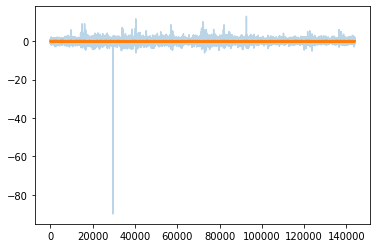

Epoch[2/10] | loss train:5359.378086, val loss:3887.008269 | lr:0.001000 | r2: 0.00958|
[ 0.2682155   0.04024757  0.22939402 ...  0.04151034  0.01579874
 -0.04129672]
[-0.61509323 -1.0719087  -1.3598049  ... -0.40513238 -0.57389057
 -0.31370795]


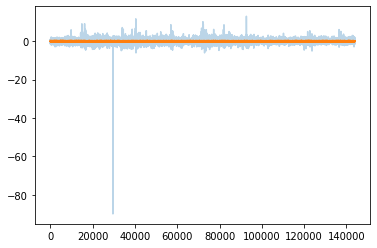

Epoch[3/10] | loss train:5350.675320, val loss:3886.595293 | lr:0.001000 | r2: 0.00969|
[ 0.30697274  0.04236409  0.23306169 ...  0.04260772  0.0383103
 -0.02447734]
[-0.61509323 -1.0719087  -1.3598049  ... -0.40513238 -0.57389057
 -0.31370795]


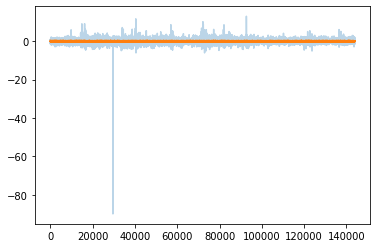

Epoch[4/10] | loss train:5346.855791, val loss:3885.524300 | lr:0.001000 | r2: 0.00996|
[ 0.28872174  0.05222829  0.2108594  ...  0.0378253   0.04294633
 -0.01433153]
[-0.61509323 -1.0719087  -1.3598049  ... -0.40513238 -0.57389057
 -0.31370795]


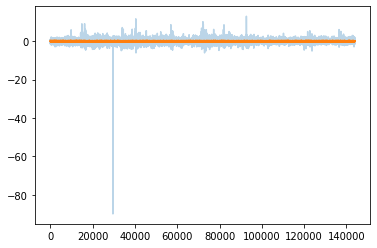

Epoch[5/10] | loss train:5342.965739, val loss:3885.847479 | lr:0.001000 | r2: 0.00988|
[0.3214613  0.04762227 0.21500139 ... 0.06492457 0.07008791 0.01286417]
[-0.61509323 -1.0719087  -1.3598049  ... -0.40513238 -0.57389057
 -0.31370795]


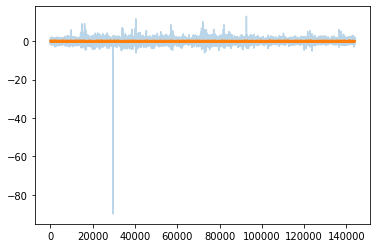

Epoch[6/10] | loss train:5338.350161, val loss:3886.423925 | lr:0.001000 | r2: 0.00973|
[ 0.36554438  0.0517213   0.21820314 ...  0.07460946  0.05745939
 -0.00061395]
[-0.61509323 -1.0719087  -1.3598049  ... -0.40513238 -0.57389057
 -0.31370795]


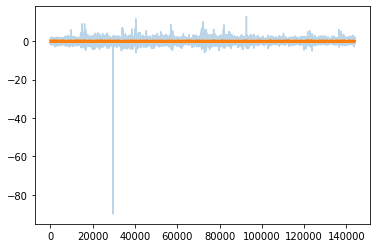

Epoch[7/10] | loss train:5334.493736, val loss:3883.886870 | lr:0.001000 | r2: 0.01038|
[ 0.33264554  0.07201482  0.25185674 ...  0.05558278  0.04418221
 -0.01624273]
[-0.61509323 -1.0719087  -1.3598049  ... -0.40513238 -0.57389057
 -0.31370795]


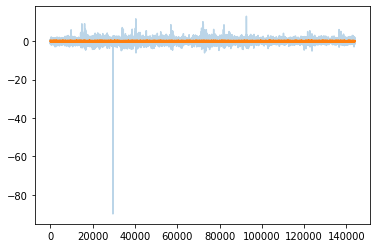

Epoch[8/10] | loss train:5327.281922, val loss:3884.874918 | lr:0.001000 | r2: 0.01013|
[0.3570498  0.09806781 0.29428124 ... 0.08427645 0.07545076 0.00581557]
[-0.61509323 -1.0719087  -1.3598049  ... -0.40513238 -0.57389057
 -0.31370795]


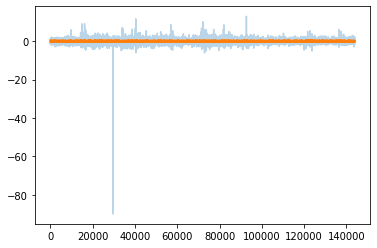

Epoch[9/10] | loss train:5320.783930, val loss:3884.061446 | lr:0.001000 | r2: 0.01033|
[ 0.39414203  0.09329834  0.27576053 ...  0.06308807  0.09692183
 -0.01441439]
[-0.61509323 -1.0719087  -1.3598049  ... -0.40513238 -0.57389057
 -0.31370795]


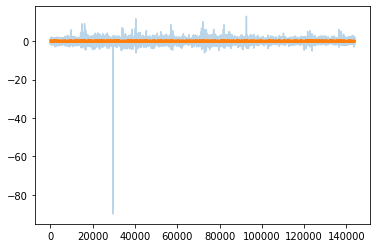

Epoch[10/10] | loss train:5312.465614, val loss:3886.369539 | lr:0.001000 | r2: 0.00975|
Train data shape (575908, 100, 42) (575908,)
Validation data shape (143977, 100, 42) (143977,)
[ 0.05088857  0.23882897 -0.00547531 ... -0.00105388 -0.00378606
 -0.07226257]
[-1.3124706  -1.3122586  -1.3362446  ... -0.43749654 -0.5539248
 -0.30322158]


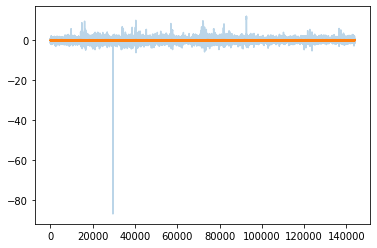

Epoch[1/10] | loss train:5395.662984, val loss:3888.767371 | lr:0.001000 | r2: 0.00910|
[ 0.06343401  0.2468144   0.00660523 ...  0.00688364  0.01135691
 -0.05729626]
[-1.3124706  -1.3122586  -1.3362446  ... -0.43749654 -0.5539248
 -0.30322158]


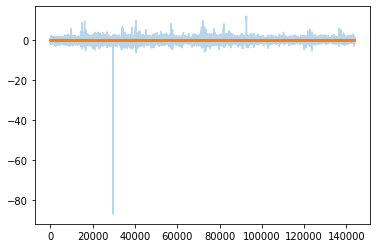

Epoch[2/10] | loss train:5372.271752, val loss:3886.611514 | lr:0.001000 | r2: 0.00965|
[ 0.06986561  0.25016406  0.02088631 ...  0.01517414  0.00983812
 -0.03038994]
[-1.3124706  -1.3122586  -1.3362446  ... -0.43749654 -0.5539248
 -0.30322158]


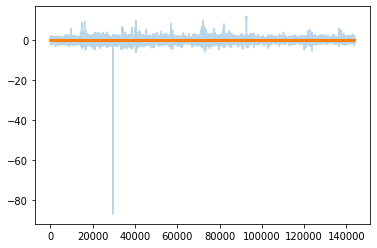

Epoch[3/10] | loss train:5366.203646, val loss:3886.299040 | lr:0.001000 | r2: 0.00973|
[ 0.04257536  0.22705641 -0.00483073 ...  0.01622931  0.03215594
 -0.01792864]
[-1.3124706  -1.3122586  -1.3362446  ... -0.43749654 -0.5539248
 -0.30322158]


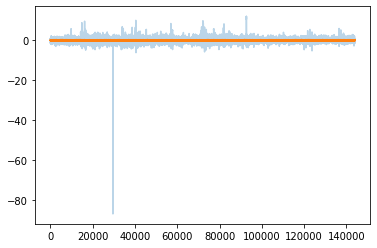

Epoch[4/10] | loss train:5361.564154, val loss:3886.526251 | lr:0.001000 | r2: 0.00967|
[ 0.04026821  0.22103554  0.02140857 ...  0.01341909  0.03135744
 -0.01551467]
[-1.3124706  -1.3122586  -1.3362446  ... -0.43749654 -0.5539248
 -0.30322158]


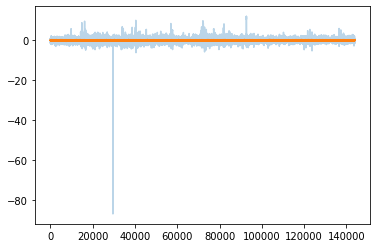

Epoch[5/10] | loss train:5358.292352, val loss:3885.668243 | lr:0.001000 | r2: 0.00989|
[ 0.08185881  0.24932085  0.06524671 ...  0.03902115  0.03760579
 -0.01477884]
[-1.3124706  -1.3122586  -1.3362446  ... -0.43749654 -0.5539248
 -0.30322158]


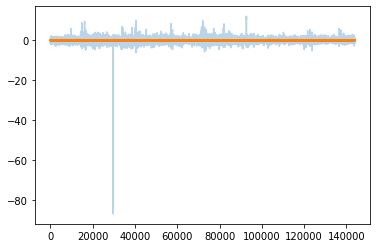

Epoch[6/10] | loss train:5354.324494, val loss:3886.050591 | lr:0.001000 | r2: 0.00979|
[0.0188603  0.23189276 0.01889382 ... 0.04547323 0.03520922 0.00297032]
[-1.3124706  -1.3122586  -1.3362446  ... -0.43749654 -0.5539248
 -0.30322158]


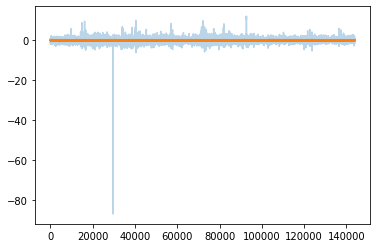

Epoch[7/10] | loss train:5350.636784, val loss:3887.124501 | lr:0.001000 | r2: 0.00952|
[ 0.06353199  0.23362464 -0.0144398  ...  0.03496757  0.03996246
 -0.02006414]
[-1.3124706  -1.3122586  -1.3362446  ... -0.43749654 -0.5539248
 -0.30322158]


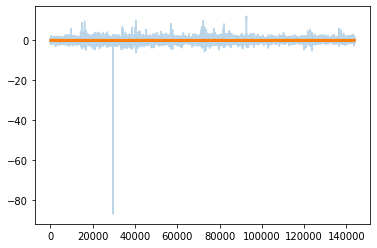

Epoch[8/10] | loss train:5346.566856, val loss:3887.472511 | lr:0.001000 | r2: 0.00943|
[ 0.07925272  0.27238795 -0.02713336 ...  0.06335479  0.05098655
 -0.02373758]
[-1.3124706  -1.3122586  -1.3362446  ... -0.43749654 -0.5539248
 -0.30322158]


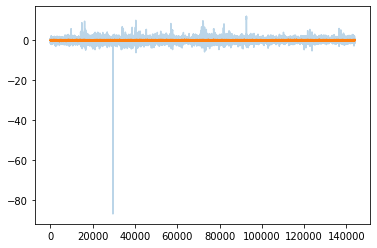

Epoch[9/10] | loss train:5341.067943, val loss:3890.139969 | lr:0.001000 | r2: 0.00875|
[ 0.13575728  0.27691272 -0.03276952 ...  0.06418639  0.04576785
 -0.00212222]
[-1.3124706  -1.3122586  -1.3362446  ... -0.43749654 -0.5539248
 -0.30322158]


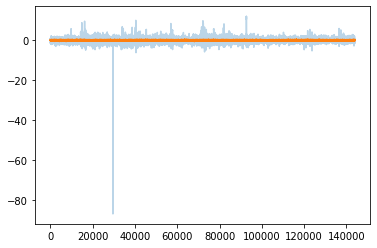

Epoch[10/10] | loss train:5328.878670, val loss:3891.160158 | lr:0.001000 | r2: 0.00849|
Train data shape (575907, 100, 42) (575907,)
Validation data shape (143977, 100, 42) (143977,)
[ 0.04071812  0.24014972 -0.01466101 ...  0.00615107 -0.0174233
 -0.07152267]
[-1.269453   -1.2692426  -1.2923642  ... -0.42326108 -0.5362218
 -0.29325578]


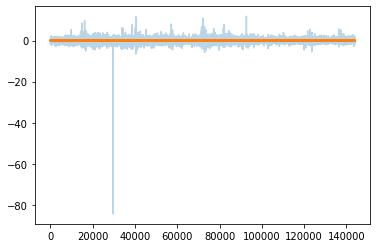

Epoch[1/10] | loss train:5410.199990, val loss:3893.794549 | lr:0.001000 | r2: 0.00830|
[ 0.05692172  0.24003851 -0.02533352 ...  0.00456155 -0.0026376
 -0.03656897]
[-1.269453   -1.2692426  -1.2923642  ... -0.42326108 -0.5362218
 -0.29325578]


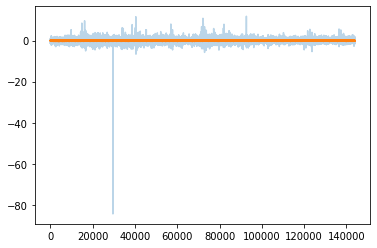

Epoch[2/10] | loss train:5387.222653, val loss:3891.866321 | lr:0.001000 | r2: 0.00879|
[ 0.0660504   0.23783614 -0.05024901 ...  0.01686882  0.01702162
 -0.03272293]
[-1.269453   -1.2692426  -1.2923642  ... -0.42326108 -0.5362218
 -0.29325578]


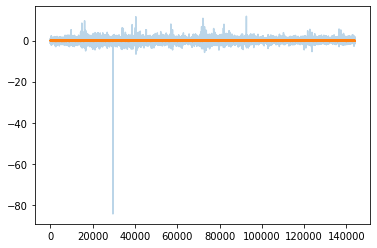

Epoch[3/10] | loss train:5382.288424, val loss:3890.616826 | lr:0.001000 | r2: 0.00911|
[ 0.06315688  0.24278183 -0.042652   ...  0.01511478  0.01855899
 -0.01967623]
[-1.269453   -1.2692426  -1.2923642  ... -0.42326108 -0.5362218
 -0.29325578]


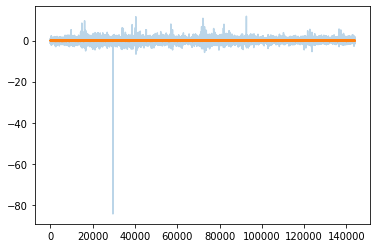

Epoch[4/10] | loss train:5376.946386, val loss:3890.120816 | lr:0.001000 | r2: 0.00923|
[ 0.03614147  0.262756   -0.04363091 ...  0.03430875  0.02894204
  0.02487743]
[-1.269453   -1.2692426  -1.2923642  ... -0.42326108 -0.5362218
 -0.29325578]


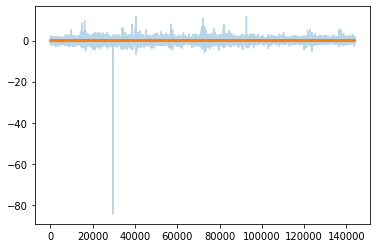

Epoch[5/10] | loss train:5373.882155, val loss:3889.405769 | lr:0.001000 | r2: 0.00942|
[ 0.0450908   0.29744986 -0.00978432 ...  0.03378791  0.04116807
  0.04357938]
[-1.269453   -1.2692426  -1.2923642  ... -0.42326108 -0.5362218
 -0.29325578]


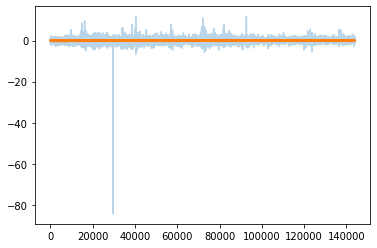

Epoch[6/10] | loss train:5371.102965, val loss:3888.690824 | lr:0.001000 | r2: 0.00960|
[ 0.07897119  0.28019673 -0.02295021 ... -0.00837846  0.01916387
  0.03577946]
[-1.269453   -1.2692426  -1.2923642  ... -0.42326108 -0.5362218
 -0.29325578]


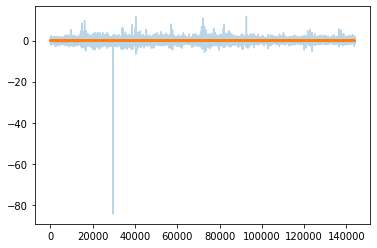

Epoch[7/10] | loss train:5366.543219, val loss:3889.952642 | lr:0.001000 | r2: 0.00928|
[0.10583808 0.31740803 0.00216384 ... 0.01083495 0.03433793 0.05452694]
[-1.269453   -1.2692426  -1.2923642  ... -0.42326108 -0.5362218
 -0.29325578]


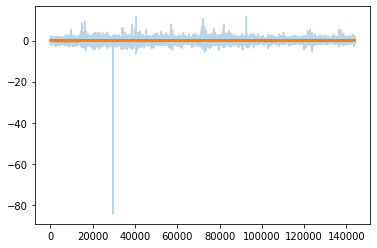

Epoch[8/10] | loss train:5360.849870, val loss:3889.183765 | lr:0.001000 | r2: 0.00947|
[ 0.02212037  0.22488569 -0.03832011 ...  0.00535621  0.02456884
 -0.00631588]
[-1.269453   -1.2692426  -1.2923642  ... -0.42326108 -0.5362218
 -0.29325578]


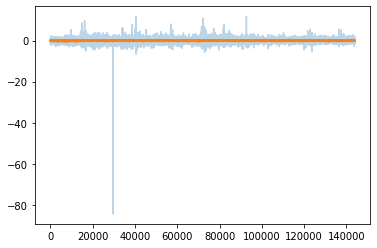

Epoch[9/10] | loss train:5354.613993, val loss:3893.761156 | lr:0.001000 | r2: 0.00831|
[0.09483218 0.26686728 0.01312351 ... 0.04912185 0.06889955 0.04321228]
[-1.269453   -1.2692426  -1.2923642  ... -0.42326108 -0.5362218
 -0.29325578]


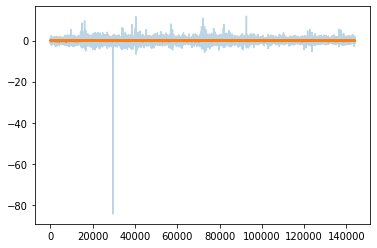

Epoch[10/10] | loss train:5346.018756, val loss:3890.505966 | lr:0.001000 | r2: 0.00914|
Train data shape (575906, 100, 42) (575906,)
Validation data shape (143977, 100, 42) (143977,)
[ 0.02483328  0.22166233 -0.0593353  ... -0.00777435  0.02818669
 -0.07430399]
[-1.2302892  -1.2300107  -1.2524427  ... -0.41064966 -0.51964056
 -0.38307318]


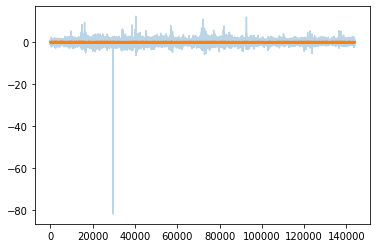

Epoch[1/10] | loss train:5426.050244, val loss:3897.829753 | lr:0.001000 | r2: 0.00784|
[ 0.02734254  0.2226161  -0.04436349 ...  0.00893204  0.03343172
 -0.06793109]
[-1.2302892  -1.2300107  -1.2524427  ... -0.41064966 -0.51964056
 -0.38307318]


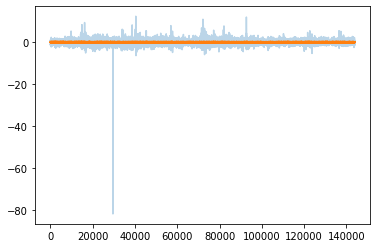

Epoch[2/10] | loss train:5402.562286, val loss:3895.370783 | lr:0.001000 | r2: 0.00847|
[ 0.04962924  0.23683502 -0.03261618 ...  0.00886305  0.03375904
 -0.05097245]
[-1.2302892  -1.2300107  -1.2524427  ... -0.41064966 -0.51964056
 -0.38307318]


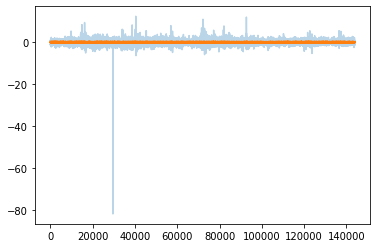

Epoch[3/10] | loss train:5396.516132, val loss:3893.409565 | lr:0.001000 | r2: 0.00897|
[ 0.03915679  0.25500646 -0.02023189 ...  0.02551101  0.03948765
 -0.03252065]
[-1.2302892  -1.2300107  -1.2524427  ... -0.41064966 -0.51964056
 -0.38307318]


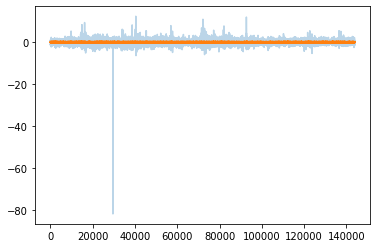

Epoch[4/10] | loss train:5393.305009, val loss:3892.252527 | lr:0.001000 | r2: 0.00926|
[ 0.06741264  0.24696843 -0.01146592 ...  0.01958361  0.05386919
 -0.0164255 ]
[-1.2302892  -1.2300107  -1.2524427  ... -0.41064966 -0.51964056
 -0.38307318]


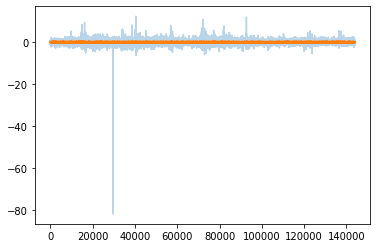

Epoch[5/10] | loss train:5391.928460, val loss:3892.246670 | lr:0.001000 | r2: 0.00926|
[ 0.07239114  0.25905544 -0.04565022 ...  0.05181985  0.0646818
 -0.0181495 ]
[-1.2302892  -1.2300107  -1.2524427  ... -0.41064966 -0.51964056
 -0.38307318]


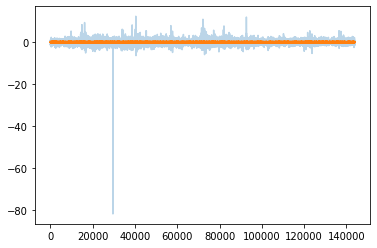

Epoch[6/10] | loss train:5389.193869, val loss:3892.337031 | lr:0.001000 | r2: 0.00924|
[ 0.05614261  0.19346346 -0.06321826 ...  0.04085377  0.04800187
 -0.05309998]
[-1.2302892  -1.2300107  -1.2524427  ... -0.41064966 -0.51964056
 -0.38307318]


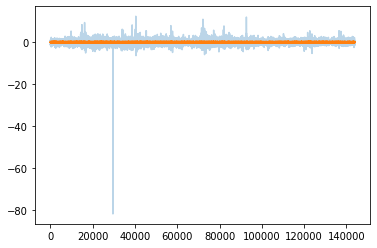

Epoch[7/10] | loss train:5386.503366, val loss:3892.463808 | lr:0.001000 | r2: 0.00921|
[ 0.04246994  0.22871083 -0.04808347 ...  0.05434444  0.06860445
 -0.02872607]
[-1.2302892  -1.2300107  -1.2524427  ... -0.41064966 -0.51964056
 -0.38307318]


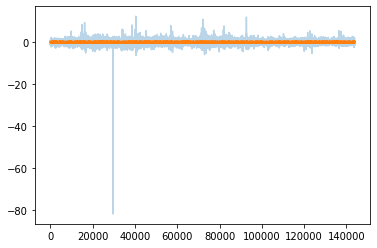

Epoch[8/10] | loss train:5381.256912, val loss:3892.690143 | lr:0.001000 | r2: 0.00915|
[ 0.07841173  0.2576175  -0.02244106 ...  0.06155589  0.07828644
 -0.02610252]
[-1.2302892  -1.2300107  -1.2524427  ... -0.41064966 -0.51964056
 -0.38307318]


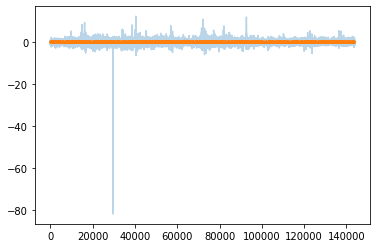

Epoch[9/10] | loss train:5376.397405, val loss:3897.012374 | lr:0.001000 | r2: 0.00805|
[-0.00338717  0.22879311 -0.08701335 ...  0.0275354   0.11210718
 -0.02682921]
[-1.2302892  -1.2300107  -1.2524427  ... -0.41064966 -0.51964056
 -0.38307318]


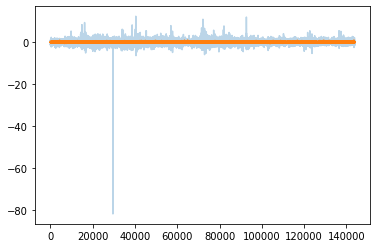

Epoch[10/10] | loss train:5374.439786, val loss:3905.594924 | lr:0.001000 | r2: 0.00587|
Train data shape (575905, 100, 42) (575905,)
Validation data shape (143977, 100, 42) (143977,)
[ 0.03086826  0.20876907 -0.00398838 ...  0.01052571  0.00075038
 -0.06614809]
[-1.194368   -1.1941221  -1.2158712  ... -0.3986526  -0.6004652
 -0.45374256]


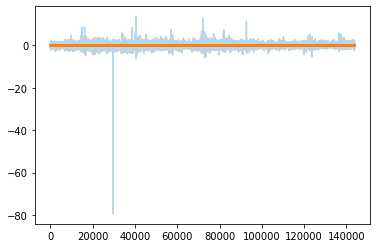

Epoch[1/10] | loss train:5442.295760, val loss:3901.133156 | lr:0.001000 | r2: 0.00764|
[ 0.06606823  0.23591304 -0.02009459 ...  0.03683197  0.01500339
 -0.05274935]
[-1.194368   -1.1941221  -1.2158712  ... -0.3986526  -0.6004652
 -0.45374256]


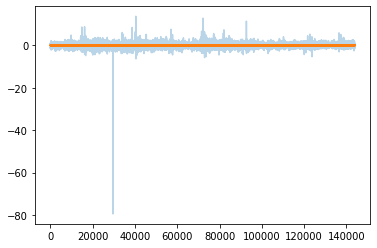

Epoch[2/10] | loss train:5418.615431, val loss:3897.746032 | lr:0.001000 | r2: 0.00850|
[ 0.05966954  0.24341968  0.0010808  ...  0.035528    0.03164959
 -0.04366303]
[-1.194368   -1.1941221  -1.2158712  ... -0.3986526  -0.6004652
 -0.45374256]


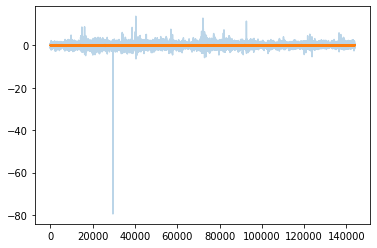

Epoch[3/10] | loss train:5413.233640, val loss:3898.255964 | lr:0.001000 | r2: 0.00837|
[ 0.06967148  0.20462345 -0.00451479 ...  0.02790489  0.051221
 -0.0315619 ]
[-1.194368   -1.1941221  -1.2158712  ... -0.3986526  -0.6004652
 -0.45374256]


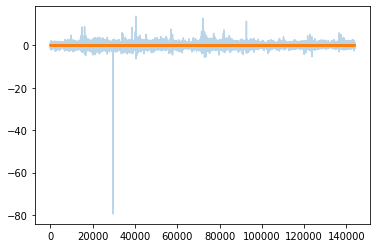

Epoch[4/10] | loss train:5409.286182, val loss:3897.758490 | lr:0.001000 | r2: 0.00849|
[ 0.03901124  0.21673271 -0.02471767 ...  0.01636823  0.03456471
 -0.00257253]
[-1.194368   -1.1941221  -1.2158712  ... -0.3986526  -0.6004652
 -0.45374256]


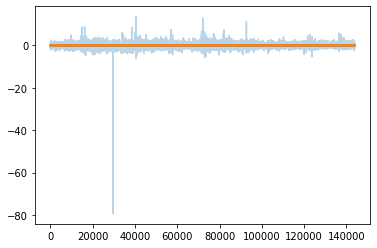

Epoch[5/10] | loss train:5405.771345, val loss:3897.763370 | lr:0.001000 | r2: 0.00849|
[0.08543424 0.18850423 0.02288191 ... 0.02184174 0.04036122 0.01442999]
[-1.194368   -1.1941221  -1.2158712  ... -0.3986526  -0.6004652
 -0.45374256]


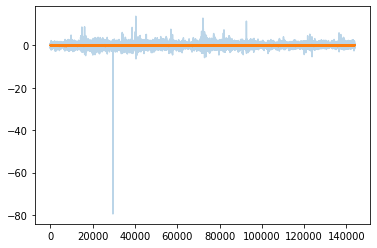

Epoch[6/10] | loss train:5404.552350, val loss:3897.625751 | lr:0.001000 | r2: 0.00853|
[ 0.040755    0.21406853 -0.03054433 ...  0.02464895  0.02390568
  0.01013592]
[-1.194368   -1.1941221  -1.2158712  ... -0.3986526  -0.6004652
 -0.45374256]


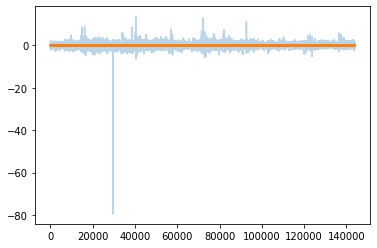

Epoch[7/10] | loss train:5400.852722, val loss:3898.355118 | lr:0.001000 | r2: 0.00834|
[ 0.06415105  0.21923889 -0.0020227  ... -0.00386526  0.01954334
  0.00147017]
[-1.194368   -1.1941221  -1.2158712  ... -0.3986526  -0.6004652
 -0.45374256]


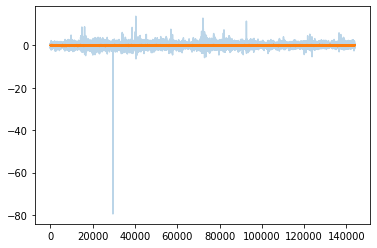

Epoch[8/10] | loss train:5393.349424, val loss:3897.874113 | lr:0.001000 | r2: 0.00847|
[ 0.05363272  0.26806152  0.02178325 ... -0.02432121 -0.00232367
 -0.03251758]
[-1.194368   -1.1941221  -1.2158712  ... -0.3986526  -0.6004652
 -0.45374256]


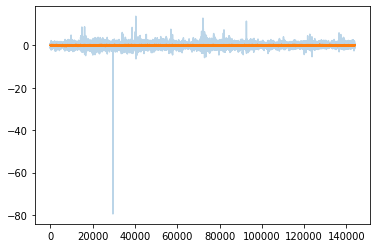

Epoch[9/10] | loss train:5386.179192, val loss:3897.464914 | lr:0.001000 | r2: 0.00857|
[ 0.1046952   0.27504802  0.03310672 ... -0.0075217   0.00823461
 -0.02045514]
[-1.194368   -1.1941221  -1.2158712  ... -0.3986526  -0.6004652
 -0.45374256]


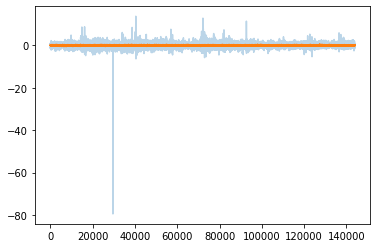

Epoch[10/10] | loss train:5376.889287, val loss:3899.165183 | lr:0.001000 | r2: 0.00814|
Train data shape (575904, 100, 42) (575904,)
Validation data shape (143977, 100, 42) (143977,)
[ 0.04450294  0.22455317 -0.01729807 ... -0.0273834  -0.02096096
 -0.05322541]
[-1.1613474  -1.161081   -1.1822064  ... -0.48096392 -0.6634435
 -0.44119164]


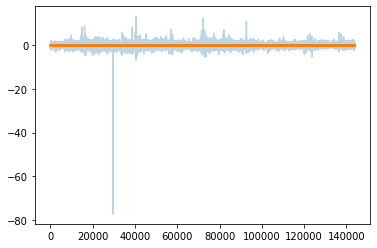

Epoch[1/10] | loss train:5451.011650, val loss:3904.176938 | lr:0.001000 | r2: 0.00727|
[ 0.08912712  0.22503985 -0.01331785 ...  0.00875019  0.00136962
 -0.04506328]
[-1.1613474  -1.161081   -1.1822064  ... -0.48096392 -0.6634435
 -0.44119164]


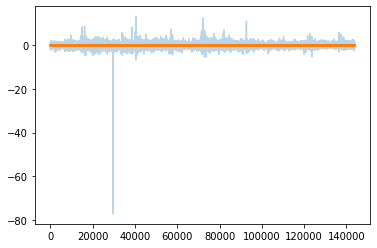

Epoch[2/10] | loss train:5429.244130, val loss:3901.355932 | lr:0.001000 | r2: 0.00799|
[ 0.10985439  0.25263953 -0.02932233 ...  0.01509497 -0.0075012
 -0.04914407]
[-1.1613474  -1.161081   -1.1822064  ... -0.48096392 -0.6634435
 -0.44119164]


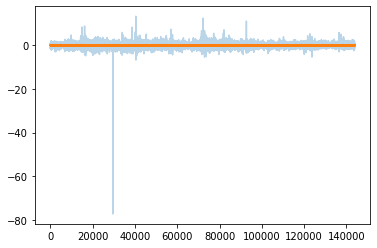

Epoch[3/10] | loss train:5424.110527, val loss:3899.222353 | lr:0.001000 | r2: 0.00853|
[ 0.14030237  0.2509469   0.01414405 ...  0.03305643  0.00905993
 -0.03376809]
[-1.1613474  -1.161081   -1.1822064  ... -0.48096392 -0.6634435
 -0.44119164]


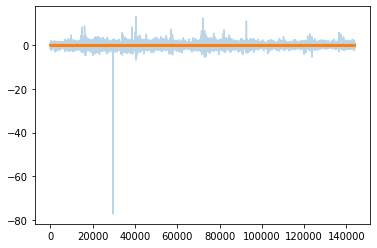

Epoch[4/10] | loss train:5420.348212, val loss:3899.060992 | lr:0.001000 | r2: 0.00857|
[ 0.09958674  0.24170157 -0.00464982 ...  0.00754143 -0.0084679
 -0.05726594]
[-1.1613474  -1.161081   -1.1822064  ... -0.48096392 -0.6634435
 -0.44119164]


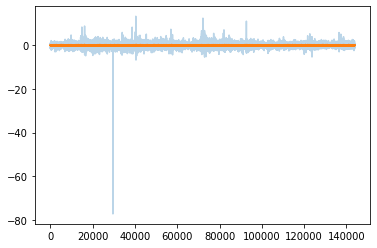

Epoch[5/10] | loss train:5416.973005, val loss:3899.935575 | lr:0.001000 | r2: 0.00834|
[ 0.12323654  0.27587628  0.05519783 ...  0.03904992  0.01177208
 -0.01919029]
[-1.1613474  -1.161081   -1.1822064  ... -0.48096392 -0.6634435
 -0.44119164]


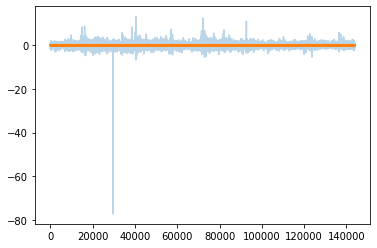

Epoch[6/10] | loss train:5413.917580, val loss:3897.851606 | lr:0.001000 | r2: 0.00888|
[ 0.1129467   0.23438767  0.02263915 ...  0.02928233  0.00224413
 -0.03392968]
[-1.1613474  -1.161081   -1.1822064  ... -0.48096392 -0.6634435
 -0.44119164]


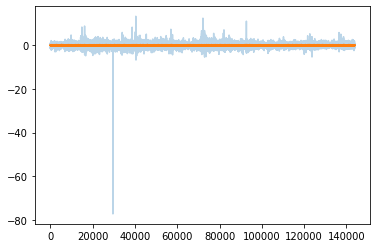

Epoch[7/10] | loss train:5412.728901, val loss:3899.000848 | lr:0.001000 | r2: 0.00858|
[ 0.07478756  0.2645256   0.00854297 ...  0.00491969 -0.00721855
 -0.05223324]
[-1.1613474  -1.161081   -1.1822064  ... -0.48096392 -0.6634435
 -0.44119164]


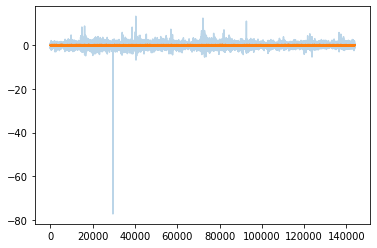

Epoch[8/10] | loss train:5409.252990, val loss:3899.302633 | lr:0.001000 | r2: 0.00851|
[ 0.06402496  0.22341482 -0.0253272  ...  0.0125294  -0.00200155
 -0.06610853]
[-1.1613474  -1.161081   -1.1822064  ... -0.48096392 -0.6634435
 -0.44119164]


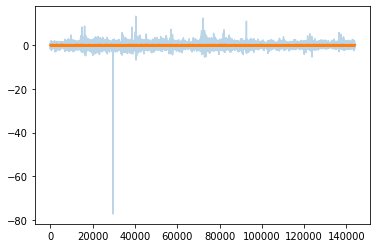

Epoch[9/10] | loss train:5404.349871, val loss:3898.896437 | lr:0.001000 | r2: 0.00861|
[ 0.05892321  0.24733354  0.01395094 ...  0.03528094 -0.01110141
 -0.01923135]
[-1.1613474  -1.161081   -1.1822064  ... -0.48096392 -0.6634435
 -0.44119164]


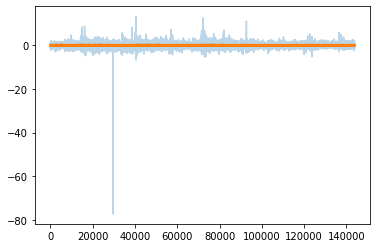

Epoch[10/10] | loss train:5402.912681, val loss:3905.249589 | lr:0.001000 | r2: 0.00700|
Train data shape (575904, 100, 42) (575904,)
Validation data shape (143976, 100, 42) (143976,)
[ 0.2102296  -0.0211543  -0.04141202 ...  0.00790453 -0.00795433
 -0.06481287]
[-1.1305306  -1.1516073  -1.3071352  ... -0.54581773 -0.6460051
 -0.42954457]


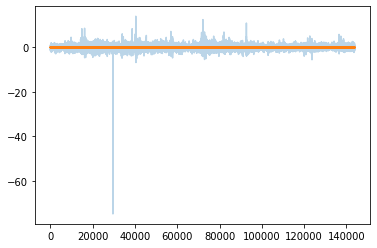

Epoch[1/10] | loss train:5464.256674, val loss:3906.613929 | lr:0.001000 | r2: 0.00698|
[ 1.86030671e-01 -2.32514851e-02 -8.74525458e-02 ...  1.02539798e-02
 -1.14797615e-04 -5.12675196e-02]
[-1.1305306  -1.1516073  -1.3071352  ... -0.54581773 -0.6460051
 -0.42954457]


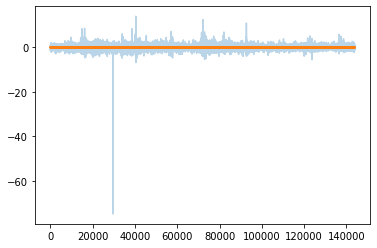

Epoch[2/10] | loss train:5442.560836, val loss:3904.461963 | lr:0.001000 | r2: 0.00753|
[ 0.18542461  0.00756796 -0.08526839 ...  0.02367526  0.00573749
 -0.05156206]
[-1.1305306  -1.1516073  -1.3071352  ... -0.54581773 -0.6460051
 -0.42954457]


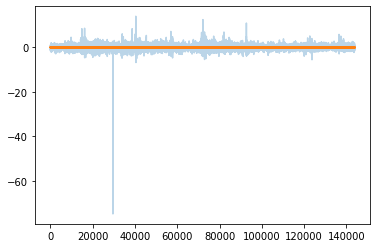

Epoch[3/10] | loss train:5436.734554, val loss:3903.565648 | lr:0.001000 | r2: 0.00775|
[ 1.9131048e-01 -2.1005981e-06 -8.6425878e-02 ...  1.5597247e-02
  7.5416933e-03 -4.8341420e-02]
[-1.1305306  -1.1516073  -1.3071352  ... -0.54581773 -0.6460051
 -0.42954457]


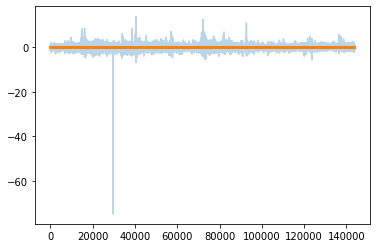

Epoch[4/10] | loss train:5432.971749, val loss:3902.184243 | lr:0.001000 | r2: 0.00811|
[ 0.24118415  0.03474304 -0.08365285 ...  0.01926954  0.01862101
 -0.03830377]
[-1.1305306  -1.1516073  -1.3071352  ... -0.54581773 -0.6460051
 -0.42954457]


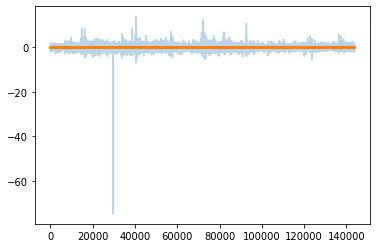

Epoch[5/10] | loss train:5429.710560, val loss:3901.408065 | lr:0.001000 | r2: 0.00830|
[ 0.2853113   0.05391228 -0.05366924 ...  0.0331619   0.02994166
 -0.04155757]
[-1.1305306  -1.1516073  -1.3071352  ... -0.54581773 -0.6460051
 -0.42954457]


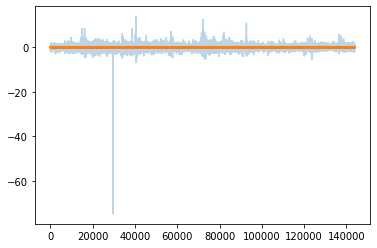

Epoch[6/10] | loss train:5428.924258, val loss:3902.225706 | lr:0.001000 | r2: 0.00810|
[ 0.21966107 -0.01498594 -0.09172734 ...  0.01146129  0.00573758
 -0.06926706]
[-1.1305306  -1.1516073  -1.3071352  ... -0.54581773 -0.6460051
 -0.42954457]


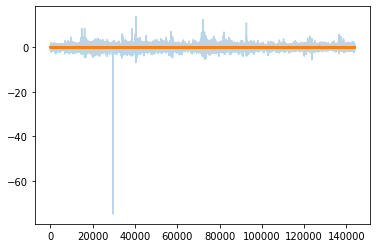

Epoch[7/10] | loss train:5431.258488, val loss:3902.970128 | lr:0.001000 | r2: 0.00791|
[ 0.25378305  0.02882393 -0.07593489 ...  0.04122686  0.0401844
 -0.03673449]
[-1.1305306  -1.1516073  -1.3071352  ... -0.54581773 -0.6460051
 -0.42954457]


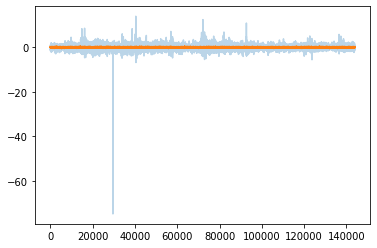

Epoch[8/10] | loss train:5424.252844, val loss:3905.461509 | lr:0.001000 | r2: 0.00728|
[ 0.2974007   0.01522803  0.00065242 ...  0.05254488  0.03327676
 -0.0327343 ]
[-1.1305306  -1.1516073  -1.3071352  ... -0.54581773 -0.6460051
 -0.42954457]


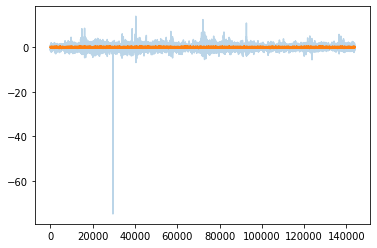

Epoch[9/10] | loss train:5420.064663, val loss:3911.208429 | lr:0.001000 | r2: 0.00582|
[ 0.2603568  -0.04158613 -0.02180536 ...  0.02140255  0.06691685
 -0.03149893]
[-1.1305306  -1.1516073  -1.3071352  ... -0.54581773 -0.6460051
 -0.42954457]


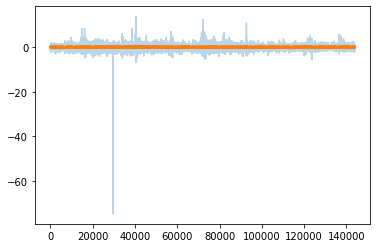

Epoch[10/10] | loss train:5417.610903, val loss:3924.271268 | lr:0.001000 | r2: 0.00250|
Train data shape (575903, 100, 42) (575903,)
Validation data shape (143976, 100, 42) (143976,)
[ 0.20742789 -0.02512355 -0.09045511 ... -0.00329234 -0.00198989
 -0.07822806]
[-1.1026844  -1.1229427  -0.9454329  ... -0.5321502  -0.6297796
 -0.41878852]


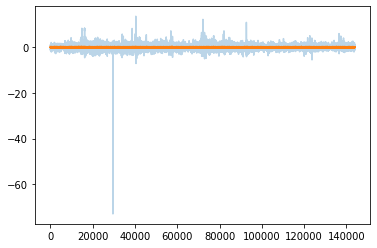

Epoch[1/10] | loss train:5477.620306, val loss:3908.167109 | lr:0.001000 | r2: 0.00625|
[ 0.23565243  0.01671991 -0.06959587 ... -0.01389968  0.01116223
 -0.06369506]
[-1.1026844  -1.1229427  -0.9454329  ... -0.5321502  -0.6297796
 -0.41878852]


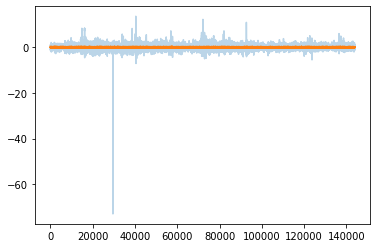

Epoch[2/10] | loss train:5454.168539, val loss:3905.158727 | lr:0.001000 | r2: 0.00701|
[ 0.22685868  0.01895322 -0.0231353  ... -0.01270324  0.02317888
 -0.06759372]
[-1.1026844  -1.1229427  -0.9454329  ... -0.5321502  -0.6297796
 -0.41878852]


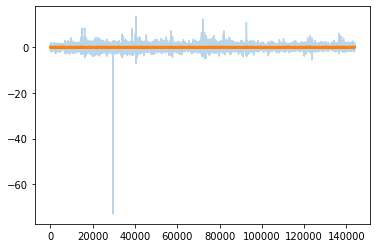

Epoch[3/10] | loss train:5449.177813, val loss:3904.355408 | lr:0.001000 | r2: 0.00722|
[ 0.23238596  0.04295728 -0.04628497 ... -0.0008844   0.03504203
 -0.01867935]
[-1.1026844  -1.1229427  -0.9454329  ... -0.5321502  -0.6297796
 -0.41878852]


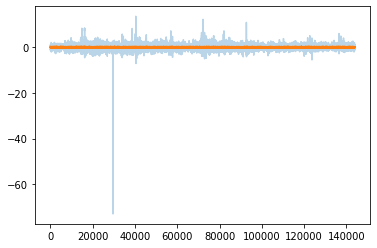

Epoch[4/10] | loss train:5445.340673, val loss:3902.385898 | lr:0.001000 | r2: 0.00772|
[ 0.25172472  0.0229762  -0.07831383 ...  0.01821246  0.0559094
 -0.01417201]
[-1.1026844  -1.1229427  -0.9454329  ... -0.5321502  -0.6297796
 -0.41878852]


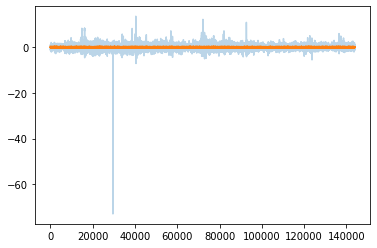

Epoch[5/10] | loss train:5443.382932, val loss:3901.530282 | lr:0.001000 | r2: 0.00794|
[ 0.23344234  0.00957478 -0.09410722 ...  0.02971029  0.05815918
 -0.00448849]
[-1.1026844  -1.1229427  -0.9454329  ... -0.5321502  -0.6297796
 -0.41878852]


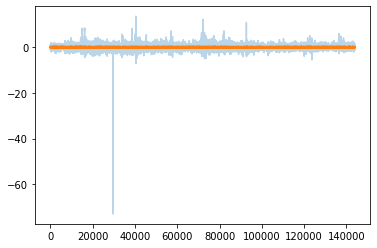

Epoch[6/10] | loss train:5441.951058, val loss:3902.465934 | lr:0.001000 | r2: 0.00770|
[ 0.2532841  -0.00196407 -0.08199003 ...  0.00333828  0.02511673
 -0.02502499]
[-1.1026844  -1.1229427  -0.9454329  ... -0.5321502  -0.6297796
 -0.41878852]


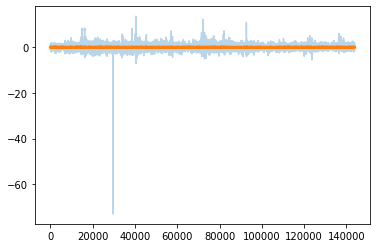

Epoch[7/10] | loss train:5439.646870, val loss:3903.016731 | lr:0.001000 | r2: 0.00756|
[ 0.24827164  0.00382652 -0.08281967 ...  0.04340121  0.04807159
  0.00940669]
[-1.1026844  -1.1229427  -0.9454329  ... -0.5321502  -0.6297796
 -0.41878852]


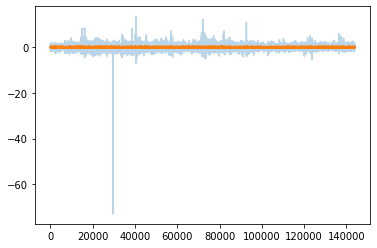

Epoch[8/10] | loss train:5435.884760, val loss:3905.072719 | lr:0.001000 | r2: 0.00704|
[ 2.7201945e-01 -1.9722432e-03 -9.9951416e-02 ...  3.8728587e-02
  3.0121868e-02 -2.5447179e-04]
[-1.1026844  -1.1229427  -0.9454329  ... -0.5321502  -0.6297796
 -0.41878852]


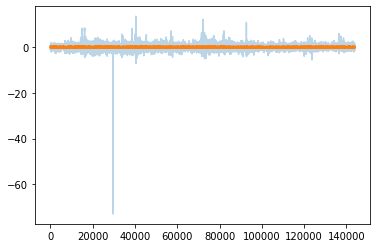

Epoch[9/10] | loss train:5431.005514, val loss:3905.977908 | lr:0.001000 | r2: 0.00681|
[ 0.25972885 -0.03790184 -0.09384952 ...  0.04230389  0.01494335
  0.02067824]
[-1.1026844  -1.1229427  -0.9454329  ... -0.5321502  -0.6297796
 -0.41878852]


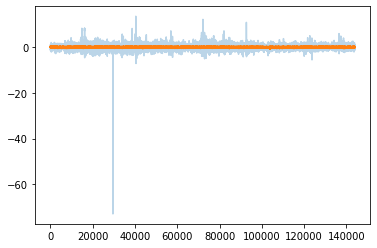

Epoch[10/10] | loss train:5423.814385, val loss:3910.192456 | lr:0.001000 | r2: 0.00574|
Train data shape (575902, 100, 42) (575902,)
Validation data shape (143976, 100, 42) (143976,)
[ 0.21257336 -0.00345149 -0.04166802 ...  0.00758654 -0.03208498
 -0.09266461]
[-1.0764871  -0.7749877  -0.6793925  ... -0.51937836 -0.6147214
 -0.42068544]


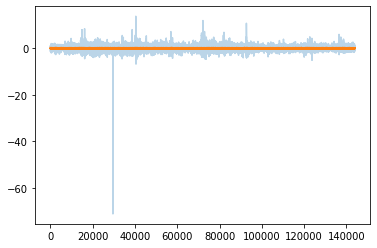

Epoch[1/10] | loss train:5489.072021, val loss:3908.275751 | lr:0.001000 | r2: 0.00652|
[ 0.23453072 -0.06931543 -0.06645095 ...  0.01961598 -0.0150363
 -0.06171501]
[-1.0764871  -0.7749877  -0.6793925  ... -0.51937836 -0.6147214
 -0.42068544]


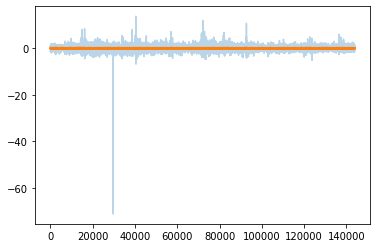

Epoch[2/10] | loss train:5466.589599, val loss:3906.081218 | lr:0.001000 | r2: 0.00708|
[ 0.21196698 -0.0458228  -0.05260805 ...  0.00380373 -0.0096499
 -0.05432533]
[-1.0764871  -0.7749877  -0.6793925  ... -0.51937836 -0.6147214
 -0.42068544]


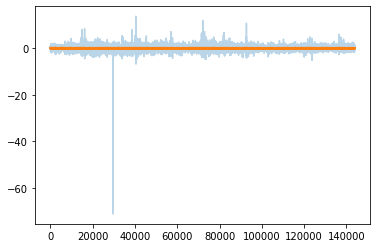

Epoch[3/10] | loss train:5461.567285, val loss:3904.876364 | lr:0.001000 | r2: 0.00738|
[ 0.19833829 -0.04066608 -0.06118413 ...  0.0086074  -0.00238613
 -0.05691816]
[-1.0764871  -0.7749877  -0.6793925  ... -0.51937836 -0.6147214
 -0.42068544]


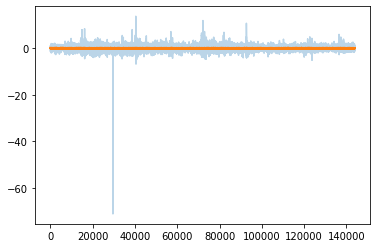

Epoch[4/10] | loss train:5457.234797, val loss:3904.619303 | lr:0.001000 | r2: 0.00745|
[ 0.18979733 -0.03903943 -0.10338329 ...  0.01796615 -0.00508852
 -0.07186684]
[-1.0764871  -0.7749877  -0.6793925  ... -0.51937836 -0.6147214
 -0.42068544]


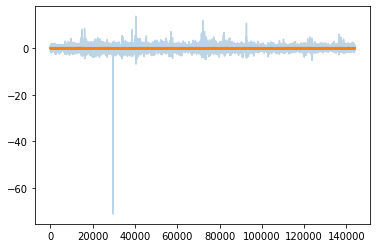

Epoch[5/10] | loss train:5455.151969, val loss:3904.893993 | lr:0.001000 | r2: 0.00738|
[ 0.19912975 -0.04237356 -0.0726202  ...  0.02671369 -0.00099902
 -0.07285501]
[-1.0764871  -0.7749877  -0.6793925  ... -0.51937836 -0.6147214
 -0.42068544]


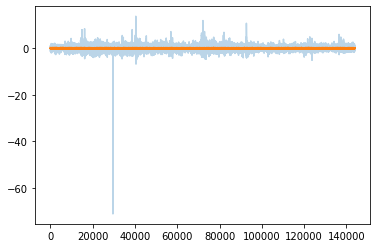

Epoch[6/10] | loss train:5453.874385, val loss:3903.296751 | lr:0.001000 | r2: 0.00778|
[ 0.18068323 -0.02350981 -0.08479086 ...  0.02563502  0.00711018
 -0.08140762]
[-1.0764871  -0.7749877  -0.6793925  ... -0.51937836 -0.6147214
 -0.42068544]


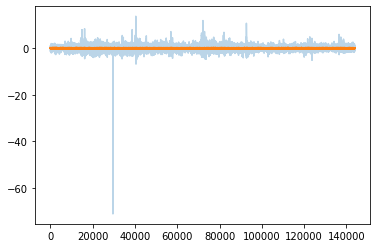

Epoch[7/10] | loss train:5450.064670, val loss:3903.405581 | lr:0.001000 | r2: 0.00775|
[ 0.18987283 -0.00656156 -0.05520265 ...  0.0448577   0.00470167
 -0.11740811]
[-1.0764871  -0.7749877  -0.6793925  ... -0.51937836 -0.6147214
 -0.42068544]


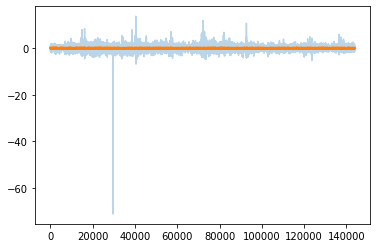

Epoch[8/10] | loss train:5447.691974, val loss:3904.008428 | lr:0.001000 | r2: 0.00760|
[ 0.22821203 -0.04732694 -0.09721877 ...  0.07519219  0.02966125
 -0.10328316]
[-1.0764871  -0.7749877  -0.6793925  ... -0.51937836 -0.6147214
 -0.42068544]


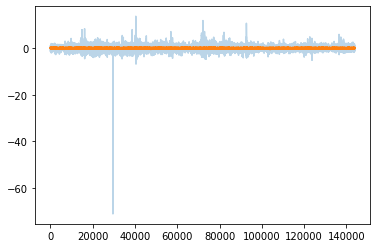

Epoch[9/10] | loss train:5444.497584, val loss:3907.117665 | lr:0.001000 | r2: 0.00682|
[ 0.19849478 -0.00798506 -0.03798037 ...  0.03915973  0.0057709
 -0.09123069]
[-1.0764871  -0.7749877  -0.6793925  ... -0.51937836 -0.6147214
 -0.42068544]


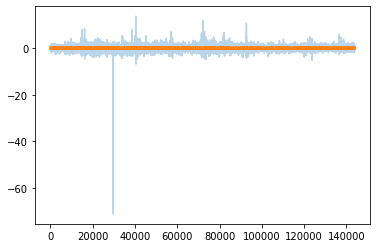

Epoch[10/10] | loss train:5446.008607, val loss:3906.404806 | lr:0.001000 | r2: 0.00700|
Train data shape (575901, 100, 42) (575901,)
Validation data shape (143976, 100, 42) (143976,)
[ 0.18706994 -0.00930084 -0.06624083 ...  0.00660269  0.00454633
 -0.08268906]
[-0.73809963 -0.51939154 -0.6293101  ... -0.5074956  -0.61229503
 -0.4110039 ]


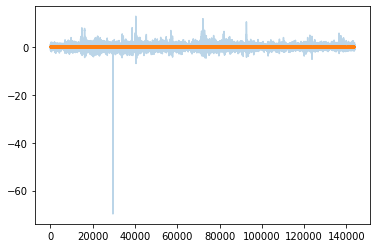

Epoch[1/10] | loss train:5494.494023, val loss:3909.200785 | lr:0.001000 | r2: 0.00647|
[ 0.2011577  -0.03740407 -0.10160474 ... -0.00142727 -0.01094894
 -0.07186672]
[-0.73809963 -0.51939154 -0.6293101  ... -0.5074956  -0.61229503
 -0.4110039 ]


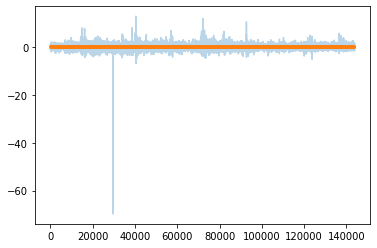

Epoch[2/10] | loss train:5471.825196, val loss:3908.420404 | lr:0.001000 | r2: 0.00666|
[ 0.2179046  -0.0231372  -0.11186445 ...  0.03069209  0.0059252
 -0.05734058]
[-0.73809963 -0.51939154 -0.6293101  ... -0.5074956  -0.61229503
 -0.4110039 ]


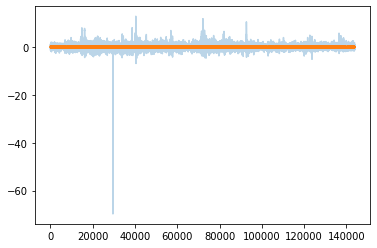

Epoch[3/10] | loss train:5467.066391, val loss:3906.651810 | lr:0.001000 | r2: 0.00711|
[ 0.22431734 -0.00684981 -0.07163699 ...  0.02747395  0.01559362
 -0.05759631]
[-0.73809963 -0.51939154 -0.6293101  ... -0.5074956  -0.61229503
 -0.4110039 ]


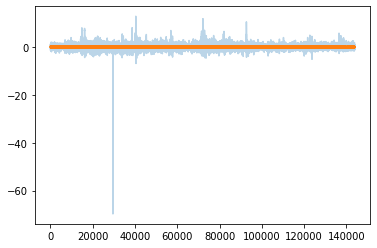

Epoch[4/10] | loss train:5463.882893, val loss:3905.706428 | lr:0.001000 | r2: 0.00735|
[ 0.20529392 -0.02717817 -0.09532037 ...  0.03597996  0.02631834
 -0.0509767 ]
[-0.73809963 -0.51939154 -0.6293101  ... -0.5074956  -0.61229503
 -0.4110039 ]


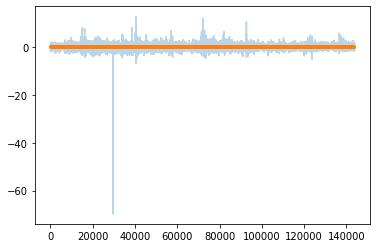

Epoch[5/10] | loss train:5461.675608, val loss:3905.889679 | lr:0.001000 | r2: 0.00731|
[ 0.20875575 -0.00519451 -0.13627975 ...  0.02268656  0.01024219
 -0.05595227]
[-0.73809963 -0.51939154 -0.6293101  ... -0.5074956  -0.61229503
 -0.4110039 ]


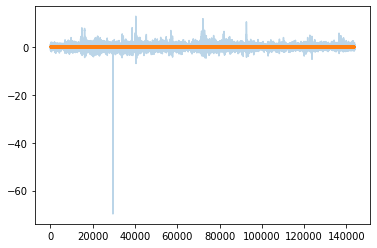

Epoch[6/10] | loss train:5459.314165, val loss:3905.510842 | lr:0.001000 | r2: 0.00740|
[ 0.20362751  0.02085017 -0.0967906  ...  0.00926647  0.00184791
 -0.05061029]
[-0.73809963 -0.51939154 -0.6293101  ... -0.5074956  -0.61229503
 -0.4110039 ]


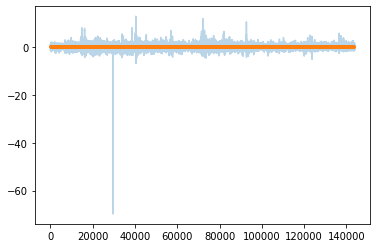

Epoch[7/10] | loss train:5458.445862, val loss:3905.181394 | lr:0.001000 | r2: 0.00749|
[ 0.1890551   0.00808188 -0.07433432 ... -0.01750085 -0.01888899
 -0.05921159]
[-0.73809963 -0.51939154 -0.6293101  ... -0.5074956  -0.61229503
 -0.4110039 ]


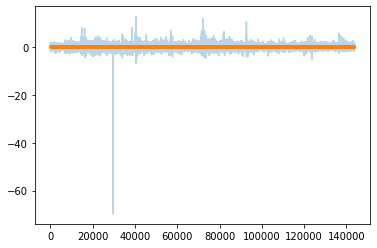

Epoch[8/10] | loss train:5456.050622, val loss:3907.142093 | lr:0.001000 | r2: 0.00699|
[ 0.18065277 -0.03950559 -0.10723721 ... -0.02528051 -0.0047525
 -0.07373887]
[-0.73809963 -0.51939154 -0.6293101  ... -0.5074956  -0.61229503
 -0.4110039 ]


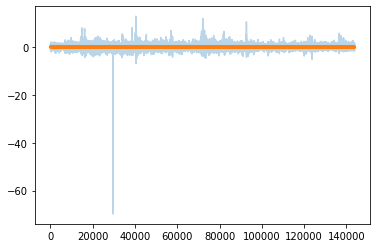

Epoch[9/10] | loss train:5449.580221, val loss:3907.299108 | lr:0.001000 | r2: 0.00695|
[ 2.5282678e-01  9.6226409e-03 -1.0863723e-01 ... -2.5092527e-02
  2.0477921e-05 -8.3926700e-02]
[-0.73809963 -0.51939154 -0.6293101  ... -0.5074956  -0.61229503
 -0.4110039 ]


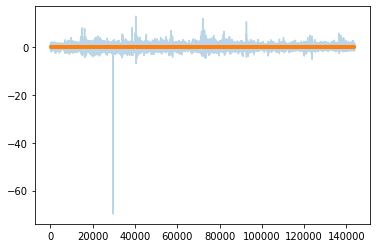

Epoch[10/10] | loss train:5443.676509, val loss:3909.282379 | lr:0.001000 | r2: 0.00645|
Train data shape (575900, 100, 42) (575900,)
Validation data shape (143976, 100, 42) (143976,)
[ 0.19773474 -0.01759494 -0.05766507 ... -0.02336011 -0.0198429
 -0.06825908]
[-0.48926225 -0.47421804 -0.615747   ... -0.50774676 -0.59880954
 -0.6514217 ]


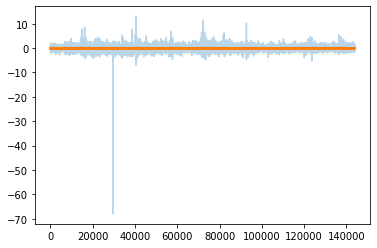

Epoch[1/10] | loss train:5499.706229, val loss:3909.166242 | lr:0.001000 | r2: 0.00633|
[ 0.19762892 -0.0145075  -0.10313304 ...  0.0038531  -0.01759712
 -0.05491152]
[-0.48926225 -0.47421804 -0.615747   ... -0.50774676 -0.59880954
 -0.6514217 ]


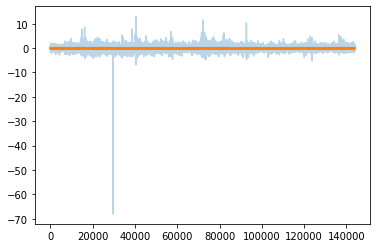

Epoch[2/10] | loss train:5478.615204, val loss:3908.503812 | lr:0.001000 | r2: 0.00650|
[ 0.17269991 -0.02474398 -0.09713434 ...  0.00731714  0.00341385
 -0.03740506]
[-0.48926225 -0.47421804 -0.615747   ... -0.50774676 -0.59880954
 -0.6514217 ]


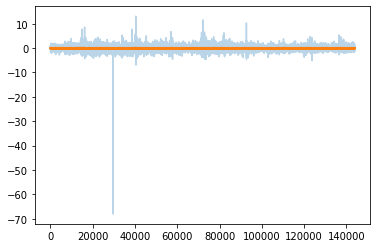

Epoch[3/10] | loss train:5473.084274, val loss:3908.255227 | lr:0.001000 | r2: 0.00656|
[ 0.17525743  0.02385407 -0.09265438 ...  0.02393398  0.01375997
 -0.03140445]
[-0.48926225 -0.47421804 -0.615747   ... -0.50774676 -0.59880954
 -0.6514217 ]


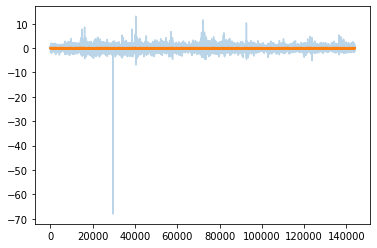

Epoch[4/10] | loss train:5469.559843, val loss:3906.723511 | lr:0.001000 | r2: 0.00695|
[ 0.17391986 -0.00628117 -0.09445464 ...  0.02632456  0.01826347
 -0.03440687]
[-0.48926225 -0.47421804 -0.615747   ... -0.50774676 -0.59880954
 -0.6514217 ]


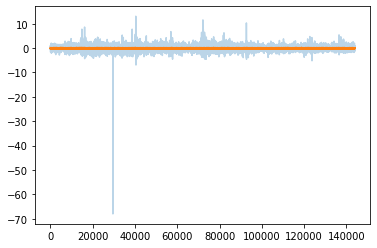

Epoch[5/10] | loss train:5468.148962, val loss:3906.584186 | lr:0.001000 | r2: 0.00698|
[ 0.17773625  0.00027568 -0.08948595 ...  0.00768701  0.00269411
 -0.0754442 ]
[-0.48926225 -0.47421804 -0.615747   ... -0.50774676 -0.59880954
 -0.6514217 ]


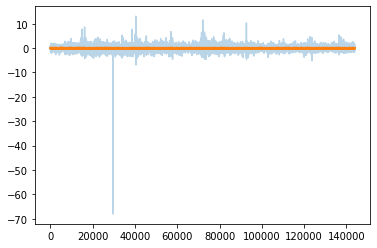

Epoch[6/10] | loss train:5465.140483, val loss:3905.587908 | lr:0.001000 | r2: 0.00724|
[ 0.1797578  -0.02572711 -0.112885   ...  0.02996553 -0.0027669
 -0.03949008]
[-0.48926225 -0.47421804 -0.615747   ... -0.50774676 -0.59880954
 -0.6514217 ]


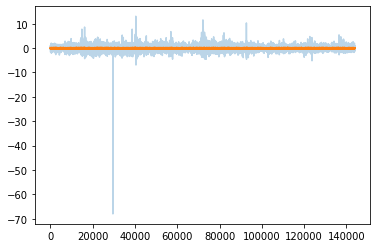

Epoch[7/10] | loss train:5466.523152, val loss:3907.017615 | lr:0.001000 | r2: 0.00687|
[ 0.19896689 -0.03216617 -0.0974097  ...  0.00296547  0.00346075
 -0.06041044]
[-0.48926225 -0.47421804 -0.615747   ... -0.50774676 -0.59880954
 -0.6514217 ]


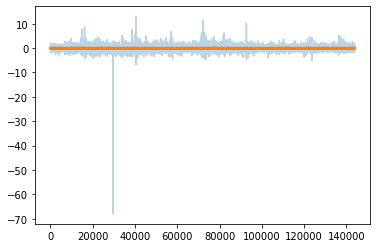

Epoch[8/10] | loss train:5463.494978, val loss:3905.805777 | lr:0.001000 | r2: 0.00718|
[ 0.24784328 -0.0274305  -0.0162138  ... -0.01928028 -0.01742335
 -0.09499599]
[-0.48926225 -0.47421804 -0.615747   ... -0.50774676 -0.59880954
 -0.6514217 ]


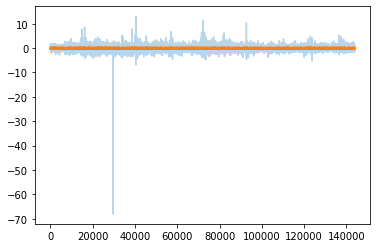

Epoch[9/10] | loss train:5459.517324, val loss:3908.752073 | lr:0.001000 | r2: 0.00643|
[ 0.24185741  0.04709912 -0.03649184 ...  0.05265941  0.03075005
 -0.00230253]
[-0.48926225 -0.47421804 -0.615747   ... -0.50774676 -0.59880954
 -0.6514217 ]


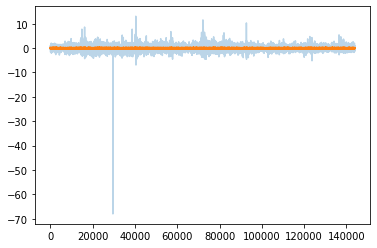

Epoch[10/10] | loss train:5456.105800, val loss:3907.260492 | lr:0.001000 | r2: 0.00681|
Train data shape (575900, 100, 42) (575900,)
Validation data shape (143975, 100, 42) (143975,)
[-0.0311706  -0.03874153 -0.01492061 ... -0.01660662 -0.0320146
 -0.09357232]
[-0.46446377 -0.6027612  -0.6028404  ... -0.49699682 -0.83037424
 -1.1919292 ]


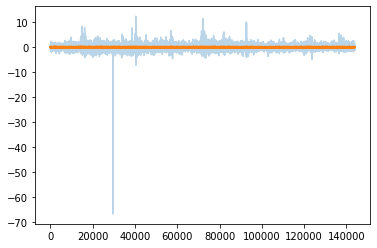

Epoch[1/10] | loss train:5503.074016, val loss:3911.702106 | lr:0.001000 | r2: 0.00594|
[-0.0161984  -0.07557337 -0.02314701 ...  0.01272867 -0.02481509
 -0.07770521]
[-0.46446377 -0.6027612  -0.6028404  ... -0.49699682 -0.83037424
 -1.1919292 ]


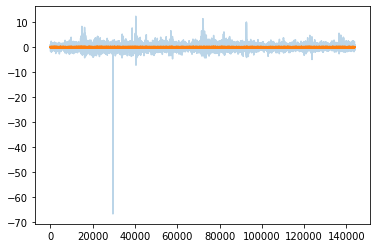

Epoch[2/10] | loss train:5482.656109, val loss:3910.284325 | lr:0.001000 | r2: 0.00630|
[-0.00633779 -0.07298864 -0.02458414 ... -0.00459193 -0.01366278
 -0.0700229 ]
[-0.46446377 -0.6027612  -0.6028404  ... -0.49699682 -0.83037424
 -1.1919292 ]


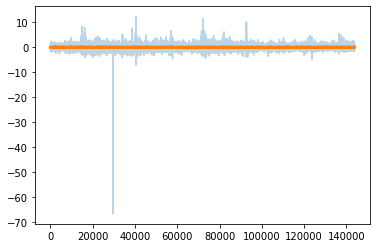

Epoch[3/10] | loss train:5477.574734, val loss:3909.218692 | lr:0.001000 | r2: 0.00657|
[-0.05601254 -0.08430193 -0.03012301 ...  0.01198445 -0.00683243
 -0.05581871]
[-0.46446377 -0.6027612  -0.6028404  ... -0.49699682 -0.83037424
 -1.1919292 ]


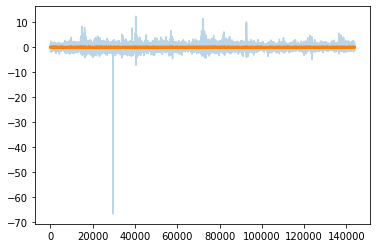

Epoch[4/10] | loss train:5474.993004, val loss:3908.863963 | lr:0.001000 | r2: 0.00666|
[-0.01378567 -0.09198123 -0.01188001 ...  0.02120115 -0.0079449
 -0.04875432]
[-0.46446377 -0.6027612  -0.6028404  ... -0.49699682 -0.83037424
 -1.1919292 ]


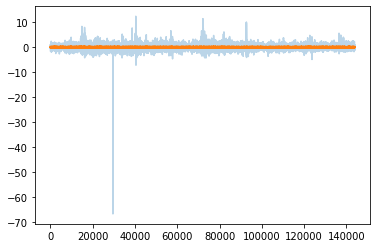

Epoch[5/10] | loss train:5472.306943, val loss:3907.951799 | lr:0.001000 | r2: 0.00689|
[-0.03506137 -0.08727475 -0.07082857 ...  0.02596411 -0.01866468
 -0.02821627]
[-0.46446377 -0.6027612  -0.6028404  ... -0.49699682 -0.83037424
 -1.1919292 ]


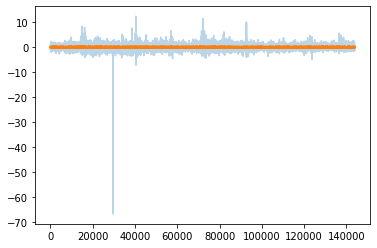

Epoch[6/10] | loss train:5469.925409, val loss:3908.480424 | lr:0.001000 | r2: 0.00676|
[-0.0196159  -0.07798281 -0.0871613  ...  0.01199478 -0.02057706
 -0.07239155]
[-0.46446377 -0.6027612  -0.6028404  ... -0.49699682 -0.83037424
 -1.1919292 ]


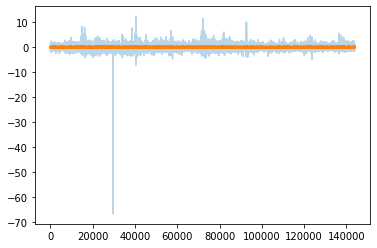

Epoch[7/10] | loss train:5468.656608, val loss:3908.279424 | lr:0.001000 | r2: 0.00681|
[-0.03326802 -0.08742616 -0.07717021 ...  0.00856657 -0.02401673
 -0.07743438]
[-0.46446377 -0.6027612  -0.6028404  ... -0.49699682 -0.83037424
 -1.1919292 ]


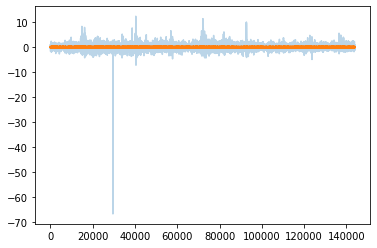

Epoch[8/10] | loss train:5467.866688, val loss:3908.235850 | lr:0.001000 | r2: 0.00683|
[-0.03995948 -0.08156064 -0.04000676 ...  0.01499671 -0.02025594
 -0.05583241]
[-0.46446377 -0.6027612  -0.6028404  ... -0.49699682 -0.83037424
 -1.1919292 ]


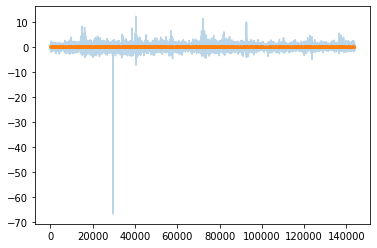

Epoch[9/10] | loss train:5464.935468, val loss:3908.354736 | lr:0.001000 | r2: 0.00680|
[-0.02236871 -0.07469206 -0.05333759 ...  0.04000732  0.02267757
  0.01640618]
[-0.46446377 -0.6027612  -0.6028404  ... -0.49699682 -0.83037424
 -1.1919292 ]


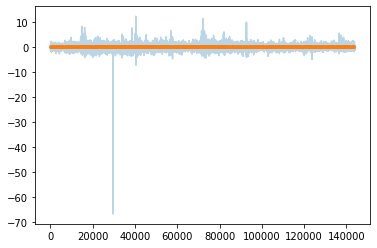

Epoch[10/10] | loss train:5458.952074, val loss:3910.667253 | lr:0.001000 | r2: 0.00621|
Train data shape (575899, 100, 42) (575899,)
Validation data shape (143975, 100, 42) (143975,)
[ 0.00479868 -0.06792267 -0.00203334 ... -0.01110007 -0.01111745
 -0.0724887 ]
[-0.4550375  -0.59068674 -0.5906252  ... -0.72615695 -1.3565477
 -1.1675816 ]


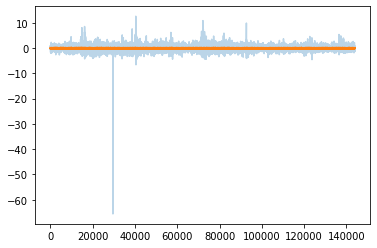

Epoch[1/10] | loss train:5505.727383, val loss:3915.247224 | lr:0.001000 | r2: 0.00549|
[-0.0175161  -0.05627349  0.00333879 ... -0.00392572 -0.01814044
 -0.08881617]
[-0.4550375  -0.59068674 -0.5906252  ... -0.72615695 -1.3565477
 -1.1675816 ]


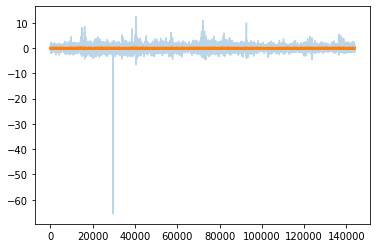

Epoch[2/10] | loss train:5485.324948, val loss:3912.886354 | lr:0.001000 | r2: 0.00609|
[-0.02941782 -0.07253843 -0.01299409 ...  0.00511246 -0.00557088
 -0.07607982]
[-0.4550375  -0.59068674 -0.5906252  ... -0.72615695 -1.3565477
 -1.1675816 ]


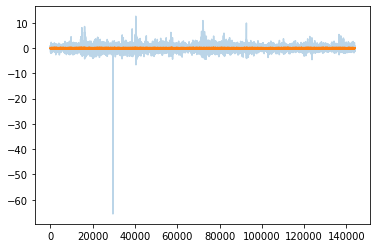

Epoch[3/10] | loss train:5480.076000, val loss:3912.350155 | lr:0.001000 | r2: 0.00622|
[-0.01333627 -0.07630473 -0.00739245 ...  0.00471433 -0.00935589
 -0.07131471]
[-0.4550375  -0.59068674 -0.5906252  ... -0.72615695 -1.3565477
 -1.1675816 ]


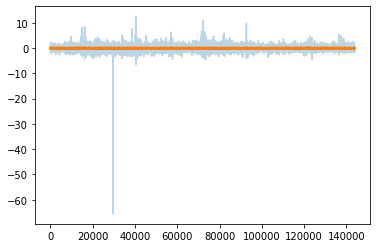

Epoch[4/10] | loss train:5478.114053, val loss:3911.466514 | lr:0.001000 | r2: 0.00645|
[-0.0054691  -0.09321545  0.00939081 ... -0.00560638 -0.01395469
 -0.07876205]
[-0.4550375  -0.59068674 -0.5906252  ... -0.72615695 -1.3565477
 -1.1675816 ]


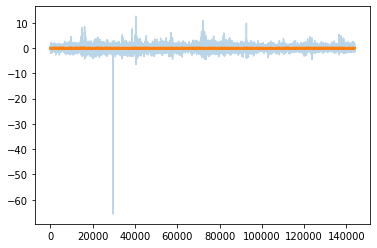

Epoch[5/10] | loss train:5476.548146, val loss:3911.385316 | lr:0.001000 | r2: 0.00647|
[-0.00585804 -0.0917078  -0.01970983 ... -0.02599674 -0.05132446
 -0.10622219]
[-0.4550375  -0.59068674 -0.5906252  ... -0.72615695 -1.3565477
 -1.1675816 ]


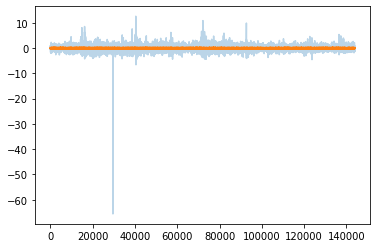

Epoch[6/10] | loss train:5474.211072, val loss:3910.231785 | lr:0.001000 | r2: 0.00676|
[ 0.00477556 -0.08224401 -0.03501207 ...  0.00487932 -0.03213759
 -0.08613534]
[-0.4550375  -0.59068674 -0.5906252  ... -0.72615695 -1.3565477
 -1.1675816 ]


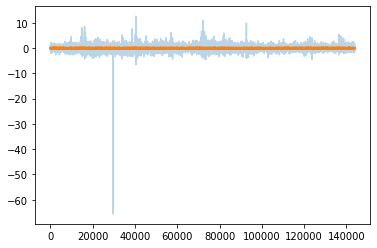

Epoch[7/10] | loss train:5471.929625, val loss:3911.333492 | lr:0.001000 | r2: 0.00648|
[ 0.01684238 -0.10902131 -0.03725919 ...  0.00247818 -0.03257789
 -0.08594669]
[-0.4550375  -0.59068674 -0.5906252  ... -0.72615695 -1.3565477
 -1.1675816 ]


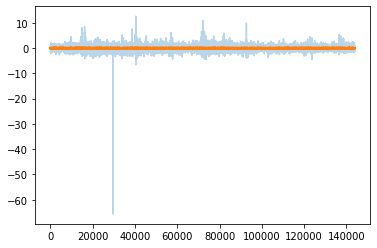

Epoch[8/10] | loss train:5469.308811, val loss:3911.295377 | lr:0.001000 | r2: 0.00649|
[ 0.03072245 -0.0677048   0.01476611 ...  0.01604576 -0.01403448
 -0.08717833]
[-0.4550375  -0.59068674 -0.5906252  ... -0.72615695 -1.3565477
 -1.1675816 ]


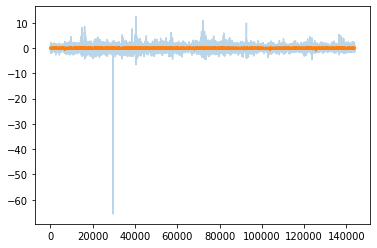

Epoch[9/10] | loss train:5468.306263, val loss:3914.129782 | lr:0.001000 | r2: 0.00577|
[-0.0100318  -0.07880264 -0.01632863 ...  0.02258715  0.03091237
 -0.03778619]
[-0.4550375  -0.59068674 -0.5906252  ... -0.72615695 -1.3565477
 -1.1675816 ]


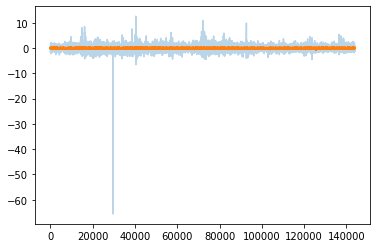

Epoch[10/10] | loss train:5465.066727, val loss:3912.959904 | lr:0.001000 | r2: 0.00607|
Train data shape (575898, 100, 42) (575898,)
Validation data shape (143975, 100, 42) (143975,)
[-0.00399677 -0.06512189  0.01803325 ... -0.02727452 -0.02128067
 -0.072774  ]
[-0.44629136 -0.5791562  -0.57901347 ... -1.2443814  -1.3298751
 -1.287301  ]


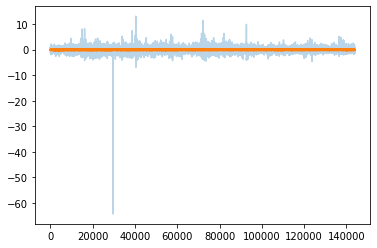

Epoch[1/10] | loss train:5508.611295, val loss:3917.163777 | lr:0.001000 | r2: 0.00547|
[-0.01935474 -0.06913117 -0.02290595 ... -0.01939609 -0.01460018
 -0.07646298]
[-0.44629136 -0.5791562  -0.57901347 ... -1.2443814  -1.3298751
 -1.287301  ]


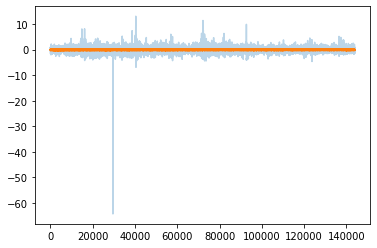

Epoch[2/10] | loss train:5489.070337, val loss:3916.816109 | lr:0.001000 | r2: 0.00556|
[ 0.00747226 -0.0819098  -0.01565807 ... -0.01323505 -0.00095502
 -0.06088712]
[-0.44629136 -0.5791562  -0.57901347 ... -1.2443814  -1.3298751
 -1.287301  ]


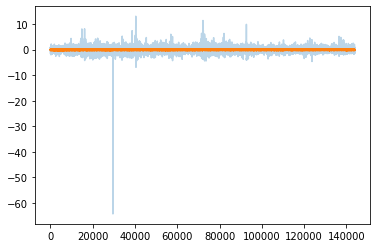

Epoch[3/10] | loss train:5483.866590, val loss:3915.537342 | lr:0.001000 | r2: 0.00589|
[-0.03328294 -0.05902303 -0.03008874 ...  0.00473841  0.00778214
 -0.05278239]
[-0.44629136 -0.5791562  -0.57901347 ... -1.2443814  -1.3298751
 -1.287301  ]


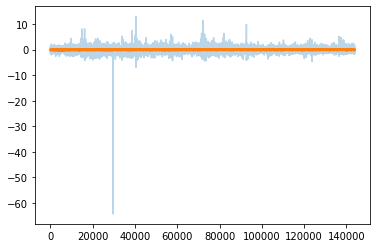

Epoch[4/10] | loss train:5481.492593, val loss:3915.082475 | lr:0.001000 | r2: 0.00600|
[-0.03923926 -0.02584634 -0.03239114 ... -0.01737702  0.00084266
 -0.05847941]
[-0.44629136 -0.5791562  -0.57901347 ... -1.2443814  -1.3298751
 -1.287301  ]


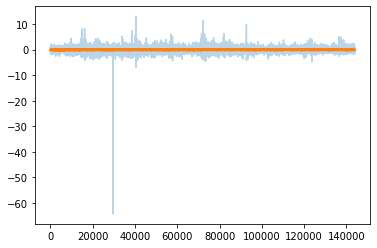

Epoch[5/10] | loss train:5478.197335, val loss:3914.830394 | lr:0.001000 | r2: 0.00606|
[-0.02794943 -0.05203418 -0.0091057  ... -0.03967562 -0.00015038
 -0.07497517]
[-0.44629136 -0.5791562  -0.57901347 ... -1.2443814  -1.3298751
 -1.287301  ]


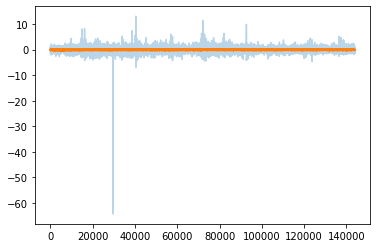

Epoch[6/10] | loss train:5476.975320, val loss:3913.791722 | lr:0.001000 | r2: 0.00633|
[-0.02370566 -0.07619166  0.0025603  ...  0.00533315  0.02694201
 -0.0505989 ]
[-0.44629136 -0.5791562  -0.57901347 ... -1.2443814  -1.3298751
 -1.287301  ]


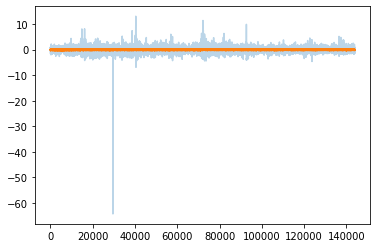

Epoch[7/10] | loss train:5474.454180, val loss:3913.764897 | lr:0.001000 | r2: 0.00634|
[-0.00930158 -0.04786336 -0.00424467 ... -0.02344907  0.00317734
 -0.0635593 ]
[-0.44629136 -0.5791562  -0.57901347 ... -1.2443814  -1.3298751
 -1.287301  ]


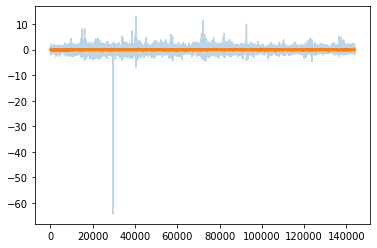

Epoch[8/10] | loss train:5474.663674, val loss:3915.274674 | lr:0.001000 | r2: 0.00595|
[-0.00141834 -0.0513318   0.00553564 ... -0.01689939 -0.0121221
 -0.07023253]
[-0.44629136 -0.5791562  -0.57901347 ... -1.2443814  -1.3298751
 -1.287301  ]


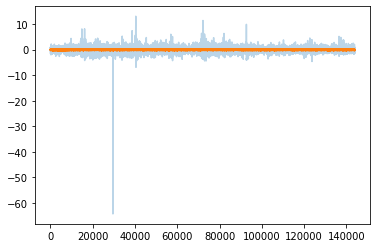

Epoch[9/10] | loss train:5470.182295, val loss:3915.408271 | lr:0.001000 | r2: 0.00592|
[ 0.0013586  -0.01970615  0.00163827 ... -0.03773938 -0.0074786
 -0.06822693]
[-0.44629136 -0.5791562  -0.57901347 ... -1.2443814  -1.3298751
 -1.287301  ]


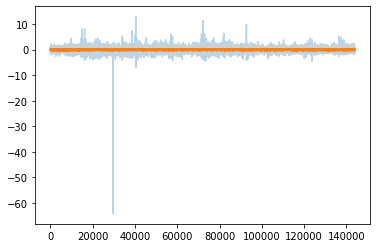

Epoch[10/10] | loss train:5467.211325, val loss:3917.262014 | lr:0.001000 | r2: 0.00545|
Train data shape (575897, 100, 42) (575897,)
Validation data shape (143975, 100, 42) (143975,)
[-0.01994167 -0.04680566 -0.00960875 ...  0.0199301  -0.01817218
 -0.07464267]
[-0.43788704 -0.56816894 -0.568105   ... -1.2207594  -1.444659
 -1.153882  ]


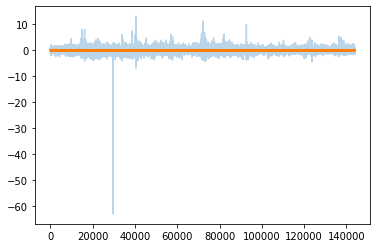

Epoch[1/10] | loss train:5509.554502, val loss:3919.656835 | lr:0.001000 | r2: 0.00519|
[-0.01040421 -0.04973839 -0.01156932 ...  0.00978113 -0.02719177
 -0.07047028]
[-0.43788704 -0.56816894 -0.568105   ... -1.2207594  -1.444659
 -1.153882  ]


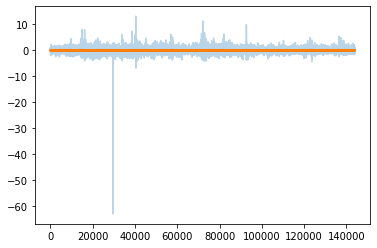

Epoch[2/10] | loss train:5489.666952, val loss:3918.627677 | lr:0.001000 | r2: 0.00545|
[-0.02598734 -0.04472712 -0.01756097 ...  0.0095223  -0.00080532
 -0.05216707]
[-0.43788704 -0.56816894 -0.568105   ... -1.2207594  -1.444659
 -1.153882  ]


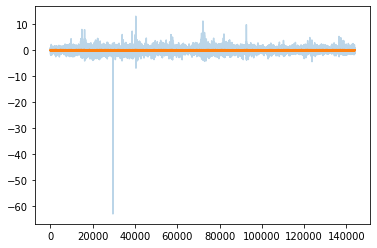

Epoch[3/10] | loss train:5484.173202, val loss:3918.356155 | lr:0.001000 | r2: 0.00551|
[-0.0284837  -0.07587767 -0.02937181 ... -0.0130414  -0.01247133
 -0.06662942]
[-0.43788704 -0.56816894 -0.568105   ... -1.2207594  -1.444659
 -1.153882  ]


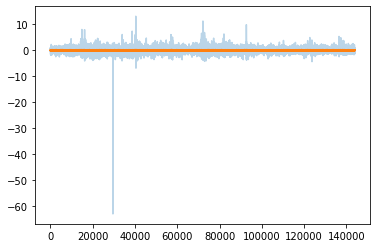

Epoch[4/10] | loss train:5482.091997, val loss:3917.934663 | lr:0.001000 | r2: 0.00562|
[-0.01320791 -0.08574563 -0.02273483 ... -0.00584997  0.00116738
 -0.06041081]
[-0.43788704 -0.56816894 -0.568105   ... -1.2207594  -1.444659
 -1.153882  ]


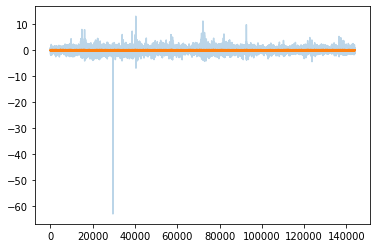

Epoch[5/10] | loss train:5479.150503, val loss:3917.884372 | lr:0.001000 | r2: 0.00563|
[-0.00058443 -0.06748957 -0.01934047 ... -0.02746679 -0.00535479
 -0.05450995]
[-0.43788704 -0.56816894 -0.568105   ... -1.2207594  -1.444659
 -1.153882  ]


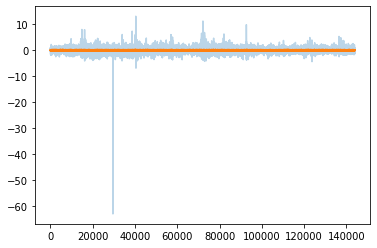

Epoch[6/10] | loss train:5477.305012, val loss:3916.568591 | lr:0.001000 | r2: 0.00597|
[ 0.0001525  -0.08150137 -0.01981295 ... -0.03211768  0.01183516
 -0.07463914]
[-0.43788704 -0.56816894 -0.568105   ... -1.2207594  -1.444659
 -1.153882  ]


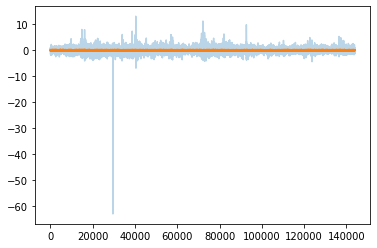

Epoch[7/10] | loss train:5475.412599, val loss:3917.243677 | lr:0.001000 | r2: 0.00580|
[ 0.02229681 -0.10098701  0.00877141 ... -0.01737177 -0.00343654
 -0.08970492]
[-0.43788704 -0.56816894 -0.568105   ... -1.2207594  -1.444659
 -1.153882  ]


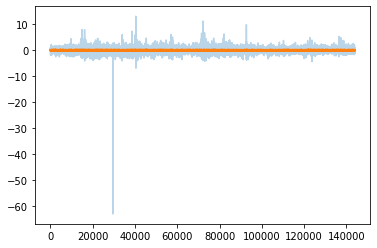

Epoch[8/10] | loss train:5473.696999, val loss:3916.529852 | lr:0.001000 | r2: 0.00598|
[ 0.02160498 -0.05405334 -0.01050409 ... -0.00261397 -0.00892232
 -0.08712544]
[-0.43788704 -0.56816894 -0.568105   ... -1.2207594  -1.444659
 -1.153882  ]


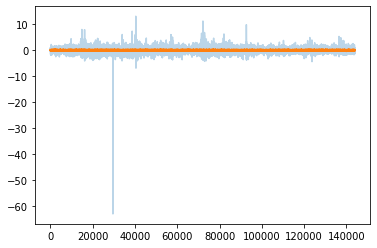

Epoch[9/10] | loss train:5470.959404, val loss:3917.397529 | lr:0.001000 | r2: 0.00576|
[ 0.02941344 -0.08210759 -0.01488068 ... -0.00443573  0.00512968
 -0.08312535]
[-0.43788704 -0.56816894 -0.568105   ... -1.2207594  -1.444659
 -1.153882  ]


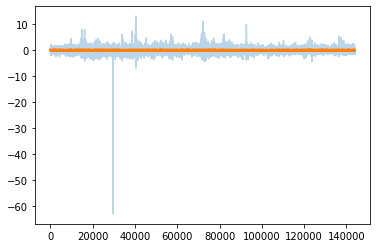

Epoch[10/10] | loss train:5466.023118, val loss:3919.915602 | lr:0.001000 | r2: 0.00512|
Train data shape (575896, 100, 42) (575896,)
Validation data shape (143975, 100, 42) (143975,)
[-0.03483282 -0.04507668 -0.00078791 ... -0.0179147  -0.02384654
 -0.06064133]
[-0.42984247 -0.55782914 -0.5577717  ... -1.3358376  -1.3111893
 -1.1331743 ]


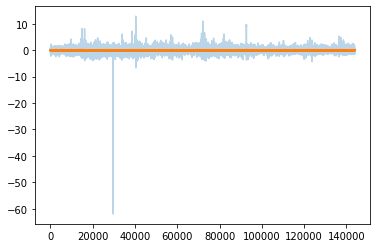

Epoch[1/10] | loss train:5511.303528, val loss:3921.526247 | lr:0.001000 | r2: 0.00495|
[-0.03308472 -0.05174913 -0.01996078 ...  0.01118001 -0.00834297
 -0.07459953]
[-0.42984247 -0.55782914 -0.5577717  ... -1.3358376  -1.3111893
 -1.1331743 ]


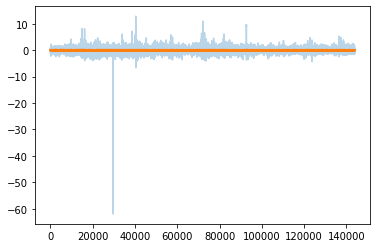

Epoch[2/10] | loss train:5490.622432, val loss:3920.289837 | lr:0.001000 | r2: 0.00526|
[-0.0175618  -0.05759941 -0.02029069 ...  0.00426291 -0.02597423
 -0.07457931]
[-0.42984247 -0.55782914 -0.5577717  ... -1.3358376  -1.3111893
 -1.1331743 ]


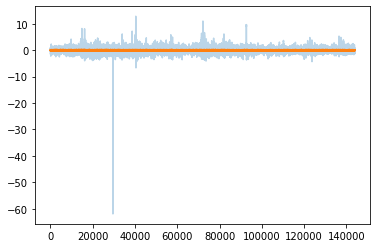

Epoch[3/10] | loss train:5485.755077, val loss:3918.922297 | lr:0.001000 | r2: 0.00561|
[ 0.00065855 -0.07949144 -0.02681476 ... -0.04712719 -0.04642488
 -0.09011052]
[-0.42984247 -0.55782914 -0.5577717  ... -1.3358376  -1.3111893
 -1.1331743 ]


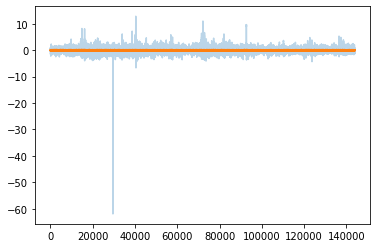

Epoch[4/10] | loss train:5483.585718, val loss:3918.846098 | lr:0.001000 | r2: 0.00563|
[-0.01788522 -0.08218287 -0.03834223 ... -0.0271401  -0.0580063
 -0.0921524 ]
[-0.42984247 -0.55782914 -0.5577717  ... -1.3358376  -1.3111893
 -1.1331743 ]


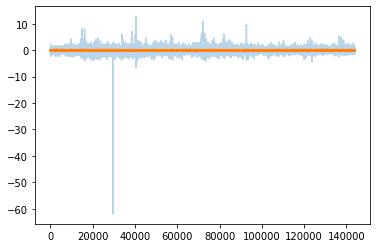

Epoch[5/10] | loss train:5481.519043, val loss:3918.693752 | lr:0.001000 | r2: 0.00567|
[-0.00087792 -0.0789039  -0.01203753 ... -0.00959671 -0.0303563
 -0.0654894 ]
[-0.42984247 -0.55782914 -0.5577717  ... -1.3358376  -1.3111893
 -1.1331743 ]


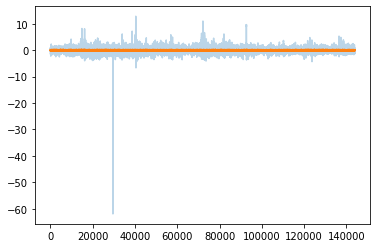

Epoch[6/10] | loss train:5478.911497, val loss:3918.528503 | lr:0.001000 | r2: 0.00571|
[-0.02166035 -0.03394003 -0.01145709 ... -0.01967729 -0.04120881
 -0.03878953]
[-0.42984247 -0.55782914 -0.5577717  ... -1.3358376  -1.3111893
 -1.1331743 ]


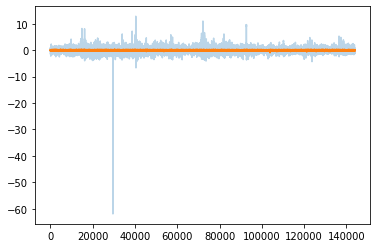

Epoch[7/10] | loss train:5476.796309, val loss:3919.092141 | lr:0.001000 | r2: 0.00557|
[-0.0257076  -0.07440157  0.0073766  ... -0.01231151 -0.02479156
 -0.02921284]
[-0.42984247 -0.55782914 -0.5577717  ... -1.3358376  -1.3111893
 -1.1331743 ]


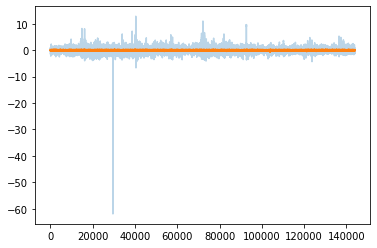

Epoch[8/10] | loss train:5476.086918, val loss:3918.440916 | lr:0.001000 | r2: 0.00573|
[-0.03400815 -0.00395503 -0.00820194 ... -0.00179321 -0.00088558
 -0.04386093]
[-0.42984247 -0.55782914 -0.5577717  ... -1.3358376  -1.3111893
 -1.1331743 ]


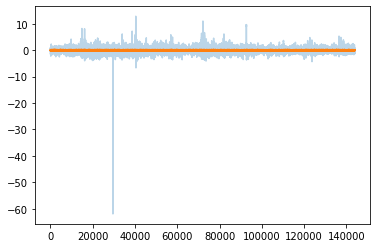

Epoch[9/10] | loss train:5473.257674, val loss:3917.599308 | lr:0.001000 | r2: 0.00595|
[ 0.01122775 -0.07955676  0.04526015 ...  0.01233357 -0.01120489
 -0.0720416 ]
[-0.42984247 -0.55782914 -0.5577717  ... -1.3358376  -1.3111893
 -1.1331743 ]


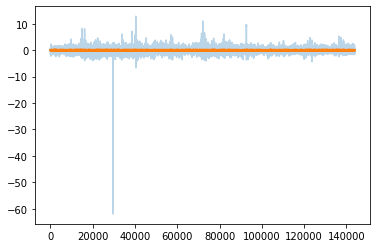

Epoch[10/10] | loss train:5469.968843, val loss:3917.507529 | lr:0.001000 | r2: 0.00597|
Train data shape (575896, 100, 42) (575896,)
Validation data shape (143974, 100, 42) (143974,)
[-4.3963082e-02 -8.9846551e-05 -6.2636204e-02 ... -2.3393895e-02
  2.8496981e-04 -8.2589276e-02]
[-0.5480166 -0.548003  -0.5481325 ... -1.2070327 -1.2883999 -1.1281148]


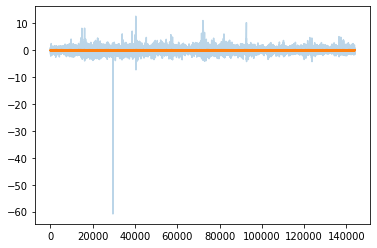

Epoch[1/10] | loss train:5510.673348, val loss:3923.994452 | lr:0.001000 | r2: 0.00455|
[-0.13178694  0.00680868 -0.11216561 ...  0.00314982 -0.00825325
 -0.06073539]
[-0.5480166 -0.548003  -0.5481325 ... -1.2070327 -1.2883999 -1.1281148]


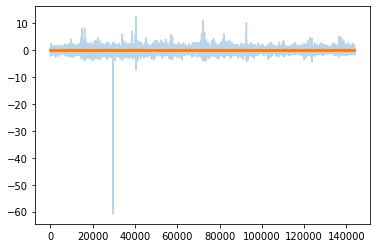

Epoch[2/10] | loss train:5490.773863, val loss:3922.844069 | lr:0.001000 | r2: 0.00485|
[-0.07142754 -0.02036218 -0.06435116 ...  0.00718604  0.00325376
 -0.06463473]
[-0.5480166 -0.548003  -0.5481325 ... -1.2070327 -1.2883999 -1.1281148]


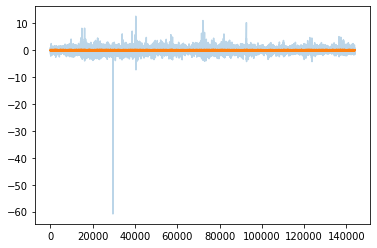

Epoch[3/10] | loss train:5486.233314, val loss:3922.499469 | lr:0.001000 | r2: 0.00493|
[-0.06081394 -0.02339665 -0.06482798 ... -0.00618959 -0.00360497
 -0.04642997]
[-0.5480166 -0.548003  -0.5481325 ... -1.2070327 -1.2883999 -1.1281148]


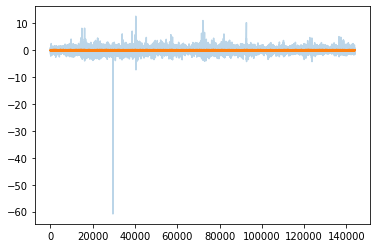

Epoch[4/10] | loss train:5483.452257, val loss:3921.704072 | lr:0.001000 | r2: 0.00513|
[-0.09569029 -0.03111094 -0.08616809 ... -0.00627943 -0.00723985
 -0.04667192]
[-0.5480166 -0.548003  -0.5481325 ... -1.2070327 -1.2883999 -1.1281148]


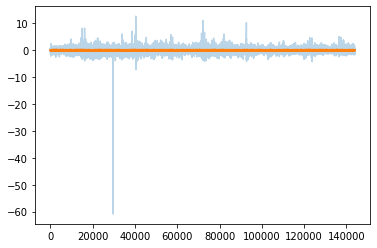

Epoch[5/10] | loss train:5479.464372, val loss:3921.357872 | lr:0.001000 | r2: 0.00522|
[-0.05868765 -0.0105185  -0.05054756 ... -0.01411685 -0.02427967
 -0.0517438 ]
[-0.5480166 -0.548003  -0.5481325 ... -1.2070327 -1.2883999 -1.1281148]


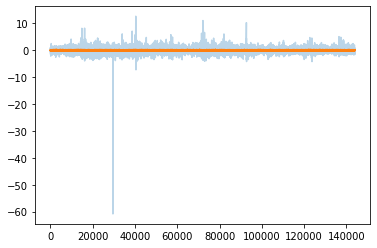

Epoch[6/10] | loss train:5477.536995, val loss:3921.330170 | lr:0.001000 | r2: 0.00523|
[-0.10269227  0.0143882  -0.07743449 ... -0.01119007 -0.03212952
 -0.07791305]
[-0.5480166 -0.548003  -0.5481325 ... -1.2070327 -1.2883999 -1.1281148]


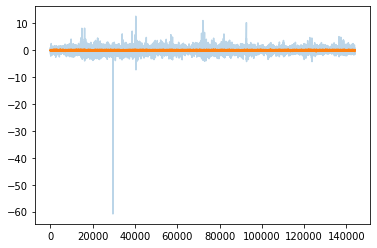

Epoch[7/10] | loss train:5472.797089, val loss:3923.102992 | lr:0.001000 | r2: 0.00478|
[-0.12063082  0.00202557 -0.09299809 ...  0.00522683 -0.02126211
 -0.04997047]
[-0.5480166 -0.548003  -0.5481325 ... -1.2070327 -1.2883999 -1.1281148]


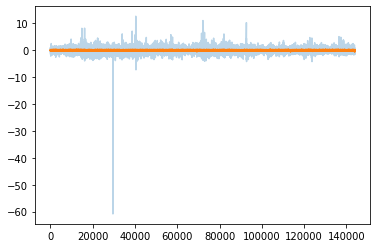

Epoch[8/10] | loss train:5471.216575, val loss:3923.498028 | lr:0.001000 | r2: 0.00468|
[-0.06675386  0.01904904 -0.09421488 ...  0.03701402  0.02560357
 -0.02408485]
[-0.5480166 -0.548003  -0.5481325 ... -1.2070327 -1.2883999 -1.1281148]


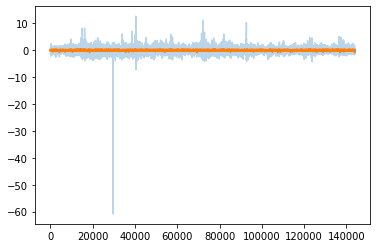

Epoch[9/10] | loss train:5466.759001, val loss:3925.374005 | lr:0.001000 | r2: 0.00421|
[-0.05611328  0.09802859 -0.07094656 ...  0.03025172  0.02318054
  0.04563028]
[-0.5480166 -0.548003  -0.5481325 ... -1.2070327 -1.2883999 -1.1281148]


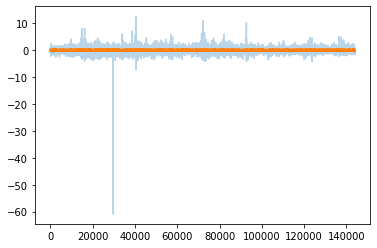

Epoch[10/10] | loss train:5464.936759, val loss:3921.341386 | lr:0.001000 | r2: 0.00523|


In [ ]:
# lag=1

save_path = os.path.join('/content/drive/MyDrive/IP/Repos/HFTransformer/results_LSTM',
                            str(int(time.time()))+'_results.csv')

forecast_windows = [i for i in range(1,31)]
# forecast_windows = [35, 40, 45, 50, 55, 60]

for lag in forecast_windows:
    orderbook = augment_trade_data(agg_trade, forecast_window=lag)

    features = ['price', 'lag_return',
                'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
                'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9', 'bid10', 'bidqty10',
                'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
                'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9', 'bid10', 'bidqty10']

    split_index, data_x_train, data_y_train, data_x_val, data_y_val = prepare_data(np.array(orderbook[features][1_000_000:1_720_000]),
                                                                                                                            np.array(agg_trade.datetime[2_005_000:2_006_000]),
                                                                                                                            np.array(orderbook[features][60_000:60_600]),
                                                                                                                            np.array(agg_trade.datetime[60_000:60_600]),
                                                                                                                            config, lag=lag, plot=False)
    #, data_x_unseen, data_x_test, data_y_test
    # del data_x_test
    # del data_y_test
    # del data_x_unseen


    dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
    dataset_val = TimeSeriesDataset(data_x_val, data_y_val)
    # dataset_test = TimeSeriesDataset(data_x_test, data_y_test)

    print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
    print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
    # print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)


    model_MO = LSTM_MO(input_size=len(features), hidden_layer_size=64,
                    num_layers=2, output_size=config["model_MO"]["output_size"], dropout=0.2)

    model_MO = model_MO.to(device)

    # create DataLoader
    train_dataloader = DataLoader(dataset_train, batch_size=config["training_MO"]["batch_size"], shuffle=False)
    val_dataloader = DataLoader(dataset_val, batch_size=config["training_MO"]["batch_size"], shuffle=False)

    model_MO.train_model(train_dataloader=train_dataloader, val_dataloader=val_dataloader, learning_rate=0.001,
                scheduler_step_size=config["training_MO"]["scheduler_step_size"], n_epochs=10,
                device='cuda', save_path=save_path, forecast_window=lag)

    # date_now = datetime.now()
    # timestamp = date_now.strftime("%d-%b-%Y_%H:%M:%S.%f")
    del data_x_train 
    del data_y_train
    del data_x_val
    del data_y_val

    # torch.save(model_MO, f'/content/drive/MyDrive/IP/Repos/HFTransformer/models/LSTM_MO_LAG_{lag}.pt')

(array([2.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 5.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 1.000e+01,
        4.000e+00, 6.000e+00, 7.000e+00, 6.000e+00, 6.000e+00, 7.000e+00,
        2.100e+01, 2.000e+01, 1.700e+01, 2.500e+01, 2.500e+01, 2.400e+01,
        4.000e+01, 4.600e+01, 5.000e+01, 6.800e+01, 7.300e+01, 1.060e+02,
        9.800e+01, 1.060e+02, 1.660e+02, 1.730e+02, 1.950e+02, 2.820e+02,
        3.540e+02, 3.770e+02, 5.310e+02, 6.430e+02, 7.410e+02, 1.042e+03,
        1.264e+03, 1.572e+03, 1.936e+03, 2.203e+03, 2.506e+03, 3.030e+03,
        3.442e+03, 3.886e+03, 3.978e+03, 4.109e+03, 3.701e+03, 9.199e+03,
        3.905e+03, 3.822e+03, 3.622e+03, 3.431e+03, 2.980e+03, 2.615e+03,
        2.225e+03, 1.871e+03, 1.576e+03, 1.208e+03, 1.058e+03, 8.850e+02,
        7.460e+02, 6.370e+02, 4.610e+02, 3.920e+02, 3.150e+02, 2.830e+02,
        2.410e+02, 1.950e+02, 2.030e+0

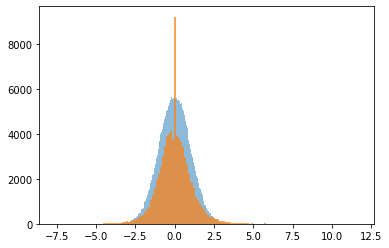

In [ ]:
plt.hist(np.random.normal(size = len(data_y_train)*3), bins=150, alpha=0.5)
plt.hist(data_y_train, bins=150, alpha=0.7)

In [ ]:
np.std(data_y_train)

1.087750500704166

In [ ]:
lags = [i for i in range(31)]

orderbook = augment_trade_data(agg_trade, forecast_window=lag)
means = []
stds = []

for lag in lags:
    split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen, data_x_test, data_y_test = prepare_data(np.array(orderbook[['price','bid1']][1_200_000:2_200_000]),
                                                                                                                        np.array(agg_trade.datetime[2_000_000:2_100_000]),
                                                                                                                        np.array(orderbook[['price','bid1']][60_000:65_000]),
                                                                                                                        np.array(agg_trade.datetime[60_000:65_000]),
                                                                                                                        config, lag=lag, plot=False)
    mean = np.mean(data_y_train)
    std =  np.std(data_y_train)
    means.append(mean) 
    stds.append(std)             
    print(f'mean for lag {lag} {mean}')
    print(f'std for lag {lag} {std}')

(999900, 100, 2)
(999900,)
mean for lag 0 0.0
std for lag 0 0.0
(999899, 100, 2)
(999899,)
mean for lag 1 -0.002052977139672308
std for lag 1 1.0858796465521126
(999898, 100, 2)
(999898,)
mean for lag 2 -0.00410467584064107
std for lag 2 1.556017011973598
(999897, 100, 2)
(999897,)
mean for lag 3 -0.006154055526544967
std for lag 3 1.9217677462946574
(999896, 100, 2)
(999896,)
mean for lag 4 -0.008209040207585516
std for lag 4 2.228366158793651
(999895, 100, 2)
(999895,)
mean for lag 5 -0.010265174427752983
std for lag 5 2.4953964400714703
(999894, 100, 2)
(999894,)
mean for lag 6 -0.012325079093808363
std for lag 6 2.7358125435737817
(999893, 100, 2)
(999893,)
mean for lag 7 -0.014386081809158619
std for lag 7 2.9571307584237307
(999892, 100, 2)
(999892,)
mean for lag 8 -0.01644461902502651
std for lag 8 3.162067860737714
(999891, 100, 2)
(999891,)
mean for lag 9 -0.01850095315869017
std for lag 9 3.3548281065515297
(999890, 100, 2)
(999890,)
mean for lag 10 -0.020558902994898685
std 

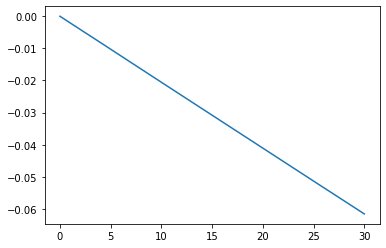

In [ ]:
plt.plot(means)

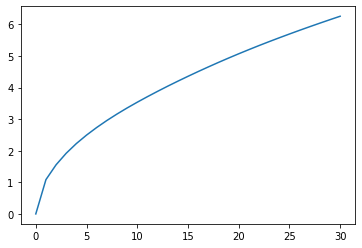

In [ ]:
plt.plot(stds)

In [ ]:
stds

[0.0,
 1.0858796465521126,
 1.556017011973598,
 1.9217677462946574,
 2.228366158793651,
 2.4953964400714703,
 2.7358125435737817,
 2.9571307584237307,
 3.162067860737714,
 3.3548281065515297,
 3.537155608454229,
 3.7120803017636343,
 3.8808702095312335,
 4.044880312115551,
 4.203159819962728,
 4.357240893877246,
 4.507623049042775,
 4.653999189174414,
 4.796852126690666,
 4.935546171850454,
 5.070954087157907,
 5.202354852476439,
 5.331115430725617,
 5.455929523510874,
 5.577672557351427,
 5.697165151141915,
 5.814317438031195,
 5.928886728694055,
 6.041188956291376,
 6.151541924601213,
 6.259825384143825]

## Model training - Many to Many 

In [ ]:
model_MM = LSTM_MM(input_size=x_train.shape[2], hidden_size=config["model_MM"]["lstm_size"],
                   num_layers=config["model_MM"]["num_lstm_layers"], dropout=config["model_MM"]["dropout"])

model_MM = model_MM.to(device)

train_loss, val_loss = model_MM.train_model(x_train, y_train, x_val, y_val, target_len=config["model_MM"]["target_len"], device=device,
                  n_epochs=config["training_MM"]["num_epoch"], learning_rate = config["training_MM"]["learning_rate"],
                  batch_size=config["training_MM"]["batch_size"], training_prediction="mixed_teacher_forcing")#, dynamic_tf=True)

date_now = datetime.now()
timestamp = date_now.strftime("%d-%b-%Y_%H:%M:%S.%f")

model_path = config["paths"]["drive"]["models"] if drive else config["paths"]["local"]["models"]

torch.save(model_MM, model_path+"lstm_mm_"+timestamp+".pt")

100%|██████████| 15/15 [05:20<00:00, 21.37s/it, train_loss=0.005, val_loss=0.073]


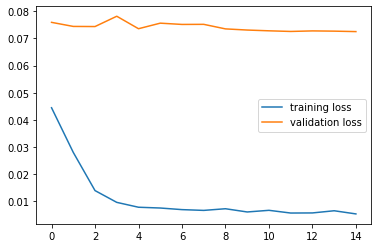

In [ ]:
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.legend()
plt.show()

## Evaluation - LSTM MO

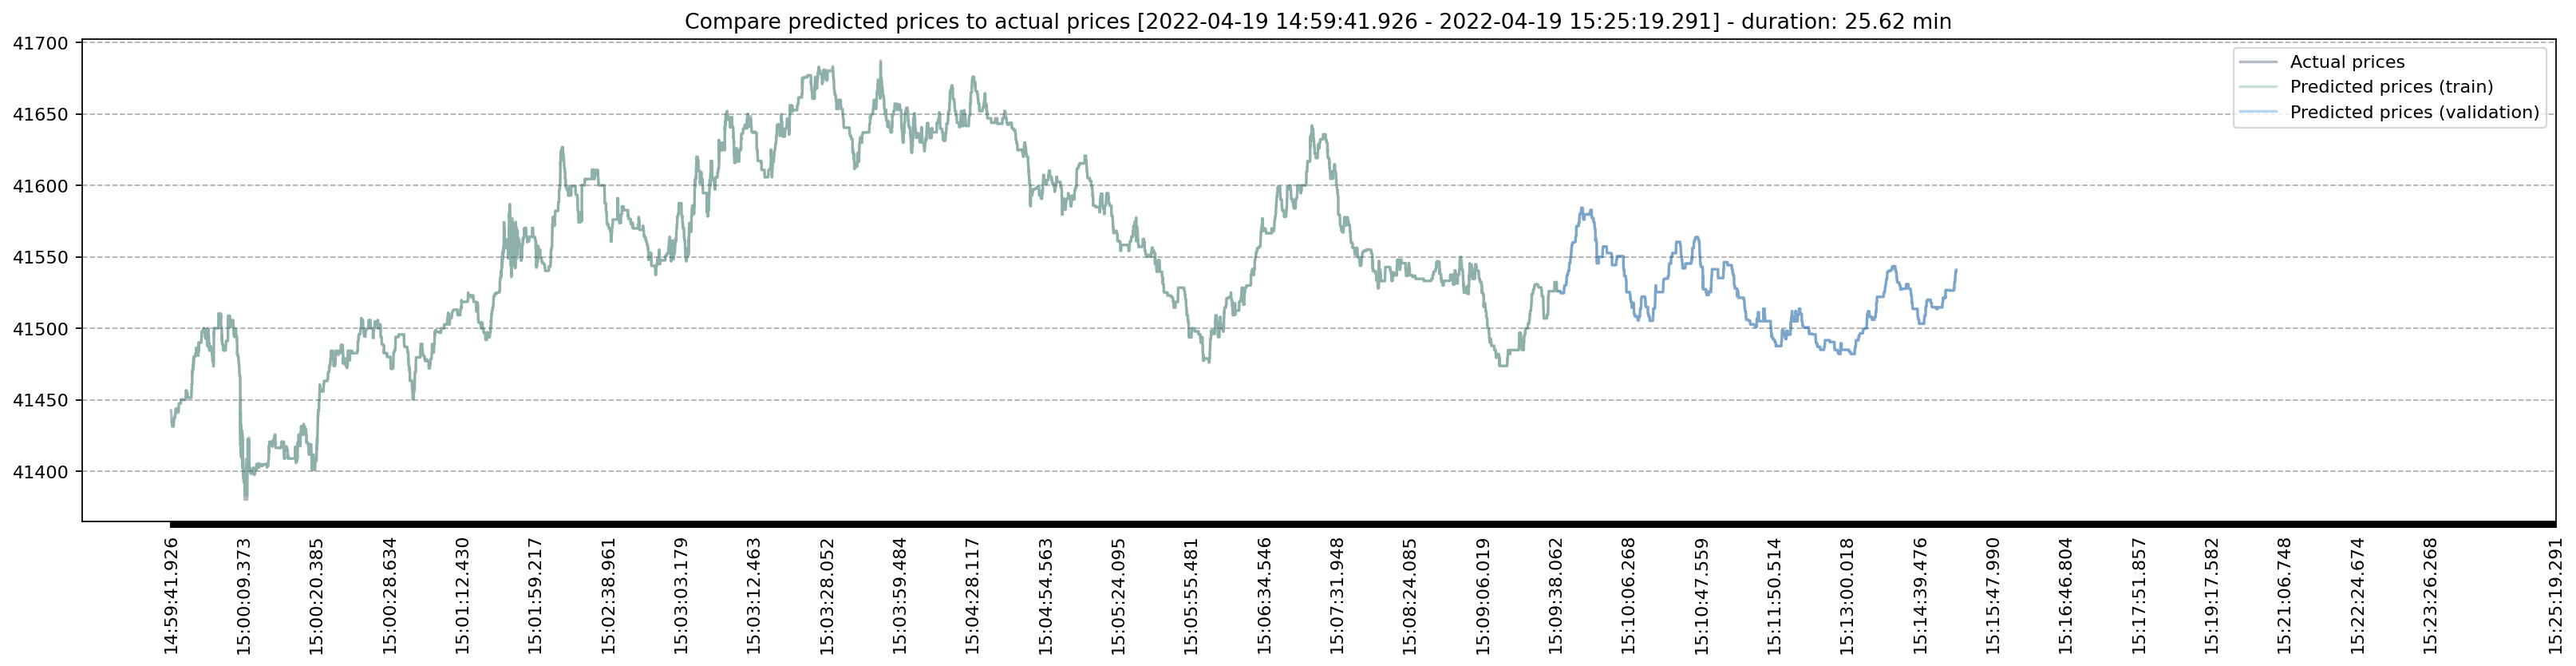

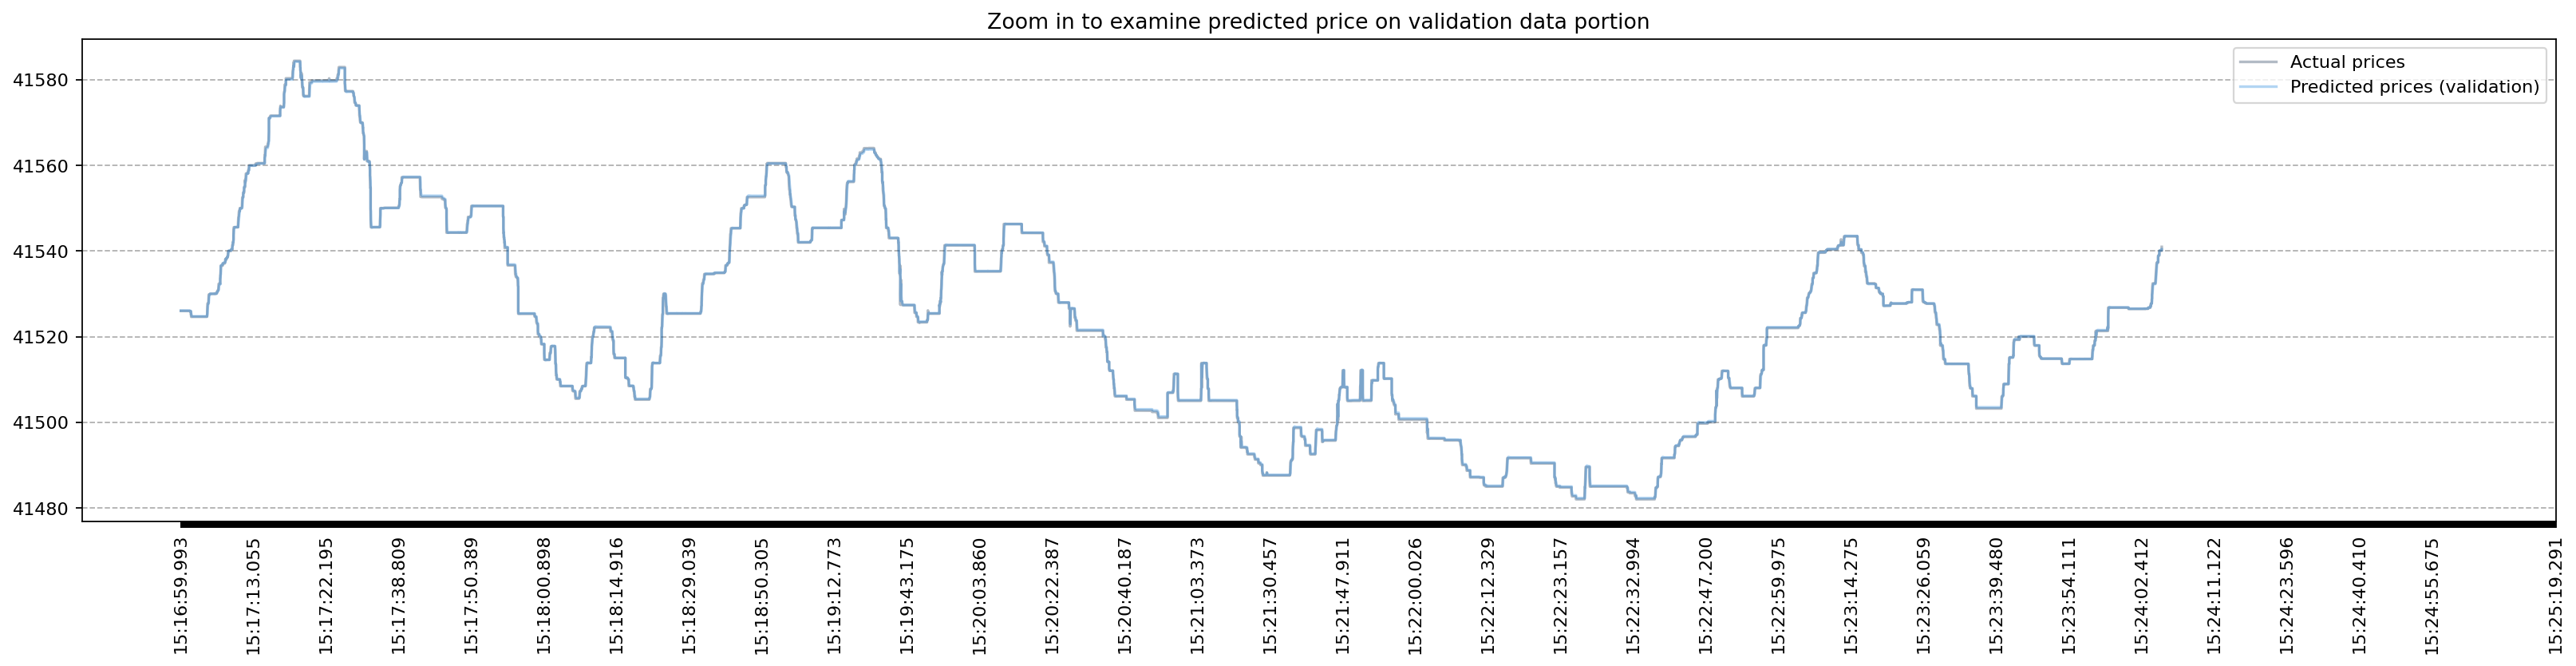

In [ ]:
list_of_files = glob.glob(model_path+'lstm_MO*')
latest_file = max(list_of_files, key=os.path.getctime)
model_MO = torch.load(latest_file)

# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model_MO.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(device)
    out = model_MO(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model_MO(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(len(prices_train))
    to_plot_data_y_val_pred = np.zeros(len(prices_train))

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=160)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(dates_train, prices_train, label="Actual prices", color=config["plots"]["color_actual"], alpha=0.3)
    plt.plot(dates_train, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"], alpha=0.3)
    plt.plot(dates_train, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"], alpha=0.3)
    
    timediff=parser.parse(dates_train[-1])-parser.parse(dates_train[0])
    timediff=timediff.seconds/60
    
    plt.title("Compare predicted prices to actual prices ["+str(dates_train[0])+" - "+str(dates_train[-1])+"] - duration: "+"{:.2f}".format(timediff)+" min")
    xticks = [dates_train[i][11:] if ((i%config["plots"]["xticks_interval"]==0 and (len(prices_train)-i) > config["plots"]["xticks_interval"])
                               or i==len(prices_train)-1) else None for i in range(len(prices_train))] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = dates_train[split_index+config["data"]["window_size"]:]

    # plots

    fig = figure(figsize=(25, 5), dpi=160)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"], alpha=0.3)
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"], alpha=0.3)
    plt.title("Zoom in to examine predicted price on validation data portion")
    xticks = [to_plot_data_date[i][11:] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6)
                                       or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

## Predicting future stock prices

In [ ]:
# predict on the unseen data, tomorrow's price 
test_dataloader = DataLoader(dataset_test, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

predicted_test = np.array([])

for idx, (x, y) in enumerate(test_dataloader):
    x = x.to(device)
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_test = np.concatenate((predicted_test, out))

predictions = scaler.inverse_transform(predicted_test)

if config["plots"]["show_plots"]:
        
    # prepare plots

    plot_range = 3300
    to_plot_data_y_test = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_test = prices_test[:plot_range]
    to_plot_data_y_test_pred = predictions[:plot_range]

    # plot
    plot_date_test = dates_train[:plot_range]

    fig = figure(figsize=(25, 5), dpi=160)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_test, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted prices", color=config["plots"]["color_pred_test"])
        
    timediff=parser.parse(plot_date_test[-1])-parser.parse(plot_date_test[0])
    timediff=timediff.seconds/60
    
    plt.title("Predicted Price vs Actual Price"+ " - duration: "+"{:.2f}".format(timediff)+" min")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.xticks([])
    plt.legend()
    plt.show()

## Evaluation - LSTM MM

In [ ]:
def plot_train_test_results(lstm_model, Xtrain, Ytrain, Xtest, Ytest, device, num_rows = 4):
  '''
  plot examples of the lstm encoder-decoder evaluated on the training/test data
  : param lstm_model:     trained lstm encoder-decoder
  : param Xtrain:         np.array of windowed training input data
  : param Ytrain:         np.array of windowed training target data
  : param Xtest:          np.array of windowed test input data
  : param Ytest:          np.array of windowed test target data 
  : param num_rows:       number of training/test examples to plot
  : return:               num_rows x 2 plots; first column is training data predictions,
  :                       second column is test data predictions
  '''
  # input window size
  iw = Xtrain.shape[0]
  ow = Ytest.shape[0]

  # figure setup 
  num_cols = 2
  num_plots = num_rows * num_cols

  fig, ax = plt.subplots(num_rows, num_cols, figsize = (16, 15))
  
  # plot training/test predictions
  for ii in range(num_rows):
      # train set
      jj = ii*300 # *1000 to skip to different time frames

      X_train_plt = Xtrain[:, jj, :]
      Y_train_pred = lstm_model.predict(torch.from_numpy(X_train_plt).type(torch.Tensor).to(device), target_len = ow)

      ax[ii, 0].plot(np.arange(0, iw), Xtrain[:, jj, 0], 'k', linewidth = 2, label = 'Input')
      ax[ii, 0].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, jj, 0]], Ytrain[:, jj, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
      ax[ii, 0].plot(np.arange(iw - 1, iw + ow),  np.concatenate([[Xtrain[-1, jj, 0]], Y_train_pred[:, 0]]),
                     color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
      ax[ii, 0].set_xlim([0, iw + ow - 1])
      ax[ii, 0].set_xlabel('$t$')
      ax[ii, 0].set_ylabel('$y$')

      # test set
      X_test_plt = Xtest[:, jj, :]
      Y_test_pred = lstm_model.predict(torch.from_numpy(X_test_plt).type(torch.Tensor).to(device), target_len = ow)
      ax[ii, 1].plot(np.arange(0, iw), Xtest[:, jj, 0], 'k', linewidth = 2, label = 'Input')
      ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, jj, 0]], Ytest[:, jj, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
      ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, jj, 0]], Y_test_pred[:, 0]]),
                     color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
      ax[ii, 1].set_xlim([0, iw + ow - 1])
      ax[ii, 1].set_xlabel('$t$')
      ax[ii, 1].set_ylabel('$y$')

      if ii == 0:
        ax[ii, 0].set_title('Train')
        
        ax[ii, 1].legend(bbox_to_anchor=(1, 1))
        ax[ii, 1].set_title('Test')

  plt.suptitle('LSTM Encoder-Decoder Predictions', x = 0.445, y = 1.)
  plt.tight_layout()
  plt.subplots_adjust(top = 0.95)
  path = config["paths"]["drive"]["figures"] if drive else config["paths"]["local"]["figures"]

  date_now = datetime.now()
  timestamp = date_now.strftime("%d-%b-%Y_%H:%M:%S.%f")

  plt.savefig(path+'LSTM_MM_predictions'+timestamp+'.png')
  plt.show()
      
  return 

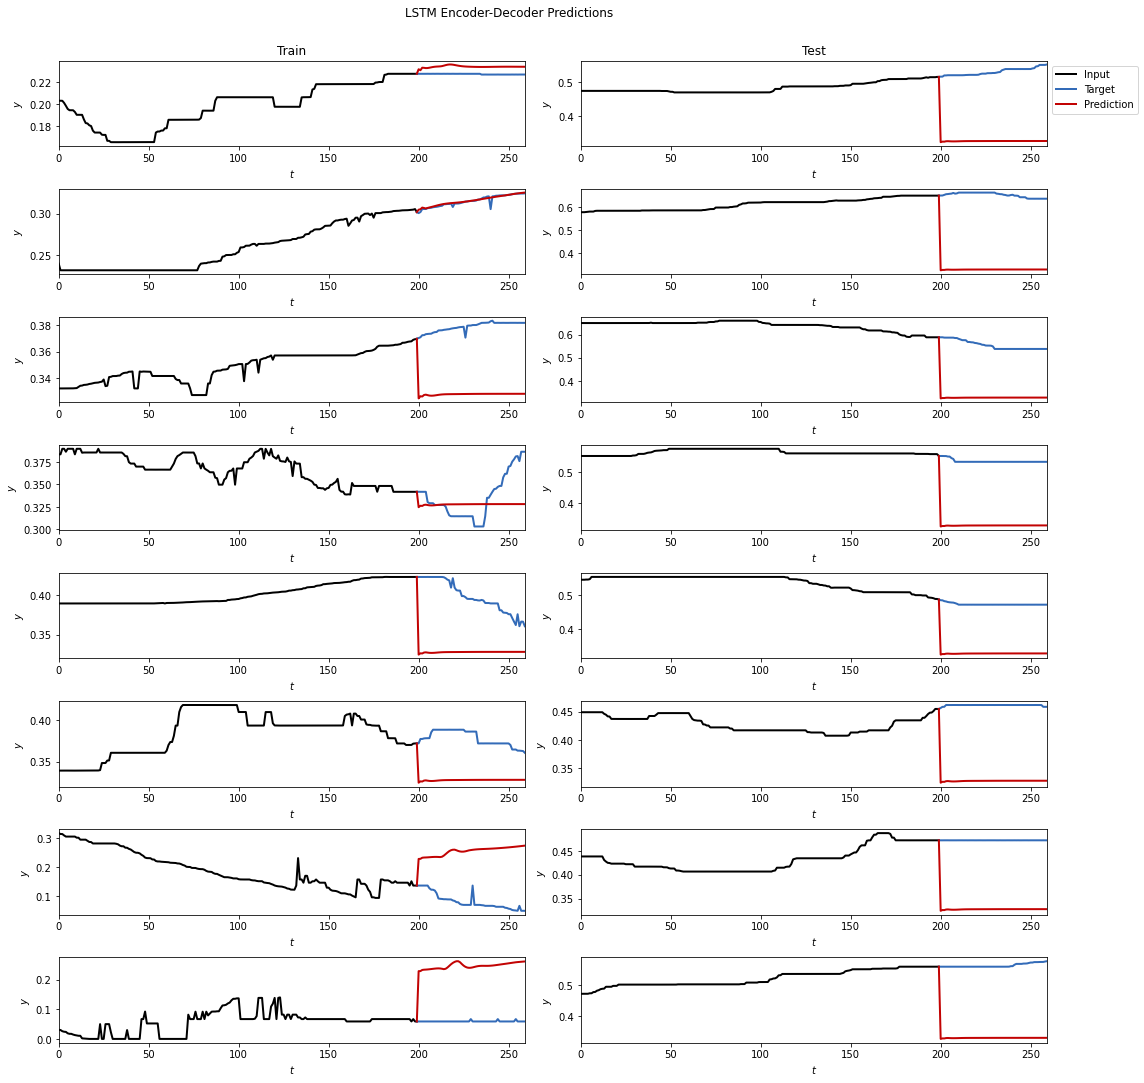

In [ ]:
model_path = config["paths"]["drive"]["models"] if drive else config["paths"]["local"]["models"]

list_of_files = glob.glob(model_path+'lstm_mm*')
latest_file = max(list_of_files, key=os.path.getctime)
model_MM = torch.load(latest_file)

plot_train_test_results(model_MM, x_train_to_plot, y_train_to_plot, x_val_to_plot, y_val_to_plot, device, num_rows = 8)

In [ ]:
model_MM.predict(torch.from_numpy(x_train_to_plot[:,40,:]).type(torch.Tensor).to(device), target_len=config["model_MM"]["target_len"]) - model_MM.predict(torch.from_numpy(x_train_to_plot[:,1000,:]).type(torch.Tensor).to(device), target_len=config["model_MM"]["target_len"])

In [ ]:
def forecast_prices(model, normalized_prices_test, window_size, forecast_length, features):
    n_samples = int(len(normalized_prices_test)/(window_size-forecast_length))-1

    inputs = np.zeros([n_samples, window_size, features])
    
    for idx in range(n_samples):
        inputs[idx,:,:] = normalized_prices_test[idx*forecast_length:(idx)*forecast_length+window_size].reshape(-1, features)
    
    forecasts = np.zeros([(n_samples-1)*forecast_length, features])
    for idx in range(n_samples-1):
        forecasts[idx*forecast_length:(idx+1)*forecast_length] = model_MM.predict(torch.from_numpy(inputs[idx,:,:]).type(torch.Tensor).to(device),
                                                                                  target_len=forecast_length)
    true_prices = normalized_prices_test[window_size:(n_samples-1)*forecast_length+window_size]
    forecasts = forecasts.flatten()

    return forecasts, true_prices

Text(0, 0.5, 'price')

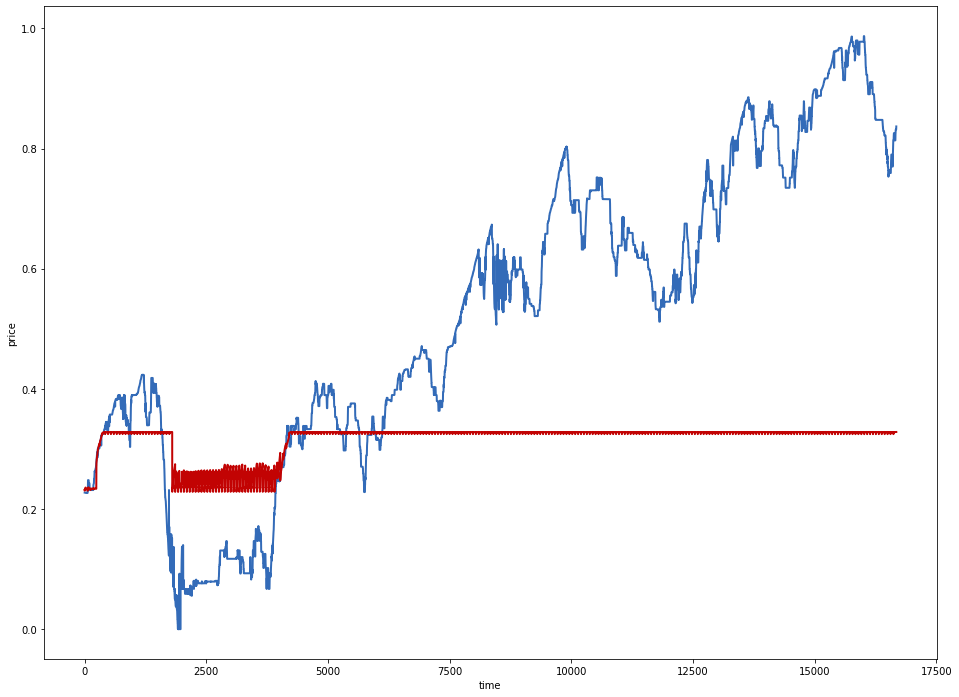

In [ ]:
forecasts, true_prices = forecast_prices(model_MM, normalized_prices_train, config["data"]["window_size"],
                          config["model_MM"]["target_len"], 1)

fig, ax = plt.subplots(1, 1, figsize = (16, 12))

ax.plot(np.arange(len(true_prices)), true_prices, color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
ax.plot(np.arange(len(true_prices)), forecasts, color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
ax.set_xlabel('time')
ax.set_ylabel('price')